#### Note that in this version of OptScale 1, we no longer use MuSigmaPredictor for MLE starting point. Instead, we set Mu = 0.8 and Sigma = 0.2 for all datasets, making this a simplified but still effective OptScale.

In [1]:
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import root
from scipy.optimize import minimize
from tqdm import tqdm
import os 

from utils import *

# Set random seed for reproducibility (same as in train_predictor_initial.py)
torch.manual_seed(42)
np.random.seed(42)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

DATASET = 'MATH500'

/home/wangyoukang/anaconda3/envs/test_scale/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [ ]:
# Initialize tokenizer - same model as in train_predictor_initial.py
model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

def load_validation_data(batch_size=16):
    with open('../data/test_prompts/math500_test.json', 'r') as f:
        dataset = json.load(f)
        
    with open('../data/completions/r1_distill_qwen7b/parallel/scored_qwen7b_par_math500_64.json', 'r') as f:
        completion_data = json.load(f)
    
    # Prepare data
    texts = [item['problem'] for item in dataset]
    gt_answers = [item['answer'] for item in dataset]
    completions = [item['score']['completions'] for item in completion_data]
    completion_tokens = [item['score']['completion_tokens'] for item in completion_data]
    scores = [item['score']['scores'] for item in completion_data]
    
    val_texts = texts
    val_gt_answers = gt_answers
    val_completions = completions
    val_completion_tokens = completion_tokens
    val_scores = scores
    
    print(f"Total dataset size: {len(texts)}")
    print(f"Validation size: {len(val_texts)}")
    
    # Load or predict mu/sigma parameters
    if os.path.exists(f'{DATASET}_train_mu_sigma.json'):
        print("Loading existing mu/sigma parameters...")
        with open(f'{DATASET}_train_mu_sigma.json', 'r') as f:
            val_labels = json.load(f)
    else:
        print("Predicting mu/sigma parameters using QwenMuSigmaPredictor...")
        
        # Clear GPU cache before loading model
        torch.cuda.empty_cache()
        
        # Load model on CPU first to avoid GPU memory issues
        # print("Loading model on CPU first...")
        model = QwenMuSigmaPredictor(model_name).to(device)
        
        # Load checkpoint on CPU
        checkpoint_path = '../train_predictor/checkpoints_direct_qwen_real/best_predictor_model_direct_qwen_real.pt'
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        model.load_state_dict(checkpoint)
        
        # # Move model to GPU after loading checkpoint
        # print("Moving model to GPU...")
        # model = model.to(device)
        # model.eval()
        
        # # Clear CPU cache
        # del checkpoint
        # torch.cuda.empty_cache()
        
        # Create dataset and dataloader for prediction
        val_dataset = TextDatasetNoLabels(val_texts, tokenizer)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        # Make predictions
        val_labels = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                outputs = model(input_ids, attention_mask)
                val_labels.extend(outputs.cpu().numpy().tolist())
        
        # Save predictions
        with open(f'{DATASET}_train_mu_sigma.json', 'w') as f:
            json.dump(val_labels, f)
            
    # Create validation dataset and dataloader
    val_dataset = TextDataset(val_texts, val_labels, tokenizer)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    return val_loader, val_texts, val_gt_answers, val_completions, val_completion_tokens, val_scores, val_labels, tokenizer

# Load validation data
val_loader, val_texts, val_gt_answers, val_completions, val_completion_tokens, val_scores, val_labels, tokenizer = load_validation_data()


Total dataset size: 500
Validation size: 500
Predicting mu/sigma parameters using QwenMuSigmaPredictor...
Qwen2Model(
  (embed_tokens): Embedding(151936, 1536)
  (layers): ModuleList(
    (0-27): 28 x Qwen2DecoderLayer(
      (self_attn): Qwen2Attention(
        (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
        (k_proj): Linear(in_features=1536, out_features=256, bias=True)
        (v_proj): Linear(in_features=1536, out_features=256, bias=True)
        (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
      )
      (mlp): Qwen2MLP(
        (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
        (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
        (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
    )
  )
  (norm): Qwen2RMSNorm((15

In [3]:
# Ground truth parameters (using full data)
original_params_compare = []
for idx, score in enumerate(val_scores):
    data = np.array(score[0][:100])
    initial_mu = np.mean(data)
    initial_sigma = np.std(data)
    result = minimize(lambda params: neg_log_likelihood(params, data), 
                     [initial_mu, initial_sigma],
                     bounds=[(None, None), (1e-6, None)], 
                     method='L-BFGS-B')
    mu_hat, sigma_hat = result.x
    original_params_compare.append((mu_hat, sigma_hat))

# Estimates using limited data (first 10 samples)
mle_estimated_params = []  # Store MLE estimates
map_estimated_params = []  # Store MAP estimates
predictor_params = []      # Store predictor's estimates

print("\nComparison of Estimation Methods (first 10 examples):")
print("ID   Predictor_μ   Predictor_σ  MLE_μ     MLE_σ     MAP_μ     MAP_σ     GT_μ      GT_σ")
print("-" * 90)

peek_number = 3

for i, (score, prediction) in enumerate(zip(val_scores, val_labels)):
    peek_data = np.array(score[0][:peek_number])
    
    # Store predictor's parameters
    prior_mu, prior_sigma = prediction
    predictor_params.append((prior_mu, prior_sigma))
    
    # MLE estimation with limited data
    initial_mu = np.mean(peek_data)
    initial_sigma = np.std(peek_data)
    mle_result = minimize(
        lambda params: neg_log_likelihood(params, peek_data),
        [initial_mu, initial_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    mle_mu, mle_sigma = mle_result.x
    mle_estimated_params.append((mle_mu, mle_sigma))
    
    # MAP estimation with limited data
    map_result = minimize(
        lambda params: neg_log_posterior(
            params, 
            peek_data, 
            prior_mu=prior_mu, 
            prior_sigma=prior_sigma
        ),
        [prior_mu, prior_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    map_mu, map_sigma = map_result.x
    map_estimated_params.append((map_mu, map_sigma))
    
    # Print comparison for first 50 examples
    if i < 50:
        gt_mu, gt_sigma = original_params_compare[i]
        print(f"{i:<4} {prior_mu:11.4f} {prior_sigma:11.4f} {mle_mu:9.4f} {mle_sigma:9.4f} "
              f"{map_mu:9.4f} {map_sigma:9.4f} {gt_mu:9.4f} {gt_sigma:9.4f}")

# Call the function to perform the analysis
analyze_estimation_performance(predictor_params, mle_estimated_params, map_estimated_params, original_params_compare)


/home/wangyoukang/anaconda3/envs/test_scale/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0



Comparison of Estimation Methods (first 10 examples):
ID   Predictor_μ   Predictor_σ  MLE_μ     MLE_σ     MAP_μ     MAP_σ     GT_μ      GT_σ
------------------------------------------------------------------------------------------
0         0.6015      0.1227    0.9630    0.0071    0.9738    0.0221    0.9559    0.0145
1         0.4543      0.0766    0.9641    0.0087    0.6543    0.2251    0.9781    0.0432
2         0.6429      0.1356    1.0311    0.0616    0.9158    0.0865    0.9637    0.0222
3         0.4399      0.0769    0.9680    0.0123    0.6358    0.2346    0.9713    0.0204
4         0.4217      0.1085    0.9932    0.0107    0.5967    0.2681   30.9907    0.8595
5         0.4133      0.0200    0.9920    0.0033    0.6280    0.2332    1.1051    0.0412
6         0.5740      0.1303    0.9729    0.0184    0.7764    0.1866   41.5896    1.1720
7         0.5280      0.0904    0.9589    0.0098    0.7431    0.1855    0.9732    0.0181
8         0.4172      0.0738    0.9375    0.0130    0.6

In [4]:
# Load baseline results
with open(f'{DATASET}_BoN_results.json', 'r') as f:
    data = json.load(f)

# Reconstruct the baseline arrays
baseline_accuracy_values = []
baseline_average_token_counts = []

for item in data:
    baseline_accuracy_values.append(item['accuracy'])
    baseline_average_token_counts.append(item['token_count'])

Target Score Panel: [0.85, 0.9, 0.925, 0.95, 0.96, 0.97, 0.98, 0.99]
Percentile Panel: [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
Max N: 8

Evaluating MLE Results...


Target Score (MLE):   0%|          | 0/8 [00:00<?, ?it/s]

MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 6, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 5, 3, 3, 3, 3, 3, 8, 3, 8, 3, 8, 8, 3, 8, 3, 3, 7, 3, 3, 3, 3, 7, 3, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 4, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.85, Percentile: 0.01
MLE - Accuracy: 0.9460, Average Token Count: 12282.07
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 5, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 4, 3, 3, 3, 3, 3, 8, 3, 8, 3, 8, 8, 3, 8, 3, 3, 6, 3, 3, 3, 3, 6, 3, 3, 7, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 4, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.85, Percentile: 0.02
MLE - Accuracy: 0.9480, Average Token Count: 12021.39
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 5, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 4, 3, 3, 3, 3, 3, 8, 3, 8, 3, 8, 8, 3, 8, 3, 3, 5, 3, 3, 3, 3, 6, 3, 3, 6, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.85, Percentile: 0.035
MLE - Accuracy: 0.9480, Average Token Count: 11807.97
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 4, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 8, 8, 3, 8, 3, 3, 4, 3, 3, 3, 3, 5, 3, 3, 5, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

MLE - Target Score: 0.85, Percentile: 0.05
MLE - Accuracy: 0.9480, Average Token Count: 11690.51
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 7, 8, 3, 8, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 5, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.85, Percentile: 0.075
MLE - Accuracy: 0.9480, Average Token Count: 11475.62
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 7, 8, 3, 8, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 4, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

Target Score (MLE):  12%|█▎        | 1/8 [00:08<00:59,  8.44s/it]

MLE - Target Score: 0.85, Percentile: 0.1
MLE - Accuracy: 0.9480, Average Token Count: 11353.96


MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 8, 4, 3, 3, 3, 3, 3, 8, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 8, 3, 7, 3, 4, 3, 3, 3, 8, 3, 8, 3, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 7, 3, 8, 3, 3, 3, 5, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.9, Percentile: 0.01
MLE - Accuracy: 0.9480, Average Token Count: 13176.98
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 8, 3, 6, 3, 3, 3, 3, 3, 8, 3, 8, 3, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 6, 3, 8, 3, 3, 3, 4, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.9, Percentile: 0.02
MLE - Accuracy: 0.9460, Average Token Count: 12971.55
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 6, 3, 3, 3, 3, 3, 8, 3, 8, 3, 8, 8, 3, 8, 3, 3, 7, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 5, 3, 8, 3, 3, 3, 4, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.9, Percentile: 0.035
MLE - Accuracy: 0.9460, Average Token Count: 12746.03
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 7, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 5, 3, 3, 3, 3, 3, 8, 3, 8, 3, 8, 8, 3, 8, 3, 3, 7, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 5, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.9, Percentile: 0.05
MLE - Accuracy: 0.9460, Average Token Count: 12632.86
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 6, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 4, 3, 3, 3, 3, 3, 8, 3, 8, 3, 8, 8, 3, 8, 3, 3, 6, 3, 3, 3, 3, 7, 3, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 4, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.9, Percentile: 0.075
MLE - Accuracy: 0.9460, Average Token Count: 12419.30
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 6, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 4, 3, 3, 3, 3, 3, 8, 3, 8, 3, 8, 8, 3, 8, 3, 3, 5, 3, 3, 3, 3, 7, 3, 3, 7, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 4, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

Target Score (MLE):  25%|██▌       | 2/8 [00:16<00:48,  8.15s/it]

MLE - Target Score: 0.9, Percentile: 0.1
MLE - Accuracy: 0.9460, Average Token Count: 12315.75


MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 8, 5, 3, 3, 3, 3, 3, 8, 6, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 4, 5, 3, 3, 3, 8, 3, 8, 5, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 3, 8, 3, 6, 3, 6, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 5, 3, 6, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.925, Percentile: 0.01
MLE - Accuracy: 0.9480, Average Token Count: 13947.97
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 8, 4, 3, 3, 3, 3, 3, 8, 5, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 3, 5, 3, 3, 3, 8, 3, 8, 4, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 3, 8, 3, 5, 3, 5, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

MLE - Target Score: 0.925, Percentile: 0.02
MLE - Accuracy: 0.9480, Average Token Count: 13674.62
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 8, 4, 3, 3, 3, 3, 3, 8, 4, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 3, 4, 3, 3, 3, 8, 3, 8, 3, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 3, 8, 3, 5, 3, 5, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

MLE - Target Score: 0.925, Percentile: 0.035
MLE - Accuracy: 0.9480, Average Token Count: 13523.43
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 4, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 7, 3, 4, 3, 3, 3, 8, 3, 8, 3, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 7, 3, 8, 3, 4, 3, 4, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.925, Percentile: 0.05
MLE - Accuracy: 0.9460, Average Token Count: 13324.92
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 8, 3, 6, 3, 3, 3, 3, 3, 8, 3, 8, 3, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 6, 3, 8, 3, 4, 3, 4, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

MLE - Target Score: 0.925, Percentile: 0.075
MLE - Accuracy: 0.9460, Average Token Count: 13219.46
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 8, 3, 5, 3, 3, 3, 3, 3, 8, 3, 8, 3, 8, 8, 3, 8, 3, 3, 7, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 5, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

Target Score (MLE):  38%|███▊      | 3/8 [00:24<00:41,  8.28s/it]

MLE - Target Score: 0.925, Percentile: 0.1
MLE - Accuracy: 0.9460, Average Token Count: 12988.46


MLE Min N Required [3, 3, 4, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 7, 5, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 8, 3, 5, 8, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 4, 3, 8, 7, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 8, 4, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 4, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 4, 3, 8, 3, 8, 8, 3, 8, 8, 8, 3, 5, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 6, 3, 3, 8, 3, 3, 8, 3, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 6, 8, 3, 8, 8, 3, 8, 3, 8, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 4, 3, 5, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 6, 3, 8, 3, 3, 4, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 7, 3, 8, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.95, Percentile: 0.01
MLE - Accuracy: 0.9480, Average Token Count: 15388.57
MLE Min N Required [3, 3, 4, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 6, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 8, 3, 4, 8, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 8, 6, 3, 3, 3, 3, 3, 8, 7, 8, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 8, 3, 8, 7, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 8, 8, 8, 3, 4, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 5, 3, 3, 8, 3, 3, 8, 3, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 5, 8, 3, 7, 8, 3, 8, 3, 8, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 4, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 5, 3, 8, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.95, Percentile: 0.02
MLE - Accuracy: 0.9480, Average Token Count: 15117.05
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 4, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 8, 5, 3, 3, 3, 3, 3, 8, 6, 8, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 8, 3, 8, 6, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 8, 8, 7, 3, 3, 3, 8, 3, 8, 7, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 4, 3, 3, 8, 3, 3, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 5, 8, 3, 6, 8, 3, 8, 3, 8, 3, 8, 3, 7, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 4, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 7, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.95, Percentile: 0.035
MLE - Accuracy: 0.9480, Average Token Count: 14885.18
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 8, 5, 3, 3, 3, 3, 3, 8, 6, 8, 3, 3, 3, 3, 3, 3, 3, 8, 7, 8, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 8, 3, 8, 6, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 8, 8, 6, 3, 3, 3, 8, 3, 8, 6, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 4, 3, 3, 8, 3, 3, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 4, 8, 3, 6, 8, 3, 8, 3, 8, 3, 8, 3, 6, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 6, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

MLE - Target Score: 0.95, Percentile: 0.05
MLE - Accuracy: 0.9480, Average Token Count: 14606.68
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 8, 4, 3, 3, 3, 3, 3, 8, 5, 8, 3, 3, 3, 3, 3, 3, 3, 8, 7, 8, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 3, 8, 5, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 7, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 8, 8, 5, 3, 3, 3, 8, 3, 8, 5, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 4, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 8, 3, 5, 8, 3, 8, 3, 8, 3, 8, 3, 5, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.95, Percentile: 0.075
MLE - Accuracy: 0.9480, Average Token Count: 14357.48
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 8, 4, 3, 3, 3, 3, 3, 8, 4, 8, 3, 3, 3, 3, 3, 3, 3, 8, 6, 8, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 3, 8, 4, 3, 7, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 6, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 8, 8, 5, 3, 3, 3, 8, 3, 8, 5, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 3, 4, 8, 3, 8, 3, 8, 3, 8, 3, 5, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

Target Score (MLE):  50%|█████     | 4/8 [00:33<00:34,  8.53s/it]

MLE - Target Score: 0.95, Percentile: 0.1
MLE - Accuracy: 0.9480, Average Token Count: 14189.73


MLE Min N Required [5, 5, 6, 4, 3, 3, 4, 8, 8, 3, 8, 3, 3, 3, 4, 3, 3, 8, 8, 7, 3, 3, 5, 3, 5, 3, 4, 3, 3, 8, 3, 4, 8, 3, 8, 8, 3, 3, 5, 3, 3, 3, 3, 3, 6, 3, 4, 3, 3, 8, 8, 3, 3, 3, 3, 7, 3, 8, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 4, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 4, 3, 4, 8, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 7, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 4, 3, 8, 4, 8, 8, 3, 8, 8, 8, 3, 8, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 8, 6, 3, 8, 3, 3, 8, 8, 7, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 8, 8, 3, 8, 3, 8, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 4, 8, 3, 3, 5, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 6, 3, 6, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 4, 3, 8, 3, 4, 6, 3, 3, 8, 3, 8, 3, 4, 5, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 4, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.96, Percentile: 0.01
MLE - Accuracy: 0.9480, Average Token Count: 16337.68
MLE Min N Required [4, 4, 5, 3, 3, 3, 3, 7, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 7, 6, 3, 3, 5, 3, 4, 3, 3, 3, 3, 8, 3, 3, 8, 3, 7, 8, 3, 3, 5, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 6, 3, 8, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 4, 3, 4, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 6, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 4, 3, 8, 4, 8, 8, 3, 8, 8, 8, 3, 8, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 8, 5, 3, 8, 3, 3, 8, 8, 6, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 8, 8, 3, 8, 3, 8, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 4, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 6, 3, 5, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 5, 3, 3, 8, 3, 8, 3, 4, 4, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.96, Percentile: 0.02
MLE - Accuracy: 0.9480, Average Token Count: 16077.16
MLE Min N Required [4, 4, 4, 3, 3, 3, 3, 6, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 6, 5, 3, 3, 4, 3, 4, 3, 3, 3, 3, 7, 3, 3, 8, 3, 6, 8, 3, 3, 4, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 7, 7, 3, 3, 3, 3, 5, 3, 8, 7, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 8, 8, 8, 3, 7, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 8, 4, 3, 8, 3, 3, 8, 8, 6, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 8, 8, 3, 8, 3, 8, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 4, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 5, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 5, 3, 3, 7, 3, 8, 3, 3, 4, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.96, Percentile: 0.035
MLE - Accuracy: 0.9480, Average Token Count: 15900.25
MLE Min N Required [3, 3, 4, 3, 3, 3, 3, 6, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 6, 5, 3, 3, 4, 3, 3, 3, 3, 3, 3, 6, 3, 3, 8, 3, 5, 8, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 6, 7, 3, 3, 3, 3, 4, 3, 8, 6, 3, 3, 3, 3, 3, 8, 7, 8, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 8, 8, 8, 3, 6, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 8, 4, 3, 8, 3, 3, 8, 8, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 8, 8, 3, 8, 3, 8, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 4, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 4, 3, 3, 6, 3, 8, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

MLE - Target Score: 0.96, Percentile: 0.05
MLE - Accuracy: 0.9480, Average Token Count: 15641.64
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 5, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 8, 3, 5, 8, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 6, 6, 3, 3, 3, 3, 4, 3, 8, 5, 3, 3, 3, 3, 3, 8, 6, 8, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 8, 8, 7, 3, 6, 3, 8, 3, 8, 7, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 8, 8, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 8, 8, 3, 8, 3, 8, 3, 8, 3, 7, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 4, 3, 3, 5, 3, 7, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.96, Percentile: 0.075
MLE - Accuracy: 0.9480, Average Token Count: 15369.54
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 4, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 8, 3, 4, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 3, 3, 3, 3, 4, 3, 8, 5, 3, 3, 3, 3, 3, 8, 5, 8, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 8, 7, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 8, 8, 6, 3, 5, 3, 8, 3, 8, 7, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 8, 8, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 8, 8, 3, 8, 3, 8, 3, 8, 3, 6, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 5, 3, 6, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

Target Score (MLE):  62%|██████▎   | 5/8 [00:42<00:26,  8.80s/it]

MLE - Target Score: 0.96, Percentile: 0.1
MLE - Accuracy: 0.9480, Average Token Count: 15138.90


MLE Min N Required [8, 8, 8, 8, 3, 3, 7, 8, 8, 3, 8, 3, 5, 3, 8, 3, 3, 8, 8, 8, 3, 3, 8, 3, 8, 3, 5, 3, 3, 8, 3, 6, 8, 3, 8, 8, 3, 3, 8, 7, 3, 6, 3, 5, 8, 4, 6, 3, 3, 8, 8, 3, 3, 3, 8, 8, 3, 8, 8, 8, 3, 5, 3, 5, 8, 8, 8, 3, 5, 3, 7, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 8, 8, 3, 3, 3, 6, 3, 7, 8, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 6, 5, 8, 7, 8, 8, 3, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 7, 3, 8, 8, 8, 8, 3, 4, 8, 3, 8, 8, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 4, 3, 3, 8, 3, 3, 8, 3, 3, 8, 8, 7, 8, 8, 5, 8, 3, 8, 6, 8, 3, 8, 4, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 7, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 4, 3, 3, 8, 3, 3, 3, 4, 3, 3, 8, 3, 8, 3, 4, 3, 3, 3, 6, 4, 3, 6, 3, 3, 3, 8, 3, 8, 3, 5, 8, 3, 3, 8, 3, 8, 3, 7, 6, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 7, 3,

MLE - Target Score: 0.97, Percentile: 0.01
MLE - Accuracy: 0.9480, Average Token Count: 17699.89
MLE Min N Required [8, 8, 7, 8, 3, 3, 6, 8, 8, 3, 8, 3, 4, 3, 8, 3, 3, 8, 8, 8, 3, 3, 7, 3, 8, 3, 4, 3, 3, 8, 3, 5, 8, 3, 8, 8, 3, 3, 7, 6, 3, 5, 3, 4, 8, 3, 5, 3, 3, 8, 8, 3, 3, 3, 8, 8, 3, 8, 8, 8, 3, 4, 3, 4, 8, 8, 8, 3, 5, 3, 6, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 8, 8, 3, 3, 3, 5, 3, 6, 8, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 5, 4, 8, 6, 8, 8, 3, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 6, 3, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 8, 6, 8, 8, 4, 8, 3, 8, 5, 8, 3, 8, 4, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 6, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 4, 3, 3, 8, 3, 8, 3, 4, 3, 3, 3, 5, 3, 3, 5, 3, 3, 3, 8, 3, 8, 3, 4, 8, 3, 3, 8, 3, 8, 3, 6, 5, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.97, Percentile: 0.02
MLE - Accuracy: 0.9480, Average Token Count: 17499.34
MLE Min N Required [8, 8, 6, 7, 3, 3, 5, 8, 8, 3, 8, 3, 4, 3, 8, 3, 3, 8, 8, 7, 3, 3, 6, 3, 8, 3, 4, 3, 3, 8, 3, 4, 8, 3, 8, 8, 3, 3, 6, 5, 3, 4, 3, 4, 8, 3, 5, 3, 3, 8, 8, 3, 3, 3, 8, 8, 3, 8, 8, 8, 3, 4, 3, 4, 8, 8, 8, 3, 4, 3, 5, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 7, 8, 3, 3, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 8, 8, 3, 3, 3, 4, 3, 5, 8, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 7, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 5, 4, 8, 6, 8, 8, 3, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 6, 3, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8, 3, 3, 8, 8, 8, 7, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 8, 5, 8, 8, 4, 8, 3, 8, 4, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 5, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 7, 3, 8, 3, 3, 3, 3, 3, 5, 3, 3, 4, 3, 3, 3, 8, 3, 8, 3, 4, 8, 3, 3, 8, 3, 8, 3, 5, 5, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.97, Percentile: 0.035
MLE - Accuracy: 0.9480, Average Token Count: 17272.64
MLE Min N Required [8, 8, 5, 6, 3, 3, 5, 8, 8, 3, 8, 3, 4, 3, 8, 3, 3, 8, 8, 6, 3, 3, 6, 3, 8, 3, 3, 3, 3, 8, 3, 4, 8, 3, 8, 8, 3, 3, 5, 5, 3, 4, 3, 3, 8, 3, 4, 3, 3, 8, 8, 3, 3, 3, 8, 8, 3, 8, 8, 8, 3, 4, 3, 3, 8, 8, 8, 3, 4, 3, 5, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 6, 8, 3, 3, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 8, 8, 3, 3, 3, 4, 3, 5, 8, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 6, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 4, 3, 8, 5, 8, 8, 3, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 5, 3, 8, 7, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8, 3, 3, 8, 8, 7, 6, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 8, 4, 8, 8, 3, 8, 3, 8, 4, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 5, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 6, 3, 8, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 8, 3, 8, 3, 4, 4, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

MLE - Target Score: 0.97, Percentile: 0.05
MLE - Accuracy: 0.9480, Average Token Count: 17038.74
MLE Min N Required [8, 8, 5, 5, 3, 3, 4, 8, 8, 3, 8, 3, 3, 3, 8, 3, 3, 8, 7, 5, 3, 3, 5, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 8, 8, 3, 3, 5, 4, 3, 3, 3, 3, 8, 3, 4, 3, 3, 8, 8, 3, 3, 3, 8, 8, 3, 8, 7, 8, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 4, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 5, 7, 3, 3, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 4, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 5, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 4, 3, 8, 4, 8, 8, 3, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 4, 3, 8, 7, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8, 3, 3, 8, 8, 6, 5, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 8, 4, 8, 8, 3, 8, 3, 8, 4, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 4, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 5, 3, 8, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 8, 3, 8, 3, 4, 4, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.97, Percentile: 0.075
MLE - Accuracy: 0.9480, Average Token Count: 16860.39
MLE Min N Required [8, 8, 4, 5, 3, 3, 4, 8, 8, 3, 8, 3, 3, 3, 7, 3, 3, 8, 6, 5, 3, 3, 5, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 7, 8, 3, 3, 4, 4, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 7, 3, 3, 3, 8, 8, 3, 8, 6, 8, 3, 3, 3, 3, 8, 7, 8, 3, 3, 3, 4, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 5, 7, 3, 3, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 4, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 5, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 4, 8, 8, 3, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 4, 3, 8, 6, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8, 3, 3, 8, 8, 6, 5, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 8, 4, 8, 8, 3, 8, 3, 8, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 4, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 5, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 8, 3, 8, 3, 4, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

Target Score (MLE):  75%|███████▌  | 6/8 [00:53<00:18,  9.21s/it]

MLE - Target Score: 0.97, Percentile: 0.1
MLE - Accuracy: 0.9480, Average Token Count: 16659.55


MLE Min N Required [8, 8, 8, 8, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 4, 8, 8, 8, 3, 3, 8, 8, 8, 3, 8, 4, 3, 8, 8, 8, 8, 3, 8, 8, 4, 3, 8, 8, 3, 8, 3, 8, 8, 6, 8, 5, 3, 8, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 5, 8, 3, 8, 8, 8, 8, 3, 8, 3, 8, 3, 3, 3, 8, 8, 8, 5, 3, 8, 3, 8, 3, 8, 8, 3, 3, 3, 8, 8, 8, 8, 3, 8, 7, 5, 8, 8, 8, 4, 3, 3, 8, 3, 8, 8, 3, 3, 3, 3, 4, 8, 5, 3, 8, 3, 3, 8, 3, 8, 3, 4, 3, 4, 8, 3, 3, 3, 8, 4, 3, 4, 3, 3, 3, 5, 8, 3, 8, 8, 5, 3, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 6, 8, 4, 6, 4, 3, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 6, 8, 8, 8, 8, 8, 3, 8, 8, 3, 6, 6, 5, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 5, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 3, 5, 8, 3, 8, 3, 8, 3, 3, 3, 8, 3, 5, 3, 8, 3, 3, 8, 3, 4, 3, 8, 3, 3, 8, 3, 8, 3, 7, 6, 3, 5, 8, 7, 3, 8, 4, 3, 3, 8, 3, 8, 4, 7, 8, 3, 3, 8, 3, 8, 4, 8, 8, 3, 8, 3, 3, 3, 3, 3, 3, 4, 4, 8, 7, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 6, 3, 3, 8, 3, 8, 8, 5, 6, 3, 8, 4, 8, 3, 3, 3, 3, 8, 3,

MLE - Target Score: 0.98, Percentile: 0.01
MLE - Accuracy: 0.9480, Average Token Count: 19405.02
MLE Min N Required [8, 8, 8, 8, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 3, 3, 8, 7, 8, 3, 6, 3, 3, 8, 8, 8, 8, 3, 8, 8, 3, 3, 8, 8, 3, 8, 3, 8, 8, 5, 8, 4, 3, 8, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 4, 8, 3, 8, 8, 8, 8, 3, 7, 3, 8, 3, 3, 3, 8, 8, 8, 4, 3, 8, 3, 8, 3, 8, 8, 3, 3, 3, 8, 8, 8, 8, 3, 8, 6, 5, 8, 8, 8, 4, 3, 3, 7, 3, 8, 8, 3, 3, 3, 3, 3, 8, 4, 3, 8, 3, 3, 8, 3, 8, 3, 4, 3, 4, 8, 3, 3, 3, 8, 3, 3, 4, 3, 3, 3, 4, 8, 3, 8, 8, 4, 3, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 7, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 5, 8, 4, 5, 4, 3, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 5, 8, 8, 8, 8, 8, 3, 8, 8, 3, 5, 5, 4, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 4, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 6, 8, 8, 3, 4, 8, 3, 8, 3, 8, 3, 3, 3, 8, 3, 4, 3, 8, 3, 3, 8, 3, 4, 3, 8, 3, 3, 8, 3, 8, 3, 6, 5, 3, 5, 8, 6, 3, 8, 3, 3, 3, 8, 3, 8, 3, 6, 8, 3, 3, 8, 3, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 3, 3, 4, 3, 8, 6

MLE - Target Score: 0.98, Percentile: 0.02
MLE - Accuracy: 0.9480, Average Token Count: 19195.65
MLE Min N Required [8, 8, 8, 8, 3, 3, 8, 8, 8, 7, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 3, 3, 8, 6, 8, 3, 6, 3, 3, 8, 8, 7, 8, 3, 8, 8, 3, 3, 8, 8, 3, 8, 3, 8, 8, 4, 8, 3, 3, 8, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 4, 7, 3, 8, 8, 8, 8, 3, 6, 3, 8, 3, 3, 3, 8, 8, 8, 4, 3, 8, 3, 8, 3, 8, 8, 3, 3, 3, 8, 8, 8, 8, 3, 8, 5, 4, 8, 8, 8, 3, 3, 3, 6, 3, 8, 8, 3, 3, 3, 3, 3, 7, 4, 3, 7, 3, 3, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 4, 8, 3, 7, 8, 4, 3, 3, 7, 8, 8, 8, 8, 8, 3, 8, 8, 8, 6, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 5, 8, 3, 5, 3, 3, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 5, 8, 8, 8, 8, 8, 3, 8, 8, 3, 4, 5, 4, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 4, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 6, 8, 8, 3, 4, 8, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 8, 3, 5, 4, 3, 4, 7, 5, 3, 8, 3, 3, 3, 8, 3, 8, 3, 5, 8, 3, 3, 8, 3, 8, 3, 8, 7, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 7, 5

MLE - Target Score: 0.98, Percentile: 0.035
MLE - Accuracy: 0.9480, Average Token Count: 19017.06
MLE Min N Required [8, 8, 8, 8, 3, 3, 8, 8, 8, 6, 8, 3, 7, 8, 8, 3, 3, 8, 8, 8, 3, 3, 8, 6, 8, 3, 5, 3, 3, 8, 8, 7, 8, 3, 8, 8, 3, 3, 8, 8, 3, 8, 3, 8, 8, 4, 8, 3, 3, 8, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 4, 7, 3, 8, 8, 8, 8, 3, 6, 3, 8, 3, 3, 3, 8, 8, 8, 3, 3, 8, 3, 8, 3, 8, 8, 3, 3, 3, 8, 8, 8, 8, 3, 8, 5, 4, 8, 8, 8, 3, 3, 3, 6, 3, 8, 8, 3, 3, 3, 3, 3, 6, 4, 3, 6, 3, 3, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 6, 8, 3, 3, 3, 6, 8, 8, 8, 8, 8, 3, 8, 8, 8, 5, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 4, 8, 3, 4, 3, 3, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 4, 8, 8, 8, 8, 8, 3, 7, 8, 3, 4, 4, 3, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 7, 8, 8, 7, 3, 3, 5, 8, 8, 3, 4, 8, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 8, 3, 5, 4, 3, 4, 6, 4, 3, 8, 3, 3, 3, 8, 3, 8, 3, 5, 8, 3, 3, 8, 3, 8, 3, 8, 6, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 6, 

MLE - Target Score: 0.98, Percentile: 0.05
MLE - Accuracy: 0.9480, Average Token Count: 18876.44
MLE Min N Required [8, 8, 7, 8, 3, 3, 8, 8, 8, 5, 8, 3, 6, 8, 8, 3, 3, 8, 8, 8, 3, 3, 8, 5, 8, 3, 4, 3, 3, 8, 8, 6, 8, 3, 8, 8, 3, 3, 7, 8, 3, 8, 3, 8, 8, 4, 7, 3, 3, 8, 8, 3, 7, 3, 8, 8, 3, 8, 8, 8, 3, 6, 3, 7, 8, 8, 8, 3, 5, 3, 8, 3, 3, 3, 8, 8, 8, 3, 3, 8, 3, 7, 3, 8, 8, 3, 3, 3, 8, 8, 8, 8, 3, 8, 4, 3, 8, 8, 8, 3, 3, 3, 5, 3, 8, 8, 3, 3, 3, 3, 3, 6, 3, 3, 6, 3, 3, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 5, 8, 3, 3, 3, 5, 8, 8, 8, 8, 8, 3, 8, 8, 8, 5, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 4, 8, 3, 4, 3, 3, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 4, 8, 8, 8, 8, 8, 3, 6, 8, 3, 3, 4, 3, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 6, 8, 8, 6, 3, 3, 4, 8, 8, 3, 3, 7, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 8, 3, 4, 4, 3, 3, 5, 4, 3, 8, 3, 3, 3, 8, 3, 8, 3, 4, 8, 3, 3, 8, 3, 8, 3, 7, 6, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 6, 4

MLE - Target Score: 0.98, Percentile: 0.075
MLE - Accuracy: 0.9480, Average Token Count: 18656.11
MLE Min N Required [8, 8, 6, 8, 3, 3, 7, 8, 8, 5, 8, 3, 5, 8, 8, 3, 3, 8, 8, 7, 3, 3, 8, 4, 8, 3, 4, 3, 3, 8, 8, 5, 8, 3, 8, 8, 3, 3, 7, 8, 3, 8, 3, 7, 8, 3, 6, 3, 3, 8, 8, 3, 7, 3, 8, 8, 3, 8, 8, 8, 3, 5, 3, 6, 8, 8, 8, 3, 5, 3, 8, 3, 3, 3, 8, 8, 8, 3, 3, 8, 3, 6, 3, 8, 8, 3, 3, 3, 8, 8, 8, 8, 3, 8, 4, 3, 8, 8, 8, 3, 3, 3, 4, 3, 7, 8, 3, 3, 3, 3, 3, 5, 3, 3, 5, 3, 3, 8, 3, 8, 3, 3, 3, 3, 7, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 5, 8, 3, 3, 3, 5, 8, 8, 7, 8, 8, 3, 8, 8, 8, 4, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 3, 8, 8, 8, 8, 7, 3, 6, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 6, 8, 8, 6, 3, 3, 4, 8, 8, 3, 3, 6, 3, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 8, 3, 3, 7, 3, 8, 3, 4, 3, 3, 3, 5, 4, 3, 8, 3, 3, 3, 8, 3, 8, 3, 4, 8, 3, 3, 8, 3, 8, 3, 6, 5, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 5, 

Target Score (MLE):  88%|████████▊ | 7/8 [01:04<00:10, 10.03s/it]

MLE - Target Score: 0.98, Percentile: 0.1
MLE - Accuracy: 0.9480, Average Token Count: 18472.74


MLE Min N Required [8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 7, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 3, 3, 4, 8, 8, 8, 8, 3, 8, 4, 8, 3, 8, 8, 3, 3, 5, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 8, 4, 3, 4, 3, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 4, 8, 5, 8, 8, 8, 7, 3, 8, 8, 3, 8, 6, 3, 3, 8, 8, 3, 8, 8, 8, 7, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 6, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 3, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 5, 8, 3, 8, 8, 3, 8, 8, 8, 3, 8, 6, 8, 8, 5, 8, 3, 8, 8, 3, 8, 8, 8, 7, 8, 8, 3, 3, 8, 3, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 7, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 5, 3, 5, 8, 8, 8, 8, 5, 8, 3, 8, 8, 8, 8, 7, 8, 8, 8, 3, 8, 3, 3, 8, 7,

MLE - Target Score: 0.99, Percentile: 0.01
MLE - Accuracy: 0.9480, Average Token Count: 21434.90
MLE Min N Required [8, 8, 8, 8, 7, 4, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 5, 8, 8, 7, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 6, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 3, 3, 3, 8, 8, 8, 8, 3, 8, 4, 8, 3, 8, 8, 3, 3, 4, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 8, 4, 3, 4, 3, 7, 8, 8, 8, 8, 3, 3, 8, 3, 8, 4, 7, 5, 8, 8, 7, 6, 3, 8, 8, 3, 8, 5, 3, 3, 8, 8, 3, 8, 8, 8, 6, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 7, 5, 8, 8, 5, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 4, 8, 3, 8, 8, 3, 8, 8, 8, 3, 8, 5, 7, 8, 4, 8, 3, 8, 8, 3, 8, 8, 8, 6, 8, 8, 3, 3, 8, 3, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 6, 3, 7, 3, 8, 8, 8, 8, 8

MLE - Target Score: 0.99, Percentile: 0.02
MLE - Accuracy: 0.9480, Average Token Count: 21337.51
MLE Min N Required [8, 8, 8, 8, 6, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 4, 8, 8, 6, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 6, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 3, 3, 3, 8, 8, 8, 8, 3, 8, 3, 8, 3, 8, 8, 3, 3, 4, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 8, 3, 3, 3, 3, 6, 8, 8, 8, 8, 3, 3, 8, 3, 8, 3, 6, 4, 8, 8, 6, 6, 3, 8, 8, 3, 7, 4, 3, 3, 7, 8, 3, 8, 8, 8, 5, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 7, 8, 6, 4, 8, 8, 5, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 7, 8, 4, 8, 3, 8, 8, 3, 8, 8, 8, 3, 8, 4, 6, 8, 4, 8, 3, 8, 8, 3, 8, 8, 8, 5, 8, 8, 3, 3, 8, 3, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 5, 3, 6, 3, 8, 8, 8, 8, 8

MLE - Target Score: 0.99, Percentile: 0.035
MLE - Accuracy: 0.9480, Average Token Count: 21242.82
MLE Min N Required [8, 8, 8, 8, 5, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 4, 8, 8, 5, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 5, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 3, 8, 3, 8, 3, 3, 3, 8, 8, 8, 8, 3, 8, 3, 8, 3, 8, 8, 3, 3, 3, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 8, 3, 3, 3, 3, 5, 8, 8, 8, 8, 3, 3, 8, 3, 8, 3, 6, 4, 8, 8, 6, 5, 3, 8, 8, 3, 6, 4, 3, 3, 6, 8, 3, 8, 8, 8, 5, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 7, 8, 5, 4, 8, 8, 4, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 4, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 6, 8, 3, 7, 3, 8, 8, 3, 8, 8, 8, 3, 8, 4, 5, 8, 4, 8, 3, 8, 8, 3, 8, 8, 8, 5, 8, 8, 3, 3, 8, 3, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 8, 8, 7, 8, 3, 5, 3, 6, 3, 8, 8, 8, 8, 

MLE - Target Score: 0.99, Percentile: 0.05
MLE - Accuracy: 0.9480, Average Token Count: 21162.61
MLE Min N Required [8, 8, 8, 8, 5, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 5, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 7, 8, 8, 3, 8, 8, 4, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 3, 8, 3, 8, 3, 3, 3, 8, 8, 8, 7, 3, 8, 3, 8, 3, 8, 8, 3, 3, 3, 8, 8, 8, 8, 3, 8, 8, 7, 8, 8, 8, 7, 3, 3, 8, 7, 8, 8, 3, 3, 3, 3, 5, 8, 8, 8, 8, 3, 3, 8, 3, 8, 3, 5, 3, 8, 8, 5, 4, 3, 8, 8, 3, 5, 3, 3, 3, 6, 8, 3, 8, 8, 7, 4, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 7, 8, 8, 6, 8, 5, 3, 8, 8, 4, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 7, 8, 8, 8, 4, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 3, 8, 5, 8, 3, 6, 3, 8, 8, 3, 8, 8, 8, 3, 8, 4, 5, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 4, 8, 7, 3, 3, 8, 3, 8, 7, 8, 8, 3, 3, 8, 3, 8, 7, 8, 8, 6, 8, 3, 4, 3, 5, 3, 8, 7, 8, 8, 8

MLE - Target Score: 0.99, Percentile: 0.075
MLE - Accuracy: 0.9480, Average Token Count: 21015.07
MLE Min N Required [8, 8, 8, 8, 4, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 7, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 4, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 7, 8, 8, 3, 8, 8, 4, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 3, 8, 3, 8, 3, 3, 3, 8, 8, 8, 6, 3, 8, 3, 8, 3, 8, 8, 3, 3, 3, 8, 8, 8, 8, 3, 8, 8, 6, 8, 8, 8, 6, 3, 3, 8, 6, 8, 8, 3, 3, 3, 3, 4, 8, 8, 8, 8, 3, 3, 8, 3, 8, 3, 4, 3, 8, 8, 5, 4, 3, 8, 7, 3, 5, 3, 3, 3, 5, 8, 3, 8, 8, 6, 4, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 6, 8, 8, 5, 8, 4, 3, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 6, 8, 8, 8, 3, 8, 8, 7, 5, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 7, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 3, 8, 5, 8, 3, 5, 3, 8, 7, 3, 8, 7, 8, 3, 8, 3, 4, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 4, 8, 6, 3, 3, 8, 3, 8, 6, 7, 8, 3, 3, 8, 3, 8, 7, 8, 8, 5, 8, 3, 4, 3, 4, 3, 8, 6, 8, 8, 

Target Score (MLE): 100%|██████████| 8/8 [01:17<00:00,  9.75s/it]


MLE - Target Score: 0.99, Percentile: 0.1
MLE - Accuracy: 0.9480, Average Token Count: 20890.24

Evaluating MAP Results...


Target Score (MAP):   0%|          | 0/8 [00:00<?, ?it/s]

MAP Min N Required [3, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 6, 8, 3, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 3, 8, 7, 8, 8, 3, 8, 8, 8, 8, 8, 8, 6, 8, 3, 3, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 7, 3, 3, 3, 8, 3, 8, 7, 8, 8, 3, 8, 8, 7, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 7, 3, 8, 8, 8, 3, 5, 3, 8, 3, 8, 8, 6, 8, 8, 8, 3, 8, 3, 8, 5, 8, 8, 3, 3, 3, 8, 8, 3, 8, 3, 8, 8, 7, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 6, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 6, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.85, Percentile: 0.01
MAP - Accuracy: 0.9480, Average Token Count: 19435.53
MAP Min N Required [3, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 5, 8, 3, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 3, 8, 6, 8, 8, 3, 8, 8, 8, 7, 8, 8, 5, 8, 3, 3, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 6, 3, 3, 3, 8, 3, 7, 6, 7, 8, 3, 8, 8, 6, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 6, 3, 8, 8, 8, 3, 4, 3, 8, 3, 8, 8, 5, 8, 8, 8, 3, 8, 3, 8, 4, 8, 8, 3, 3, 3, 8, 8, 3, 8, 3, 8, 8, 6, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 5, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 5, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 3, 8, 7, 8, 7, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.85, Percentile: 0.02
MAP - Accuracy: 0.9480, Average Token Count: 19134.06
MAP Min N Required [3, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 4, 8, 3, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 3, 8, 5, 8, 8, 3, 8, 8, 8, 6, 8, 8, 4, 8, 3, 3, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 7, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 5, 3, 3, 3, 8, 3, 6, 5, 6, 8, 3, 8, 8, 5, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 5, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 4, 8, 8, 8, 3, 8, 3, 8, 4, 8, 8, 3, 3, 3, 8, 8, 3, 8, 3, 8, 8, 5, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 4, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 4, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 3, 8, 6, 8, 6, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.85, Percentile: 0.035
MAP - Accuracy: 0.9480, Average Token Count: 18923.71
MAP Min N Required [3, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 4, 8, 3, 8, 8, 5, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 3, 8, 5, 8, 8, 3, 8, 8, 8, 6, 8, 8, 4, 8, 3, 3, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 6, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 3, 8, 7, 7, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 5, 3, 3, 3, 8, 3, 5, 5, 5, 8, 3, 8, 8, 5, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 7, 8, 8, 8, 3, 8, 3, 8, 4, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 4, 8, 8, 7, 3, 8, 3, 8, 3, 8, 8, 3, 3, 3, 8, 8, 3, 8, 3, 8, 8, 4, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 4, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 4, 3, 8, 8, 7, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 3, 8, 5, 8, 6, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 

MAP - Target Score: 0.85, Percentile: 0.05
MAP - Accuracy: 0.9480, Average Token Count: 18710.26
MAP Min N Required [3, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 4, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 3, 8, 4, 8, 8, 3, 8, 8, 8, 5, 8, 8, 3, 8, 3, 3, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 5, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 3, 8, 6, 6, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 3, 8, 8, 7, 8, 8, 8, 8, 3, 8, 8, 8, 8, 4, 3, 3, 3, 8, 3, 5, 4, 5, 7, 3, 8, 8, 4, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 6, 8, 8, 8, 3, 8, 3, 8, 4, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 3, 8, 8, 6, 3, 8, 3, 8, 3, 8, 8, 3, 3, 3, 8, 8, 3, 8, 3, 8, 8, 4, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 7, 3, 8, 8, 7, 8, 8, 3, 3, 8, 8, 6, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 5, 8, 5, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.85, Percentile: 0.075
MAP - Accuracy: 0.9480, Average Token Count: 18467.13
MAP Min N Required [3, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 4, 8, 8, 8, 5, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 4, 8, 8, 3, 8, 8, 8, 4, 8, 8, 3, 8, 3, 3, 7, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 5, 8, 3, 8, 7, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 3, 3, 8, 7, 7, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 3, 8, 5, 5, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 3, 8, 8, 6, 8, 8, 8, 8, 3, 8, 8, 8, 8, 4, 3, 3, 3, 8, 3, 4, 4, 4, 7, 3, 8, 8, 4, 8, 3, 8, 8, 8, 8, 8, 3, 7, 8, 8, 6, 8, 8, 8, 3, 8, 3, 8, 4, 3, 8, 8, 8, 3, 3, 3, 8, 3, 8, 8, 3, 8, 8, 6, 3, 8, 3, 8, 3, 8, 8, 3, 3, 3, 8, 7, 3, 8, 3, 8, 8, 4, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 7, 3, 8, 8, 8, 8, 8, 7, 3, 8, 8, 6, 8, 8, 3, 3, 8, 8, 5, 8, 7, 8, 8, 3, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 3, 8, 8, 3, 8, 4, 8, 4, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 

Target Score (MAP):  12%|█▎        | 1/8 [00:13<01:31, 13.10s/it]

MAP - Target Score: 0.85, Percentile: 0.1
MAP - Accuracy: 0.9480, Average Token Count: 18236.33


MAP Min N Required [3, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 6, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 6, 8, 8, 8, 8, 5, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 8, 4, 8, 8, 5, 8, 8, 8, 3, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 4, 8, 8, 8, 8, 4, 3, 3, 8, 8, 3, 8, 6, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 4, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.9, Percentile: 0.01
MAP - Accuracy: 0.9480, Average Token Count: 20459.46
MAP Min N Required [3, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 5, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 3, 7, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 7, 3, 3, 8, 5, 8, 8, 8, 8, 4, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 4, 8, 8, 5, 8, 8, 8, 3, 7, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 3, 3, 3, 8, 8, 3, 8, 5, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 4, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.9, Percentile: 0.02
MAP - Accuracy: 0.9480, Average Token Count: 20266.21
MAP Min N Required [3, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 5, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 3, 6, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 6, 3, 3, 8, 5, 8, 8, 8, 8, 4, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 4, 8, 8, 8, 3, 6, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 7, 8, 8, 3, 3, 3, 8, 8, 3, 8, 5, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 7, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.9, Percentile: 0.035
MAP - Accuracy: 0.9480, Average Token Count: 20065.40
MAP Min N Required [3, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 7, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 7, 8, 3, 3, 8, 8, 8, 4, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 3, 5, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 5, 3, 3, 8, 4, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 4, 8, 8, 8, 3, 6, 3, 8, 3, 8, 8, 7, 8, 8, 8, 3, 8, 3, 8, 6, 8, 8, 3, 3, 3, 8, 8, 3, 8, 4, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 7, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.9, Percentile: 0.05
MAP - Accuracy: 0.9480, Average Token Count: 19936.62
MAP Min N Required [3, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 6, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 7, 8, 3, 3, 8, 8, 8, 4, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 3, 5, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 7, 5, 3, 3, 8, 4, 8, 8, 8, 8, 3, 8, 8, 7, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 3, 5, 3, 8, 3, 8, 8, 6, 8, 8, 8, 3, 8, 3, 8, 6, 8, 8, 3, 3, 3, 8, 8, 3, 8, 4, 8, 8, 7, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 6, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.9, Percentile: 0.075
MAP - Accuracy: 0.9480, Average Token Count: 19723.93
MAP Min N Required [3, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 6, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 3, 8, 7, 8, 8, 3, 8, 8, 8, 8, 8, 8, 6, 8, 3, 3, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 3, 4, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 7, 4, 3, 3, 8, 3, 8, 7, 8, 8, 3, 8, 8, 7, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 7, 3, 8, 8, 8, 3, 5, 3, 8, 3, 8, 8, 5, 8, 8, 8, 3, 8, 3, 8, 5, 8, 8, 3, 3, 3, 8, 8, 3, 8, 3, 8, 8, 7, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 5, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8

Target Score (MAP):  25%|██▌       | 2/8 [00:26<01:20, 13.41s/it]

MAP - Target Score: 0.9, Percentile: 0.1
MAP - Accuracy: 0.9480, Average Token Count: 19486.09


MAP Min N Required [3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 4, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 5, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 5, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 4, 6, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 4, 8, 8, 8, 8, 8, 8, 3, 8, 5, 8, 8, 8, 8, 6, 4, 3, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 6, 4, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.925, Percentile: 0.01
MAP - Accuracy: 0.9480, Average Token Count: 20894.03
MAP Min N Required [3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 4, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 4, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 3, 5, 8, 7, 8, 8, 8, 8, 6, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 3, 8, 7, 8, 8, 7, 8, 8, 8, 3, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 4, 8, 8, 8, 8, 5, 3, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 6, 3, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 

MAP - Target Score: 0.925, Percentile: 0.02
MAP - Accuracy: 0.9480, Average Token Count: 20782.81
MAP Min N Required [3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 4, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 4, 8, 6, 8, 8, 8, 8, 5, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 8, 6, 8, 8, 6, 8, 8, 8, 3, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 4, 8, 8, 8, 8, 4, 3, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 5, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 

MAP - Target Score: 0.925, Percentile: 0.035
MAP - Accuracy: 0.9480, Average Token Count: 20686.60
MAP Min N Required [3, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 7, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 4, 8, 6, 8, 8, 8, 8, 5, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 8, 5, 8, 8, 6, 8, 8, 8, 3, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 4, 8, 8, 8, 8, 4, 3, 3, 8, 8, 3, 8, 7, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 4, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.925, Percentile: 0.05
MAP - Accuracy: 0.9480, Average Token Count: 20568.98
MAP Min N Required [3, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 6, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 5, 8, 8, 8, 8, 4, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 5, 8, 8, 5, 8, 8, 8, 3, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 3, 3, 3, 8, 8, 3, 8, 6, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 4, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 

MAP - Target Score: 0.925, Percentile: 0.075
MAP - Accuracy: 0.9480, Average Token Count: 20445.51
MAP Min N Required [3, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 6, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 5, 8, 8, 8, 8, 4, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 4, 8, 8, 5, 8, 8, 8, 3, 7, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 7, 8, 8, 3, 3, 3, 8, 8, 3, 8, 5, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8,

Target Score (MAP):  38%|███▊      | 3/8 [00:40<01:07, 13.44s/it]

MAP - Target Score: 0.925, Percentile: 0.1
MAP - Accuracy: 0.9480, Average Token Count: 20349.45


MAP Min N Required [3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 4, 7, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 6, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.95, Percentile: 0.01
MAP - Accuracy: 0.9480, Average Token Count: 21381.11
MAP Min N Required [3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 3, 6, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 7, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 5, 8, 8, 8, 8, 8, 8, 3, 8, 7, 8, 8, 8, 8, 8, 5, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.95, Percentile: 0.02
MAP - Accuracy: 0.9480, Average Token Count: 21313.96
MAP Min N Required [3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 5, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 7, 8, 8, 8, 3, 8, 8, 8, 8, 6, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 5, 8, 8, 8, 8, 8, 8, 3, 8, 6, 8, 8, 8, 8, 7, 5, 3, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.95, Percentile: 0.035
MAP - Accuracy: 0.9480, Average Token Count: 21227.98
MAP Min N Required [3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 5, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 6, 8, 8, 8, 3, 8, 8, 8, 8, 5, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 4, 8, 8, 8, 8, 8, 8, 3, 8, 6, 8, 8, 8, 8, 7, 4, 3, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 7, 5, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 

MAP - Target Score: 0.95, Percentile: 0.05
MAP - Accuracy: 0.9480, Average Token Count: 21189.47
MAP Min N Required [3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 4, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 5, 8, 5, 8, 8, 8, 3, 8, 8, 8, 8, 5, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 4, 8, 8, 8, 8, 8, 8, 3, 8, 5, 8, 8, 8, 8, 6, 4, 3, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 6, 4, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.95, Percentile: 0.075
MAP - Accuracy: 0.9480, Average Token Count: 21110.66
MAP Min N Required [3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 4, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 5, 8, 8, 8, 3, 8, 8, 8, 8, 4, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 7, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 4, 8, 8, 8, 8, 5, 3, 3, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 6, 4, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 

Target Score (MAP):  50%|█████     | 4/8 [00:53<00:53, 13.49s/it]

MAP - Target Score: 0.95, Percentile: 0.1
MAP - Accuracy: 0.9480, Average Token Count: 21035.13


MAP Min N Required [4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.96, Percentile: 0.01
MAP - Accuracy: 0.9480, Average Token Count: 21698.08
MAP Min N Required [4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 3, 8, 7, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.96, Percentile: 0.02
MAP - Accuracy: 0.9480, Average Token Count: 21626.17
MAP Min N Required [3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 4, 7, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 3, 8, 6, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.96, Percentile: 0.035
MAP - Accuracy: 0.9480, Average Token Count: 21527.97
MAP Min N Required [3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 4, 6, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 7, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 3, 8, 6, 8, 8, 8, 8, 8, 8, 3, 8, 7, 8, 8, 8, 8, 8, 5, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 

MAP - Target Score: 0.96, Percentile: 0.05
MAP - Accuracy: 0.9480, Average Token Count: 21430.40
MAP Min N Required [3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 4, 5, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 6, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 3, 8, 5, 8, 8, 8, 8, 8, 8, 3, 8, 6, 8, 8, 8, 8, 8, 5, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.96, Percentile: 0.075
MAP - Accuracy: 0.9480, Average Token Count: 21367.75
MAP Min N Required [3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 3, 5, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 6, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 3, 8, 4, 8, 8, 8, 8, 8, 8, 3, 8, 6, 8, 8, 8, 8, 7, 4, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 7, 5, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 

Target Score (MAP):  62%|██████▎   | 5/8 [01:07<00:40, 13.50s/it]

MAP - Target Score: 0.96, Percentile: 0.1
MAP - Accuracy: 0.9480, Average Token Count: 21318.88


MAP Min N Required [7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.97, Percentile: 0.01
MAP - Accuracy: 0.9480, Average Token Count: 21848.61
MAP Min N Required [6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.97, Percentile: 0.02
MAP - Accuracy: 0.9480, Average Token Count: 21818.83
MAP Min N Required [5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.97, Percentile: 0.035
MAP - Accuracy: 0.9480, Average Token Count: 21771.59
MAP Min N Required [5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 

MAP - Target Score: 0.97, Percentile: 0.05
MAP - Accuracy: 0.9480, Average Token Count: 21735.03
MAP Min N Required [4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 7, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 7, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.97, Percentile: 0.075
MAP - Accuracy: 0.9480, Average Token Count: 21692.34
MAP Min N Required [4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 7, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 6, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 

Target Score (MAP):  75%|███████▌  | 6/8 [01:20<00:27, 13.56s/it]

MAP - Target Score: 0.97, Percentile: 0.1
MAP - Accuracy: 0.9480, Average Token Count: 21649.55


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.98, Percentile: 0.01
MAP - Accuracy: 0.9480, Average Token Count: 22015.16
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.98, Percentile: 0.02
MAP - Accuracy: 0.9480, Average Token Count: 21974.75
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.98, Percentile: 0.035
MAP - Accuracy: 0.9480, Average Token Count: 21936.14
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

MAP - Target Score: 0.98, Percentile: 0.05
MAP - Accuracy: 0.9480, Average Token Count: 21907.53
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.98, Percentile: 0.075
MAP - Accuracy: 0.9480, Average Token Count: 21883.05
MAP Min N Required [7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

Target Score (MAP):  88%|████████▊ | 7/8 [01:34<00:13, 13.61s/it]

MAP - Target Score: 0.98, Percentile: 0.1
MAP - Accuracy: 0.9480, Average Token Count: 21843.80


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.99, Percentile: 0.01
MAP - Accuracy: 0.9480, Average Token Count: 22103.79
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.99, Percentile: 0.02
MAP - Accuracy: 0.9480, Average Token Count: 22102.96
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.99, Percentile: 0.035
MAP - Accuracy: 0.9480, Average Token Count: 22097.41
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

MAP - Target Score: 0.99, Percentile: 0.05
MAP - Accuracy: 0.9480, Average Token Count: 22097.41
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.99, Percentile: 0.075
MAP - Accuracy: 0.9480, Average Token Count: 22062.21
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

Target Score (MAP): 100%|██████████| 8/8 [01:48<00:00, 13.60s/it]

MAP - Target Score: 0.99, Percentile: 0.1
MAP - Accuracy: 0.9480, Average Token Count: 22052.90


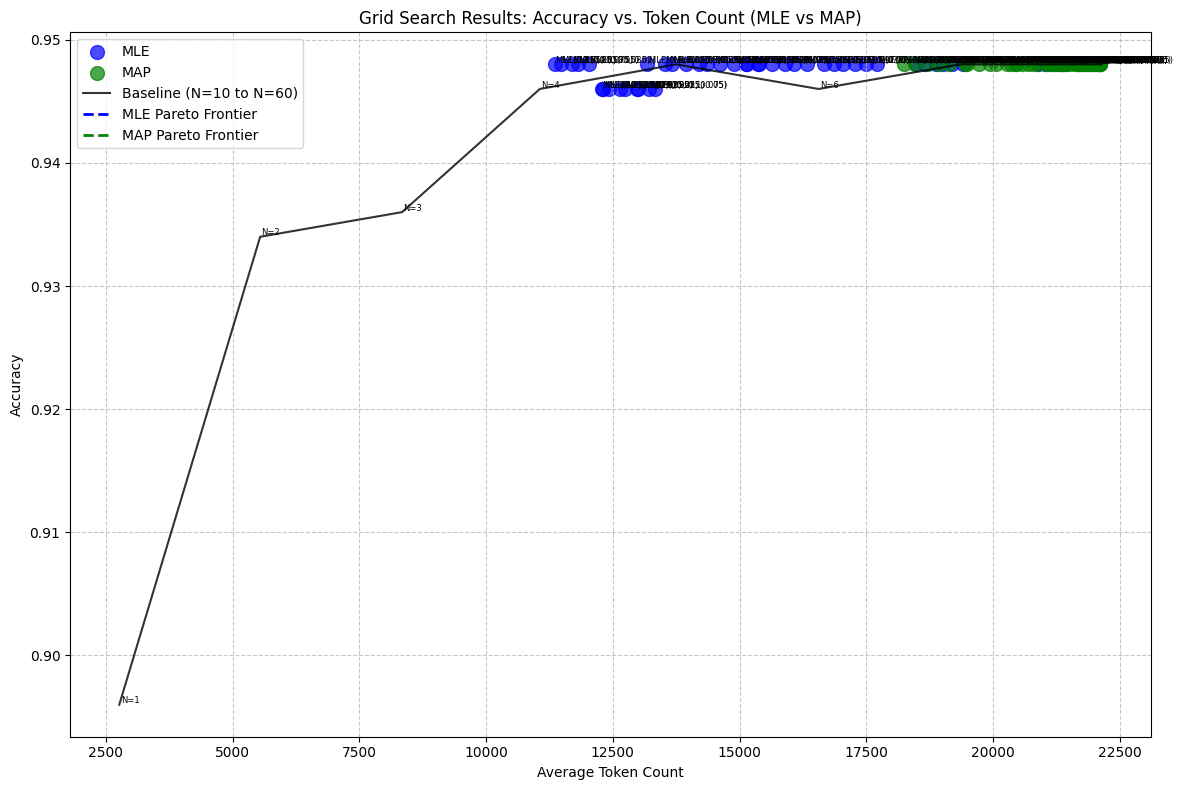


MLE Pareto-optimal configurations:
Target Score: 0.85, Percentile: 0.1, Accuracy: 0.9480, Avg Token Count: 11353.96

MAP Pareto-optimal configurations:
Target Score: 0.85, Percentile: 0.1, Accuracy: 0.9480, Avg Token Count: 18236.33


In [5]:
# Setting Panels
target_score_panel_values = [0.85, 0.9, 0.925, 0.95, 0.96, 0.97, 0.98, 0.99]
percentile_panel_values = [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
max_N_panel = 8
print("Target Score Panel:", target_score_panel_values)
print("Percentile Panel:", percentile_panel_values)
print("Max N:", max_N_panel)

# Evaluate MLE results
print("\nEvaluating MLE Results...")
truncated_normal_params_all = mle_estimated_params
mle_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MLE)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MLE Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MLE - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MLE - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        mle_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MLE_results_{max_N_panel}.json', 'w') as f:
    json.dump(mle_grid_search_results, f)


# Evaluate MAP results
print("\nEvaluating MAP Results...")
truncated_normal_params_all = map_estimated_params
map_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MAP)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MAP Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MAP - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MAP - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        map_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MAP_results_{max_N_panel}.json', 'w') as f:
    json.dump(map_grid_search_results, f)

plot_mle_map_optscale(mle_grid_search_results, map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel)

In [6]:
peek_number = 5

mle_estimated_params = []  # Store MLE estimates
map_estimated_params = []  # Store MAP estimates
predictor_params = []      # Store predictor's estimates

for i, (score, prediction) in enumerate(zip(val_scores, val_labels)):
    peek_data = np.array(score[0][:peek_number])
    
    # Store predictor's parameters
    prior_mu, prior_sigma = prediction
    predictor_params.append((prior_mu, prior_sigma))
    
    # MLE estimation with limited data
    initial_mu = np.mean(peek_data)
    initial_sigma = np.std(peek_data)
    mle_result = minimize(
        lambda params: neg_log_likelihood(params, peek_data),
        [initial_mu, initial_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    mle_mu, mle_sigma = mle_result.x
    mle_estimated_params.append((mle_mu, mle_sigma))
    
    # MAP estimation with limited data
    map_result = minimize(
        lambda params: neg_log_posterior(
            params, 
            peek_data, 
            prior_mu=prior_mu, 
            prior_sigma=prior_sigma
        ),
        [prior_mu, prior_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    map_mu, map_sigma = map_result.x
    map_estimated_params.append((map_mu, map_sigma))
    
    # Print comparison for first 50 examples
    if i < 50:
        gt_mu, gt_sigma = original_params_compare[i]
        print(f"{i:<4} {prior_mu:11.4f} {prior_sigma:11.4f} {mle_mu:9.4f} {mle_sigma:9.4f} "
              f"{map_mu:9.4f} {map_sigma:9.4f} {gt_mu:9.4f} {gt_sigma:9.4f}")

# Call the function to perform the analysis
analyze_estimation_performance(predictor_params, mle_estimated_params, map_estimated_params, original_params_compare)


0         0.6015      0.1227    0.9590    0.0074    0.8935    0.1145    0.9559    0.0145
1         0.4543      0.0766    0.9594    0.0119    0.9055    0.0937    0.9781    0.0432
2         0.6429      0.1356    1.0221    0.0496    0.8580    0.1435    0.9637    0.0222
3         0.4399      0.0769    0.9672    0.0111    0.9584    0.0146    0.9713    0.0204
4         0.4217      0.1085    0.9866    0.0078    0.7075    0.2396   30.9907    0.8595
5         0.4133      0.0200    0.9921    0.0028    1.0199    0.0410    1.1051    0.0412
6         0.5740      0.1303    0.9824    0.0368    0.9568    0.0321   41.5896    1.1720
7         0.5280      0.0904    0.9653    0.0119    0.9851    0.0693    0.9732    0.0181
8         0.4172      0.0738    0.9400    0.0105    0.9388    0.0107    0.9309    0.0216
9         0.5581      0.1733    0.9739    0.0102    0.8911    0.1271    1.0747    0.0605
10        0.4970      0.1497    1.3706    0.2833    0.7331    0.1854    1.6000    0.2797
11        0.3311     

Target Score Panel: [0.85, 0.9, 0.925, 0.95, 0.96, 0.97, 0.98, 0.99]
Percentile Panel: [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
Max N: 16

Evaluating MLE Results...


Target Score (MLE):   0%|          | 0/8 [00:00<?, ?it/s]

MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 7, 5, 5, 5, 5, 16, 5, 12, 5, 6, 16, 5, 16, 5, 5, 6, 5, 5, 5, 5, 8, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 11, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

MLE - Target Score: 0.85, Percentile: 0.01
MLE - Accuracy: 0.9460, Average Token Count: 19539.44
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 6, 5, 5, 5, 5, 16, 5, 10, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 9, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

MLE - Target Score: 0.85, Percentile: 0.02
MLE - Accuracy: 0.9460, Average Token Count: 19035.67
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 6, 5, 5, 5, 5, 16, 5, 9, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

MLE - Target Score: 0.85, Percentile: 0.035
MLE - Accuracy: 0.9480, Average Token Count: 18721.88
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 8, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 7, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

MLE - Target Score: 0.85, Percentile: 0.05
MLE - Accuracy: 0.9480, Average Token Count: 18529.11
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 7, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

MLE - Target Score: 0.85, Percentile: 0.075
MLE - Accuracy: 0.9500, Average Token Count: 18280.32
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 6, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

Target Score (MLE):  12%|█▎        | 1/8 [00:08<00:57,  8.27s/it]

MLE - Target Score: 0.85, Percentile: 0.1
MLE - Accuracy: 0.9520, Average Token Count: 18123.41


MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 9, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 16, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 14, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 11, 7, 5, 5, 5, 16, 5, 16, 5, 10, 16, 5, 16, 5, 5, 10, 5, 5, 5, 5, 12, 5, 5, 7, 5, 16, 9, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 6, 5, 16, 5, 5, 5, 5, 7, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5,

MLE - Target Score: 0.9, Percentile: 0.01
MLE - Accuracy: 0.9460, Average Token Count: 22184.48
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 10, 6, 5, 5, 5, 16, 5, 16, 5, 8, 16, 5, 16, 5, 5, 8, 5, 5, 5, 5, 11, 5, 5, 6, 5, 16, 8, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 15, 5, 5, 5, 5, 6, 5, 5, 5, 5, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

MLE - Target Score: 0.9, Percentile: 0.02
MLE - Accuracy: 0.9460, Average Token Count: 21461.21
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 8, 5, 5, 5, 5, 16, 5, 15, 5, 7, 16, 5, 16, 5, 5, 7, 5, 5, 5, 5, 9, 5, 5, 5, 5, 16, 7, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 14, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

MLE - Target Score: 0.9, Percentile: 0.035
MLE - Accuracy: 0.9440, Average Token Count: 20753.97
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 7, 5, 5, 5, 5, 16, 5, 13, 5, 7, 16, 5, 16, 5, 5, 7, 5, 5, 5, 5, 8, 5, 5, 5, 5, 16, 6, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 13, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

MLE - Target Score: 0.9, Percentile: 0.05
MLE - Accuracy: 0.9460, Average Token Count: 20342.30
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 15, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 7, 5, 5, 5, 5, 16, 5, 11, 5, 6, 16, 5, 16, 5, 5, 6, 5, 5, 5, 5, 7, 5, 5, 5, 5, 16, 6, 5, 5, 16, 5, 5, 5, 5, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 11, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

MLE - Target Score: 0.9, Percentile: 0.075
MLE - Accuracy: 0.9460, Average Token Count: 19891.63
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 6, 5, 5, 5, 5, 16, 5, 10, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 10, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

Target Score (MLE):  25%|██▌       | 2/8 [00:16<00:51,  8.53s/it]

MLE - Target Score: 0.9, Percentile: 0.1
MLE - Accuracy: 0.9460, Average Token Count: 19486.01


MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 12, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 10, 7, 5, 5, 5, 5, 5, 16, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 7, 5, 5, 5, 5, 5, 10, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 16, 5, 7, 15, 10, 5, 5, 5, 16, 5, 16, 5, 14, 16, 5, 16, 5, 5, 13, 5, 5, 5, 5, 16, 5, 5, 10, 5, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 9, 5, 16, 5, 5, 5, 5, 9, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 12, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 8, 

MLE - Target Score: 0.925, Percentile: 0.01
MLE - Accuracy: 0.9460, Average Token Count: 24006.23
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 10, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 8, 6, 5, 5, 5, 5, 5, 16, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 6, 5, 5, 5, 5, 5, 9, 16, 5, 5, 5, 5, 5, 5, 5, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 16, 5, 6, 13, 8, 5, 5, 5, 16, 5, 16, 5, 12, 16, 5, 16, 5, 5, 11, 5, 5, 5, 5, 15, 5, 5, 8, 5, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 8, 5, 16, 5, 5, 5, 5, 8, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

MLE - Target Score: 0.925, Percentile: 0.02
MLE - Accuracy: 0.9460, Average Token Count: 23216.49
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 9, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 16, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 8, 14, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 11, 7, 5, 5, 5, 16, 5, 16, 5, 10, 16, 5, 16, 5, 5, 10, 5, 5, 5, 5, 13, 5, 5, 7, 5, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 7, 5, 16, 5, 5, 5, 5, 7, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

MLE - Target Score: 0.925, Percentile: 0.035
MLE - Accuracy: 0.9460, Average Token Count: 22612.94
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 8, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 7, 13, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 10, 6, 5, 5, 5, 16, 5, 16, 5, 9, 16, 5, 16, 5, 5, 9, 5, 5, 5, 5, 12, 5, 5, 7, 5, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 6, 5, 16, 5, 5, 5, 5, 6, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

MLE - Target Score: 0.925, Percentile: 0.05
MLE - Accuracy: 0.9460, Average Token Count: 22182.79
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 7, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 6, 11, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 9, 6, 5, 5, 5, 16, 5, 16, 5, 8, 16, 5, 16, 5, 5, 8, 5, 5, 5, 5, 10, 5, 5, 6, 5, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

MLE - Target Score: 0.925, Percentile: 0.075
MLE - Accuracy: 0.9460, Average Token Count: 21651.63
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 8, 5, 5, 5, 5, 16, 5, 14, 5, 7, 16, 5, 16, 5, 5, 7, 5, 5, 5, 5, 9, 5, 5, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 14, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

Target Score (MLE):  38%|███▊      | 3/8 [00:26<00:44,  8.85s/it]

MLE - Target Score: 0.925, Percentile: 0.1
MLE - Accuracy: 0.9460, Average Token Count: 21143.95


MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 15, 5, 5, 5, 5, 5, 5, 16, 16, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 15, 5, 9, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 10, 5, 5, 5, 6, 5, 5, 14, 10, 5, 5, 5, 5, 5, 16, 6, 12, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 10, 8, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 6, 16, 5, 16, 16, 5, 11, 16, 15, 5, 7, 5, 16, 5, 16, 7, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 15, 5, 16, 16, 5, 5, 16, 5, 7, 5, 5, 16, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 8, 5, 5, 5, 16, 5, 10, 16, 5, 15, 5, 16, 5, 7, 5, 7, 14, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 6, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 9, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 8, 5, 5,

MLE - Target Score: 0.95, Percentile: 0.01
MLE - Accuracy: 0.9440, Average Token Count: 26842.47
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 12, 5, 5, 5, 5, 5, 5, 15, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 5, 8, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 12, 8, 5, 5, 5, 5, 5, 16, 5, 10, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 9, 7, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 15, 5, 5, 5, 5, 5, 16, 5, 16, 16, 5, 9, 16, 12, 5, 6, 5, 16, 5, 16, 6, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 13, 5, 16, 16, 5, 5, 16, 5, 6, 5, 5, 16, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 16, 5, 9, 16, 5, 13, 5, 16, 5, 6, 5, 6, 12, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 14, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 14, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 7, 5,

MLE - Target Score: 0.95, Percentile: 0.02
MLE - Accuracy: 0.9460, Average Token Count: 26080.40
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 11, 5, 5, 5, 5, 5, 5, 13, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 7, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 11, 7, 5, 5, 5, 5, 5, 16, 5, 9, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 8, 6, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 13, 5, 5, 5, 5, 5, 16, 5, 16, 16, 5, 8, 16, 11, 5, 5, 5, 16, 5, 16, 5, 16, 16, 5, 16, 5, 5, 15, 5, 5, 5, 5, 16, 5, 5, 11, 5, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 16, 5, 7, 16, 5, 11, 5, 16, 5, 5, 5, 5, 10, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 

MLE - Target Score: 0.95, Percentile: 0.035
MLE - Accuracy: 0.9460, Average Token Count: 25514.26
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 10, 5, 5, 5, 5, 5, 5, 12, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 6, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 10, 7, 5, 5, 5, 5, 5, 16, 5, 8, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 7, 6, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 12, 5, 5, 5, 5, 5, 15, 5, 16, 16, 5, 7, 15, 10, 5, 5, 5, 16, 5, 16, 5, 14, 16, 5, 16, 5, 5, 14, 5, 5, 5, 5, 16, 5, 5, 10, 5, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 16, 5, 7, 16, 5, 10, 5, 16, 5, 5, 5, 5, 9, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 

MLE - Target Score: 0.95, Percentile: 0.05
MLE - Accuracy: 0.9460, Average Token Count: 25039.86
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 15, 5, 8, 5, 5, 5, 5, 5, 5, 10, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 8, 6, 5, 5, 5, 5, 5, 16, 5, 7, 5, 5, 5, 5, 5, 5, 5, 16, 14, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 6, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 10, 5, 5, 5, 5, 5, 13, 5, 16, 16, 5, 6, 13, 8, 5, 5, 5, 16, 5, 16, 5, 13, 16, 5, 16, 5, 5, 12, 5, 5, 5, 5, 16, 5, 5, 9, 5, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 6, 16, 5, 9, 5, 16, 5, 5, 5, 5, 8, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

MLE - Target Score: 0.95, Percentile: 0.075
MLE - Accuracy: 0.9460, Average Token Count: 24277.11
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 14, 5, 8, 5, 5, 5, 5, 5, 5, 9, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 16, 5, 6, 5, 5, 5, 5, 5, 5, 5, 16, 13, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 15, 5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 9, 5, 5, 5, 5, 5, 12, 5, 16, 16, 5, 6, 12, 8, 5, 5, 5, 16, 5, 16, 5, 11, 16, 5, 16, 5, 5, 11, 5, 5, 5, 5, 14, 5, 5, 8, 5, 16, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 8, 5, 16, 5, 5, 5, 5, 7, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

Target Score (MLE):  50%|█████     | 4/8 [00:36<00:37,  9.34s/it]

MLE - Target Score: 0.95, Percentile: 0.1
MLE - Accuracy: 0.9460, Average Token Count: 23696.44


MLE Min N Required [9, 8, 5, 5, 5, 5, 6, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 7, 5, 5, 6, 5, 6, 5, 5, 5, 5, 8, 5, 5, 16, 5, 11, 16, 5, 5, 5, 5, 5, 7, 5, 5, 6, 10, 5, 5, 5, 6, 12, 5, 5, 5, 9, 7, 5, 16, 12, 5, 5, 5, 5, 5, 16, 8, 15, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 16, 13, 13, 16, 5, 5, 5, 5, 16, 16, 9, 5, 5, 5, 5, 5, 6, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 7, 16, 5, 16, 16, 5, 13, 16, 16, 5, 14, 5, 16, 5, 16, 10, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 6, 16, 16, 5, 5, 16, 5, 16, 5, 5, 16, 5, 5, 10, 5, 6, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 16, 5, 5, 14, 16, 5, 16, 16, 5, 16, 5, 16, 5, 10, 5, 8, 16, 5, 5, 5, 5, 16, 5, 6, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 16, 5, 7, 5, 6, 5, 5, 16, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 10, 5, 5, 11, 5, 8, 5, 5, 6, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 

MLE - Target Score: 0.96, Percentile: 0.01
MLE - Accuracy: 0.9440, Average Token Count: 28721.15
MLE Min N Required [8, 7, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 16, 5, 9, 16, 5, 5, 5, 5, 5, 6, 5, 5, 5, 8, 5, 5, 5, 5, 11, 5, 5, 5, 8, 6, 5, 15, 11, 5, 5, 5, 5, 5, 16, 7, 13, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 16, 11, 11, 16, 5, 5, 5, 5, 16, 16, 8, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 6, 16, 5, 16, 16, 5, 11, 16, 16, 5, 12, 5, 16, 5, 16, 9, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 5, 16, 16, 5, 5, 16, 5, 16, 5, 5, 16, 5, 5, 9, 5, 6, 5, 5, 5, 7, 5, 5, 5, 5, 7, 5, 5, 16, 5, 5, 12, 16, 5, 16, 16, 5, 16, 5, 16, 5, 9, 5, 7, 15, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 16, 5, 6, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 9,

MLE - Target Score: 0.96, Percentile: 0.02
MLE - Accuracy: 0.9440, Average Token Count: 27979.74
MLE Min N Required [7, 6, 5, 5, 5, 5, 5, 5, 16, 5, 13, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 16, 5, 8, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 9, 5, 5, 5, 7, 5, 5, 13, 9, 5, 5, 5, 5, 5, 16, 6, 11, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 9, 9, 14, 5, 5, 5, 5, 16, 16, 7, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 16, 5, 10, 16, 13, 5, 11, 5, 16, 5, 16, 7, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 14, 5, 16, 16, 5, 5, 16, 5, 16, 5, 5, 16, 5, 5, 8, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 15, 5, 5, 10, 16, 5, 16, 16, 5, 14, 5, 16, 5, 8, 5, 6, 13, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 15, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 

MLE - Target Score: 0.96, Percentile: 0.035
MLE - Accuracy: 0.9440, Average Token Count: 27260.38
MLE Min N Required [6, 5, 5, 5, 5, 5, 5, 5, 16, 5, 12, 5, 5, 5, 5, 5, 5, 14, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 16, 5, 7, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 8, 5, 5, 5, 6, 5, 5, 12, 8, 5, 5, 5, 5, 5, 16, 5, 10, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 8, 8, 13, 5, 5, 5, 5, 16, 16, 6, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 16, 5, 9, 16, 12, 5, 10, 5, 16, 5, 16, 7, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 12, 5, 16, 16, 5, 5, 16, 5, 16, 5, 5, 16, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 13, 5, 5, 9, 16, 5, 16, 16, 5, 13, 5, 16, 5, 7, 5, 6, 11, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 14, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5

MLE - Target Score: 0.96, Percentile: 0.05
MLE - Accuracy: 0.9460, Average Token Count: 26815.92
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 10, 5, 5, 5, 5, 5, 5, 13, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 6, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 10, 7, 5, 5, 5, 5, 5, 16, 5, 8, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 7, 7, 11, 5, 5, 5, 5, 16, 16, 6, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 16, 5, 8, 16, 11, 5, 8, 5, 16, 5, 16, 6, 16, 16, 5, 16, 5, 5, 15, 5, 5, 5, 5, 16, 5, 5, 11, 5, 16, 16, 5, 5, 16, 5, 16, 5, 5, 16, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 8, 16, 5, 16, 16, 5, 11, 5, 16, 5, 6, 5, 5, 10, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 15, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 6

MLE - Target Score: 0.96, Percentile: 0.075
MLE - Accuracy: 0.9460, Average Token Count: 26192.39
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 9, 5, 5, 5, 5, 5, 5, 11, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 15, 5, 6, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 9, 6, 5, 5, 5, 5, 5, 16, 5, 8, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 7, 7, 10, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 16, 5, 7, 14, 9, 5, 7, 5, 16, 5, 16, 5, 14, 16, 5, 16, 5, 5, 13, 5, 5, 5, 5, 16, 5, 5, 10, 5, 16, 16, 5, 5, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 7, 16, 5, 15, 16, 5, 10, 5, 16, 5, 5, 5, 5, 9, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 14, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5

Target Score (MLE):  62%|██████▎   | 5/8 [00:47<00:29,  9.88s/it]

MLE - Target Score: 0.96, Percentile: 0.1
MLE - Accuracy: 0.9460, Average Token Count: 25639.99


MLE Min N Required [16, 16, 6, 10, 5, 5, 8, 12, 16, 5, 16, 5, 5, 5, 15, 5, 5, 16, 16, 9, 5, 5, 8, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 5, 15, 16, 5, 5, 6, 10, 5, 15, 5, 5, 16, 13, 6, 5, 5, 16, 16, 5, 5, 5, 16, 16, 5, 16, 16, 10, 5, 6, 5, 8, 16, 10, 16, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 6, 9, 5, 5, 5, 16, 16, 16, 16, 5, 7, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 10, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 8, 6, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 9, 16, 11, 16, 16, 5, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 8, 5, 16, 16, 16, 16, 5, 5, 16, 5, 16, 12, 5, 16, 5, 5, 13, 9, 9, 6, 5, 5, 16, 5, 5, 5, 5, 14, 5, 5, 16, 5, 5, 16, 16, 5, 16, 16, 7, 16, 5, 16, 8, 16, 5, 11, 16, 5, 10, 5, 8, 16, 5, 8, 5, 5, 14, 16, 5, 5, 7, 5, 16, 5, 16, 5, 5, 5, 16, 5, 9, 5, 11, 5, 5, 16, 5, 5, 5, 5, 5, 5, 8, 5, 14, 5, 5, 5, 5, 5, 6, 5, 5, 10, 5, 5, 5, 5, 5, 15, 5, 6, 16, 5, 5, 14, 5, 11, 5, 5, 7, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5,

MLE - Target Score: 0.97, Percentile: 0.01
MLE - Accuracy: 0.9400, Average Token Count: 31970.94
MLE Min N Required [16, 16, 5, 9, 5, 5, 7, 10, 16, 5, 16, 5, 5, 5, 13, 5, 5, 16, 16, 8, 5, 5, 7, 5, 14, 5, 5, 5, 5, 16, 5, 5, 16, 5, 13, 16, 5, 5, 5, 8, 5, 13, 5, 5, 13, 11, 5, 5, 5, 16, 14, 5, 5, 5, 14, 15, 5, 16, 14, 9, 5, 5, 5, 7, 16, 9, 16, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 16, 16, 14, 16, 5, 6, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 9, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 7, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 8, 16, 9, 16, 16, 5, 15, 16, 16, 5, 16, 5, 16, 16, 16, 13, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 7, 5, 16, 16, 16, 16, 5, 5, 16, 5, 16, 10, 5, 16, 5, 5, 11, 8, 8, 5, 5, 5, 16, 5, 5, 5, 5, 12, 5, 5, 16, 5, 5, 16, 16, 5, 16, 16, 6, 16, 5, 16, 7, 13, 5, 9, 16, 5, 8, 5, 7, 16, 5, 7, 5, 5, 12, 16, 5, 5, 6, 5, 16, 5, 16, 5, 5, 5, 16, 5, 8, 5, 10, 5, 5, 16, 5, 5, 5, 5, 5, 5, 7, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 8, 

MLE - Target Score: 0.97, Percentile: 0.02
MLE - Accuracy: 0.9400, Average Token Count: 31087.56
MLE Min N Required [16, 16, 5, 7, 5, 5, 6, 9, 16, 5, 16, 5, 5, 5, 11, 5, 5, 16, 16, 7, 5, 5, 6, 5, 12, 5, 5, 5, 5, 16, 5, 5, 16, 5, 11, 16, 5, 5, 5, 7, 5, 11, 5, 5, 12, 10, 5, 5, 5, 16, 12, 5, 5, 5, 12, 13, 5, 16, 12, 7, 5, 5, 5, 6, 16, 7, 14, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 16, 16, 12, 16, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 8, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 6, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 7, 16, 8, 16, 16, 5, 13, 16, 16, 5, 16, 5, 16, 16, 16, 12, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 6, 5, 16, 14, 16, 16, 5, 5, 16, 5, 16, 9, 5, 16, 5, 5, 10, 7, 7, 5, 5, 5, 16, 5, 5, 5, 5, 10, 5, 5, 16, 5, 5, 16, 16, 5, 16, 16, 5, 16, 5, 16, 6, 11, 5, 8, 16, 5, 7, 5, 6, 16, 5, 6, 5, 5, 10, 16, 5, 5, 6, 5, 16, 5, 16, 5, 5, 5, 16, 5, 7, 5, 8, 5, 5, 16, 5, 5, 5, 5, 5, 5, 6, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5

MLE - Target Score: 0.97, Percentile: 0.035
MLE - Accuracy: 0.9400, Average Token Count: 30221.64
MLE Min N Required [16, 16, 5, 7, 5, 5, 5, 8, 16, 5, 16, 5, 5, 5, 10, 5, 5, 16, 16, 6, 5, 5, 6, 5, 11, 5, 5, 5, 5, 16, 5, 5, 16, 5, 10, 16, 5, 5, 5, 7, 5, 10, 5, 5, 10, 9, 5, 5, 5, 16, 11, 5, 5, 5, 11, 12, 5, 16, 11, 7, 5, 5, 5, 5, 16, 7, 13, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 16, 16, 11, 16, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 7, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 6, 16, 7, 16, 16, 5, 12, 16, 16, 5, 16, 5, 16, 16, 16, 10, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 12, 16, 16, 5, 5, 16, 5, 16, 8, 5, 16, 5, 5, 9, 6, 6, 5, 5, 5, 16, 5, 5, 5, 5, 9, 5, 5, 16, 5, 5, 16, 16, 5, 16, 16, 5, 16, 5, 16, 5, 10, 5, 7, 15, 5, 7, 5, 6, 16, 5, 5, 5, 5, 9, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 16, 5, 6, 5, 8, 5, 5, 16, 5, 5, 5, 5, 5, 5, 6, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5

MLE - Target Score: 0.97, Percentile: 0.05
MLE - Accuracy: 0.9420, Average Token Count: 29619.14
MLE Min N Required [16, 14, 5, 6, 5, 5, 5, 7, 16, 5, 14, 5, 5, 5, 9, 5, 5, 16, 16, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 15, 5, 5, 16, 5, 8, 16, 5, 5, 5, 6, 5, 9, 5, 5, 9, 7, 5, 5, 5, 16, 9, 5, 5, 5, 9, 10, 5, 14, 9, 6, 5, 5, 5, 5, 16, 6, 11, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 10, 16, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 6, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 16, 6, 16, 16, 5, 10, 16, 14, 5, 16, 5, 16, 16, 16, 9, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 14, 11, 16, 16, 5, 5, 16, 5, 16, 7, 5, 16, 5, 5, 8, 5, 5, 5, 5, 5, 15, 5, 5, 5, 5, 8, 5, 5, 16, 5, 5, 16, 16, 5, 16, 16, 5, 16, 5, 16, 5, 9, 5, 6, 13, 5, 6, 5, 5, 16, 5, 5, 5, 5, 8, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 16, 5, 6, 5, 7, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 9, 5

MLE - Target Score: 0.97, Percentile: 0.075
MLE - Accuracy: 0.9440, Average Token Count: 28908.87
MLE Min N Required [16, 12, 5, 5, 5, 5, 5, 6, 16, 5, 12, 5, 5, 5, 8, 5, 5, 15, 16, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 13, 5, 5, 16, 5, 8, 16, 5, 5, 5, 5, 5, 8, 5, 5, 8, 7, 5, 5, 5, 16, 8, 5, 5, 5, 8, 9, 5, 12, 8, 5, 5, 5, 5, 5, 16, 5, 10, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 9, 16, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 16, 6, 16, 16, 5, 9, 16, 13, 5, 16, 5, 16, 16, 16, 8, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 13, 10, 16, 16, 5, 5, 16, 5, 16, 6, 5, 16, 5, 5, 7, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 7, 5, 5, 16, 5, 5, 16, 16, 5, 16, 16, 5, 14, 5, 16, 5, 8, 5, 6, 12, 5, 5, 5, 5, 16, 5, 5, 5, 5, 7, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 15, 5, 5, 5, 6, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 

Target Score (MLE):  75%|███████▌  | 6/8 [00:59<00:21, 10.62s/it]

MLE - Target Score: 0.97, Percentile: 0.1
MLE - Accuracy: 0.9460, Average Token Count: 28272.74


MLE Min N Required [16, 16, 10, 16, 5, 5, 13, 16, 16, 16, 16, 5, 9, 16, 16, 5, 5, 16, 16, 14, 5, 5, 12, 5, 16, 5, 7, 7, 5, 16, 16, 8, 16, 5, 16, 16, 5, 5, 9, 16, 5, 16, 5, 16, 16, 16, 13, 7, 5, 16, 16, 5, 12, 5, 16, 16, 5, 16, 16, 16, 10, 16, 6, 13, 16, 15, 16, 5, 6, 5, 16, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 9, 5, 16, 13, 5, 5, 5, 16, 16, 16, 16, 5, 11, 6, 5, 16, 16, 16, 5, 5, 5, 5, 7, 16, 16, 5, 5, 5, 6, 5, 9, 5, 6, 14, 7, 5, 16, 5, 16, 5, 5, 5, 15, 8, 6, 5, 5, 16, 5, 5, 7, 5, 5, 5, 5, 16, 5, 11, 16, 5, 5, 5, 9, 13, 16, 16, 16, 16, 5, 16, 16, 16, 9, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 5, 7, 16, 5, 5, 5, 5, 16, 16, 5, 16, 16, 16, 16, 5, 7, 16, 5, 16, 16, 5, 16, 7, 9, 16, 16, 14, 10, 5, 5, 16, 5, 5, 5, 7, 16, 5, 9, 16, 5, 5, 16, 16, 15, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 12, 5, 9, 16, 16, 5, 5, 13, 15, 16, 5, 16, 5, 7, 5, 16, 5, 14, 5, 16, 5, 5, 16, 5, 5, 5, 16, 5, 5, 13, 5, 16, 5, 5, 5, 5, 9, 9, 9, 5, 16, 5, 5, 5, 12, 5, 16, 5, 9, 16, 5, 5, 16, 5, 16, 5, 9

MLE - Target Score: 0.98, Percentile: 0.01
MLE - Accuracy: 0.9400, Average Token Count: 35921.96
MLE Min N Required [16, 16, 8, 16, 5, 5, 11, 16, 16, 14, 16, 5, 8, 16, 16, 5, 5, 16, 16, 12, 5, 5, 11, 5, 16, 5, 6, 6, 5, 16, 16, 7, 16, 5, 16, 16, 5, 5, 8, 16, 5, 16, 5, 14, 16, 16, 11, 6, 5, 16, 16, 5, 11, 5, 16, 16, 5, 16, 16, 16, 9, 14, 5, 11, 16, 13, 16, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 8, 5, 16, 11, 5, 5, 5, 16, 16, 16, 16, 5, 9, 5, 5, 16, 16, 16, 5, 5, 5, 5, 6, 16, 16, 5, 5, 5, 5, 5, 8, 5, 5, 12, 6, 5, 16, 5, 16, 5, 5, 5, 13, 7, 5, 5, 5, 16, 5, 5, 6, 5, 5, 5, 5, 16, 5, 9, 16, 5, 5, 5, 7, 11, 16, 16, 16, 16, 5, 16, 16, 16, 8, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 5, 6, 16, 5, 5, 5, 5, 16, 16, 5, 16, 16, 16, 16, 5, 6, 16, 5, 16, 16, 5, 16, 6, 8, 16, 16, 12, 9, 5, 5, 16, 5, 5, 5, 6, 16, 5, 8, 16, 5, 5, 16, 16, 13, 16, 16, 16, 16, 5, 16, 16, 16, 5, 14, 16, 5, 16, 13, 16, 16, 14, 10, 5, 8, 16, 16, 5, 5, 11, 13, 16, 5, 16, 5, 6, 5, 16, 5, 12, 5, 16, 5, 5, 16, 5, 5, 5, 14, 5, 5

MLE - Target Score: 0.98, Percentile: 0.02
MLE - Accuracy: 0.9400, Average Token Count: 35119.80
MLE Min N Required [16, 16, 7, 16, 5, 5, 10, 16, 16, 12, 16, 5, 7, 16, 16, 5, 5, 16, 16, 10, 5, 5, 9, 5, 16, 5, 5, 5, 5, 16, 16, 6, 16, 5, 16, 16, 5, 5, 7, 16, 5, 16, 5, 12, 16, 14, 9, 5, 5, 16, 16, 5, 9, 5, 16, 16, 5, 16, 16, 16, 7, 12, 5, 10, 16, 11, 16, 5, 5, 5, 15, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 7, 5, 16, 10, 5, 5, 5, 16, 16, 16, 16, 5, 8, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 7, 5, 5, 10, 5, 5, 16, 5, 16, 5, 5, 5, 11, 6, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 8, 16, 5, 5, 5, 6, 10, 16, 16, 16, 16, 5, 16, 16, 16, 7, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 5, 6, 16, 5, 5, 5, 5, 16, 16, 5, 16, 16, 16, 16, 5, 6, 16, 5, 16, 16, 5, 16, 5, 7, 15, 16, 11, 8, 5, 5, 16, 5, 5, 5, 5, 16, 5, 7, 16, 5, 5, 16, 16, 11, 16, 16, 16, 16, 5, 16, 16, 16, 5, 12, 16, 5, 16, 12, 16, 16, 12, 9, 5, 7, 16, 16, 5, 5, 9, 11, 16, 5, 16, 5, 5, 5, 16, 5, 10, 5, 16, 5, 5, 16, 5, 5, 5, 12, 5, 5, 10,

MLE - Target Score: 0.98, Percentile: 0.035
MLE - Accuracy: 0.9400, Average Token Count: 34346.41
MLE Min N Required [16, 16, 6, 16, 5, 5, 9, 16, 16, 11, 16, 5, 6, 16, 16, 5, 5, 16, 16, 9, 5, 5, 8, 5, 16, 5, 5, 5, 5, 16, 14, 5, 16, 5, 14, 16, 5, 5, 6, 16, 5, 16, 5, 11, 16, 13, 8, 5, 5, 16, 16, 5, 8, 5, 16, 16, 5, 16, 16, 16, 7, 11, 5, 9, 16, 10, 16, 5, 5, 5, 13, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 6, 5, 16, 9, 5, 5, 5, 16, 16, 16, 16, 5, 7, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 15, 16, 5, 5, 5, 5, 5, 6, 5, 5, 9, 5, 5, 16, 5, 16, 5, 5, 5, 10, 6, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 7, 16, 5, 5, 5, 6, 9, 16, 16, 16, 16, 5, 16, 16, 16, 6, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 5, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 5, 16, 5, 6, 13, 16, 10, 7, 5, 5, 16, 5, 5, 5, 5, 16, 5, 6, 16, 5, 5, 16, 16, 10, 16, 16, 16, 16, 5, 16, 16, 16, 5, 11, 16, 5, 16, 10, 16, 16, 11, 8, 5, 6, 16, 16, 5, 5, 8, 10, 16, 5, 16, 5, 5, 5, 16, 5, 9, 5, 16, 5, 5, 16, 5, 5, 5, 11, 5, 5, 9, 5, 16,

MLE - Target Score: 0.98, Percentile: 0.05
MLE - Accuracy: 0.9400, Average Token Count: 33734.62
MLE Min N Required [16, 16, 6, 16, 5, 5, 8, 16, 16, 9, 16, 5, 6, 15, 16, 5, 5, 16, 16, 8, 5, 5, 7, 5, 16, 5, 5, 5, 5, 16, 12, 5, 16, 5, 12, 16, 5, 5, 5, 16, 5, 16, 5, 9, 16, 11, 7, 5, 5, 16, 14, 5, 7, 5, 16, 16, 5, 16, 14, 16, 6, 9, 5, 8, 16, 9, 16, 5, 5, 5, 12, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 14, 8, 5, 5, 5, 16, 16, 14, 16, 5, 6, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 13, 16, 5, 5, 5, 5, 5, 6, 5, 5, 8, 5, 5, 16, 5, 16, 5, 5, 5, 9, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 6, 16, 5, 5, 5, 5, 8, 16, 16, 16, 16, 5, 15, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 5, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 5, 16, 5, 5, 11, 15, 8, 6, 5, 5, 16, 5, 5, 5, 5, 15, 5, 5, 16, 5, 5, 16, 16, 9, 16, 16, 16, 16, 5, 16, 16, 16, 5, 9, 16, 5, 16, 9, 15, 16, 9, 7, 5, 6, 16, 16, 5, 5, 7, 9, 16, 5, 16, 5, 5, 5, 16, 5, 8, 5, 15, 5, 5, 16, 5, 5, 5, 10, 5, 5, 8, 5, 16, 5, 5, 5, 5,

MLE - Target Score: 0.98, Percentile: 0.075
MLE - Accuracy: 0.9400, Average Token Count: 32981.78
MLE Min N Required [16, 16, 5, 16, 5, 5, 7, 16, 16, 8, 16, 5, 5, 14, 16, 5, 5, 16, 16, 7, 5, 5, 6, 5, 16, 5, 5, 5, 5, 16, 11, 5, 16, 5, 11, 16, 5, 5, 5, 16, 5, 16, 5, 8, 16, 10, 7, 5, 5, 16, 12, 5, 7, 5, 16, 16, 5, 16, 12, 16, 5, 8, 5, 7, 16, 8, 15, 5, 5, 5, 10, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 13, 7, 5, 5, 5, 16, 16, 13, 16, 5, 6, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 12, 16, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 16, 5, 16, 5, 5, 5, 8, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 6, 16, 5, 5, 5, 5, 7, 16, 15, 16, 16, 5, 14, 16, 16, 5, 16, 5, 16, 16, 16, 14, 16, 16, 5, 16, 5, 5, 16, 5, 5, 5, 5, 16, 16, 5, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 5, 16, 5, 5, 10, 13, 7, 5, 5, 5, 16, 5, 5, 5, 5, 13, 5, 5, 16, 5, 5, 16, 16, 8, 16, 16, 16, 16, 5, 16, 16, 14, 5, 8, 16, 5, 16, 8, 14, 16, 8, 6, 5, 5, 16, 16, 5, 5, 7, 8, 16, 5, 16, 5, 5, 5, 16, 5, 7, 5, 14, 5, 5, 16, 5, 5, 5, 9, 5, 5, 7, 5, 16, 5, 5, 5, 5,

Target Score (MLE):  88%|████████▊ | 7/8 [01:13<00:11, 11.91s/it]

MLE - Target Score: 0.98, Percentile: 0.1
MLE - Accuracy: 0.9400, Average Token Count: 32360.35


MLE Min N Required [16, 16, 16, 16, 14, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 14, 16, 8, 16, 16, 16, 16, 5, 16, 16, 16, 7, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 8, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 5, 11, 5, 16, 5, 5, 5, 16, 16, 16, 9, 5, 16, 5, 16, 5, 16, 16, 5, 5, 5, 16, 16, 16, 16, 8, 16, 16, 6, 16, 16, 16, 7, 5, 5, 10, 13, 16, 16, 5, 5, 7, 12, 6, 16, 16, 16, 16, 13, 5, 16, 5, 16, 5, 8, 5, 16, 16, 16, 5, 5, 16, 13, 6, 14, 5, 5, 5, 7, 16, 5, 16, 16, 12, 5, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 8, 16, 16, 9, 16, 10, 5, 16, 16, 10, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 5, 9, 16, 16, 16, 7, 16, 16, 10, 8, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 9, 16, 16, 16, 8, 16, 5, 16, 14, 16, 12, 16, 5, 16, 7, 5, 16, 9, 8, 9, 16, 12, 8, 16, 5, 16, 5, 11, 6, 5, 16, 16, 16, 

MLE - Target Score: 0.99, Percentile: 0.01
MLE - Accuracy: 0.9380, Average Token Count: 41029.57
MLE Min N Required [16, 16, 16, 16, 12, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 12, 16, 7, 16, 16, 16, 16, 5, 16, 16, 16, 6, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 7, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 5, 10, 5, 16, 5, 5, 5, 16, 16, 16, 8, 5, 16, 5, 16, 5, 16, 16, 5, 5, 5, 16, 16, 16, 16, 7, 16, 16, 5, 16, 16, 16, 6, 5, 5, 9, 11, 16, 16, 5, 5, 6, 10, 5, 16, 16, 16, 16, 11, 5, 16, 5, 16, 5, 7, 5, 16, 14, 14, 5, 5, 16, 11, 5, 12, 5, 5, 5, 6, 16, 5, 16, 16, 10, 5, 5, 15, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 7, 16, 16, 7, 16, 9, 5, 16, 16, 8, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 15, 16, 5, 8, 16, 16, 16, 6, 16, 16, 9, 7, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 7, 16, 16, 16, 7, 16, 5, 

MLE - Target Score: 0.99, Percentile: 0.02
MLE - Accuracy: 0.9380, Average Token Count: 40578.72
MLE Min N Required [16, 16, 15, 16, 11, 5, 16, 16, 16, 16, 16, 15, 16, 16, 16, 12, 14, 16, 16, 16, 16, 5, 16, 16, 16, 5, 11, 16, 6, 16, 16, 15, 16, 5, 16, 16, 16, 5, 14, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 6, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 5, 8, 5, 16, 5, 5, 5, 16, 16, 16, 7, 5, 16, 5, 16, 5, 16, 16, 5, 5, 5, 16, 16, 16, 16, 6, 16, 16, 5, 16, 16, 16, 6, 5, 5, 8, 10, 16, 16, 5, 5, 5, 9, 5, 16, 16, 16, 16, 10, 5, 16, 5, 16, 5, 6, 5, 16, 12, 12, 5, 5, 16, 9, 5, 10, 5, 5, 5, 5, 16, 5, 16, 16, 9, 5, 5, 13, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 6, 16, 16, 6, 16, 8, 5, 16, 16, 7, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 13, 16, 5, 7, 16, 16, 16, 5, 16, 16, 8, 6, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 6, 16, 16, 16, 6, 16, 5, 16, 1

MLE - Target Score: 0.99, Percentile: 0.035
MLE - Accuracy: 0.9380, Average Token Count: 40117.90
MLE Min N Required [16, 16, 13, 16, 10, 5, 16, 16, 16, 16, 16, 13, 16, 16, 16, 11, 12, 16, 16, 16, 16, 5, 16, 16, 16, 5, 10, 16, 6, 16, 16, 14, 16, 5, 16, 16, 16, 5, 12, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 5, 8, 5, 16, 5, 5, 5, 16, 16, 16, 6, 5, 16, 5, 16, 5, 16, 16, 5, 5, 5, 16, 16, 16, 16, 6, 15, 16, 5, 16, 16, 16, 5, 5, 5, 7, 9, 16, 16, 5, 5, 5, 8, 5, 16, 16, 16, 16, 9, 5, 16, 5, 16, 5, 5, 5, 16, 11, 11, 5, 5, 16, 8, 5, 9, 5, 5, 5, 5, 16, 5, 16, 16, 8, 5, 5, 12, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 6, 16, 7, 5, 16, 16, 7, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 14, 5, 12, 16, 5, 6, 16, 16, 16, 5, 16, 16, 7, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 5, 16, 16, 16, 14, 6, 16, 16, 16, 5, 16, 5, 16, 9, 

MLE - Target Score: 0.99, Percentile: 0.05
MLE - Accuracy: 0.9380, Average Token Count: 39682.83
MLE Min N Required [16, 16, 11, 16, 8, 5, 16, 16, 16, 16, 16, 11, 16, 16, 16, 9, 11, 16, 16, 16, 16, 5, 14, 16, 16, 5, 8, 16, 5, 16, 16, 12, 16, 5, 16, 16, 16, 5, 11, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 5, 7, 5, 16, 5, 5, 5, 16, 16, 16, 5, 5, 16, 5, 16, 5, 16, 16, 5, 5, 5, 16, 16, 16, 16, 5, 13, 16, 5, 16, 16, 16, 5, 5, 5, 6, 8, 16, 16, 5, 5, 5, 7, 5, 14, 16, 16, 16, 8, 5, 16, 5, 16, 5, 5, 5, 16, 9, 9, 5, 5, 16, 7, 5, 8, 5, 5, 5, 5, 16, 5, 16, 16, 7, 5, 5, 10, 15, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 5, 14, 16, 5, 16, 6, 5, 16, 16, 6, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 13, 5, 10, 16, 5, 5, 16, 16, 16, 5, 16, 16, 6, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 5, 16, 16, 16, 12, 5, 16, 16, 16, 5, 16, 5, 16, 8, 16, 7,

MLE - Target Score: 0.99, Percentile: 0.075
MLE - Accuracy: 0.9380, Average Token Count: 39197.87
MLE Min N Required [16, 16, 10, 16, 7, 5, 15, 16, 16, 16, 16, 9, 15, 16, 16, 8, 10, 16, 16, 14, 16, 5, 13, 15, 16, 5, 7, 16, 5, 16, 16, 11, 16, 5, 16, 16, 16, 5, 10, 16, 5, 16, 14, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 6, 15, 16, 15, 16, 5, 6, 5, 16, 5, 5, 5, 16, 16, 16, 5, 5, 16, 5, 16, 5, 16, 14, 5, 5, 5, 16, 16, 16, 16, 5, 11, 16, 5, 16, 16, 16, 5, 5, 5, 5, 7, 16, 16, 5, 5, 5, 6, 5, 13, 16, 16, 16, 7, 5, 16, 5, 16, 5, 5, 5, 16, 8, 8, 5, 5, 16, 7, 5, 7, 5, 5, 5, 5, 16, 5, 16, 16, 6, 5, 5, 9, 13, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 5, 13, 16, 5, 16, 5, 5, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 11, 5, 9, 16, 5, 5, 16, 16, 16, 5, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 5, 16, 16, 16, 11, 5, 15, 16, 16, 5, 16, 5, 16, 7, 16, 6, 1

Target Score (MLE): 100%|██████████| 8/8 [01:32<00:00, 11.57s/it]


MLE - Target Score: 0.99, Percentile: 0.1
MLE - Accuracy: 0.9380, Average Token Count: 38763.79

Evaluating MAP Results...


Target Score (MAP):   0%|          | 0/8 [00:00<?, ?it/s]

MAP Min N Required [6, 5, 9, 5, 16, 5, 5, 5, 5, 7, 16, 16, 7, 5, 16, 16, 16, 16, 16, 13, 10, 5, 16, 7, 5, 16, 9, 5, 5, 5, 5, 7, 11, 5, 12, 12, 6, 5, 10, 5, 16, 5, 7, 5, 16, 16, 5, 5, 5, 5, 10, 16, 8, 16, 6, 5, 5, 16, 16, 5, 5, 5, 5, 7, 16, 16, 7, 16, 16, 10, 8, 6, 16, 5, 5, 5, 16, 16, 16, 5, 5, 5, 7, 5, 5, 16, 7, 5, 16, 5, 9, 5, 16, 5, 16, 12, 5, 16, 5, 7, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 5, 5, 7, 16, 5, 10, 16, 6, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 11, 7, 5, 6, 16, 16, 16, 5, 5, 9, 16, 16, 7, 8, 5, 5, 5, 16, 5, 5, 15, 9, 5, 5, 5, 16, 5, 16, 5, 10, 16, 5, 16, 13, 5, 11, 5, 5, 5, 7, 15, 9, 5, 9, 5, 16, 5, 8, 5, 16, 16, 5, 13, 5, 14, 5, 5, 16, 5, 16, 16, 5, 5, 16, 15, 5, 9, 5, 16, 5, 5, 5, 16, 8, 5, 16, 10, 5, 13, 14, 10, 5, 14, 5, 5, 5, 10, 16, 8, 10, 13, 10, 15, 5, 6, 5, 5, 16, 5, 5, 16, 5, 8, 5, 11, 16, 5, 12, 7, 7, 14, 16, 16, 5, 5, 16, 5, 5, 16, 16, 5, 16, 5, 5, 16, 5, 9, 6, 16, 16, 15, 5, 9, 16, 5, 16, 16, 5, 5, 16, 5, 6, 5, 5, 16, 16, 5, 5, 8, 5, 5, 5, 5, 12, 5, 5, 

MAP - Target Score: 0.85, Percentile: 0.01
MAP - Accuracy: 0.9420, Average Token Count: 28589.07
MAP Min N Required [5, 5, 7, 5, 16, 5, 5, 5, 5, 6, 16, 16, 6, 5, 16, 16, 16, 16, 13, 11, 9, 5, 16, 6, 5, 16, 7, 5, 5, 5, 5, 6, 10, 5, 10, 10, 5, 5, 9, 5, 16, 5, 6, 5, 16, 16, 5, 5, 5, 5, 8, 16, 7, 16, 5, 5, 5, 15, 16, 5, 5, 5, 5, 6, 16, 16, 6, 16, 16, 9, 7, 5, 16, 5, 5, 5, 16, 16, 16, 5, 5, 5, 6, 5, 5, 16, 6, 5, 16, 5, 8, 5, 16, 5, 16, 10, 5, 14, 5, 6, 5, 16, 16, 5, 5, 15, 16, 16, 16, 5, 5, 15, 5, 5, 6, 16, 5, 8, 16, 5, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 9, 6, 5, 5, 16, 16, 16, 5, 5, 8, 16, 16, 6, 7, 5, 5, 5, 16, 5, 5, 13, 8, 5, 5, 5, 16, 5, 16, 5, 8, 16, 5, 16, 11, 5, 9, 5, 5, 5, 6, 13, 8, 5, 8, 5, 16, 5, 7, 5, 16, 16, 5, 12, 5, 12, 5, 5, 16, 5, 16, 16, 5, 5, 16, 13, 5, 8, 5, 16, 5, 5, 5, 16, 7, 5, 16, 9, 5, 11, 12, 9, 5, 12, 5, 5, 5, 9, 16, 7, 9, 11, 9, 13, 5, 5, 5, 5, 16, 5, 5, 16, 5, 7, 5, 9, 16, 5, 10, 6, 6, 12, 16, 16, 5, 5, 16, 5, 5, 16, 16, 5, 14, 5, 5, 16, 5, 7, 5, 16, 16, 13,

MAP - Target Score: 0.85, Percentile: 0.02
MAP - Accuracy: 0.9420, Average Token Count: 27129.33
MAP Min N Required [5, 5, 6, 5, 16, 5, 5, 5, 5, 5, 15, 16, 5, 5, 16, 16, 16, 16, 12, 10, 7, 5, 16, 5, 5, 16, 6, 5, 5, 5, 5, 5, 8, 5, 9, 9, 5, 5, 7, 5, 15, 5, 5, 5, 16, 16, 5, 5, 5, 5, 7, 16, 6, 16, 5, 5, 5, 13, 16, 5, 5, 5, 5, 5, 16, 16, 5, 16, 16, 8, 6, 5, 16, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 16, 6, 5, 16, 5, 7, 5, 16, 5, 15, 9, 5, 12, 5, 5, 5, 16, 16, 5, 5, 13, 16, 15, 16, 5, 5, 13, 5, 5, 5, 16, 5, 7, 14, 5, 5, 16, 16, 16, 15, 16, 5, 14, 5, 16, 5, 8, 5, 5, 5, 16, 16, 16, 5, 5, 7, 16, 16, 5, 6, 5, 5, 5, 16, 5, 5, 11, 7, 5, 5, 5, 16, 5, 15, 5, 7, 16, 5, 16, 10, 5, 8, 5, 5, 5, 5, 11, 7, 5, 7, 5, 16, 5, 6, 5, 16, 16, 5, 10, 5, 11, 5, 5, 16, 5, 16, 16, 5, 5, 16, 11, 5, 7, 5, 14, 5, 5, 5, 16, 6, 5, 16, 8, 5, 10, 10, 8, 5, 10, 5, 5, 5, 8, 16, 6, 7, 10, 8, 11, 5, 5, 5, 5, 16, 5, 5, 16, 5, 6, 5, 8, 16, 5, 9, 5, 5, 11, 14, 16, 5, 5, 16, 5, 5, 16, 14, 5, 12, 5, 5, 16, 5, 6, 5, 16, 15, 11, 5, 7

MAP - Target Score: 0.85, Percentile: 0.035
MAP - Accuracy: 0.9420, Average Token Count: 25685.01
MAP Min N Required [5, 5, 6, 5, 15, 5, 5, 5, 5, 5, 14, 16, 5, 5, 16, 16, 16, 15, 10, 9, 7, 5, 15, 5, 5, 16, 6, 5, 5, 5, 5, 5, 8, 5, 8, 8, 5, 5, 7, 5, 13, 5, 5, 5, 16, 16, 5, 5, 5, 5, 6, 16, 5, 14, 5, 5, 5, 12, 16, 5, 5, 5, 5, 5, 16, 16, 5, 16, 16, 7, 5, 5, 16, 5, 5, 5, 14, 14, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 6, 5, 16, 5, 14, 8, 5, 11, 5, 5, 5, 16, 15, 5, 5, 12, 14, 13, 15, 5, 5, 12, 5, 5, 5, 16, 5, 7, 13, 5, 5, 16, 16, 16, 13, 16, 5, 12, 5, 16, 5, 7, 5, 5, 5, 16, 16, 16, 5, 5, 6, 16, 16, 5, 5, 5, 5, 5, 16, 5, 5, 10, 6, 5, 5, 5, 16, 5, 13, 5, 7, 16, 5, 16, 9, 5, 7, 5, 5, 5, 5, 10, 6, 5, 6, 5, 16, 5, 5, 5, 16, 16, 5, 9, 5, 9, 5, 5, 14, 5, 16, 16, 5, 5, 14, 10, 5, 6, 5, 13, 5, 5, 5, 16, 5, 5, 16, 7, 5, 9, 9, 7, 5, 9, 5, 5, 5, 7, 14, 6, 7, 9, 7, 10, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 7, 16, 5, 8, 5, 5, 10, 13, 16, 5, 5, 16, 5, 5, 16, 12, 5, 11, 5, 5, 16, 5, 6, 5, 16, 13, 10, 5, 6, 16, 5

MAP - Target Score: 0.85, Percentile: 0.05
MAP - Accuracy: 0.9440, Average Token Count: 24642.94
MAP Min N Required [5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 12, 16, 5, 5, 16, 16, 16, 13, 9, 8, 6, 5, 13, 5, 5, 16, 5, 5, 5, 5, 5, 5, 7, 5, 7, 7, 5, 5, 6, 5, 12, 5, 5, 5, 16, 16, 5, 5, 5, 5, 6, 16, 5, 12, 5, 5, 5, 10, 16, 5, 5, 5, 5, 5, 16, 14, 5, 16, 16, 6, 5, 5, 16, 5, 5, 5, 12, 12, 15, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 16, 5, 12, 7, 5, 9, 5, 5, 5, 16, 13, 5, 5, 10, 12, 12, 13, 5, 5, 10, 5, 5, 5, 16, 5, 6, 11, 5, 5, 16, 16, 16, 11, 14, 5, 11, 5, 16, 5, 6, 5, 5, 5, 16, 16, 16, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 16, 5, 5, 9, 5, 5, 5, 5, 16, 5, 12, 5, 6, 16, 5, 16, 7, 5, 6, 5, 5, 5, 5, 9, 5, 5, 5, 5, 16, 5, 5, 5, 16, 14, 5, 8, 5, 8, 5, 5, 12, 5, 16, 15, 5, 5, 13, 9, 5, 5, 5, 11, 5, 5, 5, 16, 5, 5, 16, 6, 5, 8, 8, 6, 5, 8, 5, 5, 5, 6, 13, 5, 6, 7, 6, 9, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 6, 16, 5, 7, 5, 5, 8, 11, 16, 5, 5, 16, 5, 5, 16, 11, 5, 10, 5, 5, 16, 5, 5, 5, 16, 12, 9, 5, 5, 16, 5, 16, 16,

MAP - Target Score: 0.85, Percentile: 0.075
MAP - Accuracy: 0.9440, Average Token Count: 23421.32
MAP Min N Required [5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 11, 16, 5, 5, 14, 16, 16, 12, 8, 7, 5, 5, 12, 5, 5, 15, 5, 5, 5, 5, 5, 5, 6, 5, 6, 6, 5, 5, 5, 5, 10, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 16, 5, 11, 5, 5, 5, 9, 16, 5, 5, 5, 5, 5, 16, 13, 5, 16, 16, 5, 5, 5, 16, 5, 5, 5, 11, 11, 14, 5, 5, 5, 5, 5, 5, 14, 5, 5, 16, 5, 5, 5, 14, 5, 11, 6, 5, 8, 5, 5, 5, 16, 11, 5, 5, 9, 11, 10, 12, 5, 5, 9, 5, 5, 5, 16, 5, 5, 10, 5, 5, 16, 15, 16, 10, 13, 5, 10, 5, 16, 5, 6, 5, 5, 5, 16, 16, 16, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 16, 5, 5, 8, 5, 5, 5, 5, 16, 5, 10, 5, 5, 16, 5, 16, 7, 5, 6, 5, 5, 5, 5, 8, 5, 5, 5, 5, 16, 5, 5, 5, 16, 12, 5, 7, 5, 7, 5, 5, 11, 5, 16, 13, 5, 5, 11, 8, 5, 5, 5, 10, 5, 5, 5, 16, 5, 5, 16, 5, 5, 7, 7, 5, 5, 7, 5, 5, 5, 5, 11, 5, 5, 7, 5, 8, 5, 5, 5, 5, 15, 5, 5, 16, 5, 5, 5, 6, 16, 5, 6, 5, 5, 7, 10, 16, 5, 5, 16, 5, 5, 16, 10, 5, 9, 5, 5, 16, 5, 5, 5, 16, 10, 8, 5, 5, 14, 5, 16, 16, 5,

Target Score (MAP):  12%|█▎        | 1/8 [00:13<01:36, 13.72s/it]

MAP - Target Score: 0.85, Percentile: 0.1
MAP - Accuracy: 0.9440, Average Token Count: 22487.26


MAP Min N Required [11, 9, 15, 5, 16, 5, 5, 5, 5, 11, 16, 16, 12, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 13, 5, 16, 15, 5, 5, 7, 8, 13, 16, 5, 16, 16, 10, 6, 16, 8, 16, 9, 12, 5, 16, 16, 5, 5, 5, 5, 16, 16, 13, 16, 11, 5, 5, 16, 16, 5, 5, 8, 5, 14, 16, 16, 13, 16, 16, 16, 14, 11, 16, 5, 5, 14, 16, 16, 16, 5, 5, 5, 13, 6, 5, 16, 13, 5, 16, 5, 16, 5, 16, 5, 16, 16, 8, 16, 5, 13, 5, 16, 16, 6, 5, 16, 16, 16, 16, 5, 8, 16, 5, 5, 12, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 16, 12, 5, 11, 16, 16, 16, 5, 5, 15, 16, 16, 13, 15, 5, 5, 5, 16, 5, 9, 16, 16, 5, 5, 5, 16, 5, 16, 5, 16, 16, 8, 16, 16, 5, 16, 5, 5, 5, 12, 16, 16, 5, 16, 5, 16, 16, 13, 9, 16, 16, 8, 16, 5, 16, 5, 5, 16, 5, 16, 16, 10, 5, 16, 16, 5, 16, 5, 16, 8, 5, 5, 16, 14, 5, 16, 16, 5, 16, 16, 16, 5, 16, 5, 5, 5, 16, 16, 16, 16, 16, 16, 16, 5, 11, 5, 5, 16, 8, 5, 16, 8, 14, 5, 16, 16, 5, 16, 14, 14, 16, 16, 16, 11, 5, 16, 9, 6, 16, 16, 10, 16, 6, 5, 16, 5, 15, 11, 16, 16, 16, 6, 16, 16, 7, 16, 16, 5, 9, 16, 5, 10

MAP - Target Score: 0.9, Percentile: 0.01
MAP - Accuracy: 0.9420, Average Token Count: 34234.69
MAP Min N Required [9, 7, 13, 5, 16, 5, 5, 5, 5, 10, 16, 16, 10, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 11, 5, 16, 13, 5, 5, 6, 7, 11, 16, 5, 16, 16, 9, 5, 15, 7, 16, 8, 10, 5, 16, 16, 5, 5, 5, 5, 15, 16, 11, 16, 10, 5, 5, 16, 16, 5, 5, 6, 5, 12, 16, 16, 11, 16, 16, 15, 12, 9, 16, 5, 5, 12, 16, 16, 16, 5, 5, 5, 11, 6, 5, 16, 11, 5, 16, 5, 14, 5, 16, 5, 16, 16, 7, 16, 5, 11, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 7, 16, 5, 5, 10, 16, 5, 16, 16, 15, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 16, 10, 5, 10, 16, 16, 16, 5, 5, 13, 16, 16, 11, 12, 5, 5, 5, 16, 5, 8, 16, 15, 5, 5, 5, 16, 5, 16, 5, 16, 16, 7, 16, 16, 5, 16, 5, 5, 5, 10, 16, 14, 5, 15, 5, 16, 16, 11, 8, 16, 16, 7, 16, 5, 16, 5, 5, 16, 5, 16, 16, 9, 5, 16, 16, 5, 15, 5, 16, 7, 5, 5, 16, 12, 5, 16, 15, 5, 16, 16, 16, 5, 16, 5, 5, 5, 16, 16, 13, 15, 16, 15, 16, 5, 10, 5, 5, 16, 7, 5, 16, 7, 12, 5, 15, 16, 5, 16, 12, 12, 16, 16, 16, 10, 5, 16, 

MAP - Target Score: 0.9, Percentile: 0.02
MAP - Accuracy: 0.9420, Average Token Count: 33173.53
MAP Min N Required [8, 6, 11, 5, 16, 5, 5, 5, 5, 8, 16, 16, 9, 5, 16, 16, 16, 16, 16, 16, 13, 5, 16, 9, 5, 16, 11, 5, 5, 5, 6, 10, 16, 5, 16, 16, 7, 5, 13, 6, 16, 7, 9, 5, 16, 16, 5, 5, 5, 5, 13, 16, 10, 16, 8, 5, 5, 16, 16, 5, 5, 6, 5, 10, 16, 16, 9, 16, 16, 13, 10, 8, 16, 5, 5, 10, 16, 16, 16, 5, 5, 5, 9, 5, 5, 16, 10, 5, 16, 5, 12, 5, 16, 5, 16, 14, 6, 16, 5, 10, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 6, 16, 5, 5, 9, 16, 5, 16, 16, 13, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 14, 9, 5, 8, 16, 16, 16, 5, 5, 11, 16, 16, 9, 11, 5, 5, 5, 16, 5, 7, 16, 13, 5, 5, 5, 16, 5, 16, 5, 14, 16, 6, 16, 16, 5, 15, 5, 5, 5, 9, 16, 12, 5, 13, 5, 16, 16, 10, 7, 16, 16, 6, 16, 5, 16, 5, 5, 16, 5, 16, 16, 8, 5, 16, 16, 5, 13, 5, 16, 6, 5, 5, 16, 10, 5, 16, 13, 5, 16, 16, 16, 5, 16, 5, 5, 5, 14, 16, 11, 13, 16, 13, 16, 5, 8, 5, 5, 16, 6, 5, 16, 6, 11, 5, 13, 16, 5, 15, 10, 10, 16, 16, 16, 8, 5, 16, 7, 5, 16, 16, 

MAP - Target Score: 0.9, Percentile: 0.035
MAP - Accuracy: 0.9420, Average Token Count: 31887.14
MAP Min N Required [7, 6, 10, 5, 16, 5, 5, 5, 5, 8, 16, 16, 8, 5, 16, 16, 16, 16, 16, 15, 12, 5, 16, 8, 5, 16, 10, 5, 5, 5, 5, 9, 15, 5, 15, 16, 7, 5, 12, 5, 16, 6, 8, 5, 16, 16, 5, 5, 5, 5, 12, 16, 9, 16, 7, 5, 5, 16, 16, 5, 5, 5, 5, 9, 16, 16, 9, 16, 16, 11, 9, 7, 16, 5, 5, 9, 16, 16, 16, 5, 5, 5, 8, 5, 5, 16, 9, 5, 16, 5, 11, 5, 16, 5, 16, 13, 5, 16, 5, 9, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 5, 5, 8, 16, 5, 16, 16, 12, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 12, 8, 5, 8, 16, 16, 16, 5, 5, 10, 16, 16, 8, 10, 5, 5, 5, 16, 5, 6, 16, 11, 5, 5, 5, 16, 5, 16, 5, 12, 16, 5, 16, 15, 5, 13, 5, 5, 5, 8, 16, 11, 5, 11, 5, 16, 16, 9, 6, 16, 16, 6, 15, 5, 16, 5, 5, 16, 5, 16, 16, 7, 5, 16, 16, 5, 12, 5, 16, 5, 5, 5, 16, 9, 5, 16, 11, 5, 16, 15, 14, 5, 16, 5, 5, 5, 13, 16, 10, 12, 14, 12, 16, 5, 8, 5, 5, 16, 5, 5, 16, 5, 10, 5, 12, 16, 5, 13, 9, 9, 16, 16, 16, 7, 5, 16, 6, 5, 16, 16, 7, 16, 5, 

MAP - Target Score: 0.9, Percentile: 0.05
MAP - Accuracy: 0.9420, Average Token Count: 30820.91
MAP Min N Required [6, 5, 9, 5, 16, 5, 5, 5, 5, 7, 16, 16, 7, 5, 16, 16, 16, 16, 16, 13, 10, 5, 16, 7, 5, 16, 9, 5, 5, 5, 5, 8, 13, 5, 13, 15, 6, 5, 10, 5, 16, 5, 7, 5, 16, 16, 5, 5, 5, 5, 10, 16, 7, 16, 7, 5, 5, 16, 16, 5, 5, 5, 5, 8, 16, 16, 7, 16, 16, 10, 8, 6, 16, 5, 5, 8, 16, 16, 16, 5, 5, 5, 7, 5, 5, 16, 8, 5, 16, 5, 10, 5, 16, 5, 16, 11, 5, 16, 5, 8, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 5, 5, 7, 16, 5, 16, 16, 10, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 11, 7, 5, 7, 16, 16, 16, 5, 5, 9, 16, 16, 7, 8, 5, 5, 5, 16, 5, 5, 15, 10, 5, 5, 5, 16, 5, 16, 5, 11, 16, 5, 16, 13, 5, 12, 5, 5, 5, 7, 16, 9, 5, 10, 5, 16, 14, 8, 5, 16, 16, 5, 13, 5, 16, 5, 5, 16, 5, 16, 16, 6, 5, 16, 15, 5, 10, 5, 16, 5, 5, 5, 16, 8, 5, 16, 10, 5, 15, 13, 12, 5, 15, 5, 5, 5, 11, 16, 9, 10, 12, 10, 16, 5, 7, 5, 5, 16, 5, 5, 16, 5, 8, 5, 10, 16, 5, 12, 8, 8, 14, 16, 16, 7, 5, 16, 5, 5, 16, 16, 6, 16, 5, 5, 16, 5

MAP - Target Score: 0.9, Percentile: 0.075
MAP - Accuracy: 0.9400, Average Token Count: 29588.39
MAP Min N Required [6, 5, 8, 5, 16, 5, 5, 5, 5, 6, 16, 16, 6, 5, 16, 16, 16, 16, 16, 12, 9, 5, 16, 7, 5, 16, 8, 5, 5, 5, 5, 7, 12, 5, 11, 13, 5, 5, 9, 5, 16, 5, 6, 5, 16, 16, 5, 5, 5, 5, 9, 16, 7, 16, 6, 5, 5, 16, 16, 5, 5, 5, 5, 7, 16, 16, 7, 16, 16, 9, 7, 6, 16, 5, 5, 7, 16, 16, 16, 5, 5, 5, 7, 5, 5, 16, 7, 5, 16, 5, 9, 5, 16, 5, 16, 10, 5, 15, 5, 7, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 5, 16, 5, 5, 6, 16, 5, 16, 16, 9, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 10, 6, 5, 6, 16, 16, 16, 5, 5, 8, 16, 16, 7, 8, 5, 5, 5, 16, 5, 5, 14, 9, 5, 5, 5, 16, 5, 16, 5, 10, 16, 5, 16, 11, 5, 10, 5, 5, 5, 6, 15, 8, 5, 9, 5, 16, 12, 7, 5, 16, 16, 5, 12, 5, 16, 5, 5, 16, 5, 16, 16, 5, 5, 16, 13, 5, 9, 5, 16, 5, 5, 5, 16, 7, 5, 16, 9, 5, 13, 12, 11, 5, 13, 5, 5, 5, 10, 16, 8, 9, 11, 9, 16, 5, 6, 5, 5, 16, 5, 5, 16, 5, 7, 5, 9, 16, 5, 10, 7, 7, 12, 16, 16, 6, 5, 16, 5, 5, 16, 16, 5, 15, 5, 5, 16, 5, 8, 6, 16, 

Target Score (MAP):  25%|██▌       | 2/8 [00:29<01:30, 15.14s/it]

MAP - Target Score: 0.9, Percentile: 0.1
MAP - Accuracy: 0.9420, Average Token Count: 28599.50


MAP Min N Required [16, 13, 16, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 5, 11, 12, 16, 16, 5, 16, 16, 15, 9, 16, 12, 16, 13, 16, 7, 16, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 5, 16, 16, 5, 5, 13, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 5, 5, 5, 16, 9, 6, 16, 16, 5, 16, 6, 16, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 16, 16, 8, 5, 16, 16, 16, 16, 5, 12, 16, 5, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 16, 16, 5, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 8, 5, 6, 16, 5, 14, 16, 16, 5, 5, 5, 16, 5, 16, 5, 16, 16, 11, 16, 16, 5, 16, 5, 5, 5, 16, 16, 16, 5, 16, 5, 16, 16, 16, 14, 16, 16, 13, 16, 6, 16, 5, 5, 16, 5, 16, 16, 16, 5, 16, 16, 5, 16, 5, 16, 12, 5, 5, 16, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 5, 6, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 5, 16, 12, 5, 16, 12, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 9, 16, 16, 16, 16, 9, 5, 16, 5, 16, 16, 16, 16, 16, 9, 16, 16, 11, 16, 16

MAP - Target Score: 0.925, Percentile: 0.01
MAP - Accuracy: 0.9400, Average Token Count: 36500.18
MAP Min N Required [13, 11, 16, 5, 16, 5, 5, 5, 5, 14, 16, 16, 14, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 5, 9, 10, 16, 16, 5, 16, 16, 13, 8, 16, 10, 16, 11, 15, 6, 16, 16, 5, 5, 5, 5, 16, 16, 15, 16, 14, 5, 5, 16, 16, 5, 5, 11, 5, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 5, 5, 16, 16, 16, 16, 5, 5, 5, 16, 8, 5, 16, 16, 5, 16, 5, 16, 5, 16, 5, 16, 16, 16, 16, 5, 16, 5, 16, 16, 7, 5, 16, 16, 16, 16, 5, 10, 16, 5, 5, 15, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 16, 15, 5, 15, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 7, 5, 5, 16, 5, 12, 16, 16, 5, 5, 5, 16, 5, 16, 5, 16, 16, 10, 16, 16, 5, 16, 5, 5, 5, 15, 16, 16, 5, 16, 5, 16, 16, 16, 12, 16, 16, 11, 16, 5, 16, 5, 5, 16, 5, 16, 16, 13, 5, 16, 16, 5, 16, 5, 16, 10, 5, 5, 16, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 5, 5, 5, 16, 16, 16, 16, 16, 16, 16, 5, 15, 5, 5, 16, 10, 5, 16, 10, 16, 5, 16, 16, 5, 16, 16, 16, 16,

MAP - Target Score: 0.925, Percentile: 0.02
MAP - Accuracy: 0.9400, Average Token Count: 35778.20
MAP Min N Required [12, 10, 16, 5, 16, 5, 5, 5, 5, 12, 16, 16, 12, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 14, 5, 16, 16, 5, 5, 8, 9, 15, 16, 5, 16, 16, 11, 7, 16, 9, 16, 10, 13, 5, 16, 16, 5, 5, 5, 5, 16, 16, 13, 16, 12, 5, 5, 16, 16, 5, 5, 10, 5, 15, 16, 16, 14, 16, 16, 16, 15, 12, 16, 5, 5, 16, 16, 16, 16, 5, 5, 5, 13, 7, 5, 16, 14, 5, 16, 5, 16, 5, 16, 5, 16, 16, 16, 16, 5, 15, 5, 16, 16, 6, 5, 16, 16, 16, 16, 5, 9, 16, 5, 5, 13, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 16, 13, 5, 13, 16, 16, 16, 5, 5, 16, 16, 16, 14, 16, 6, 5, 5, 16, 5, 10, 16, 16, 5, 5, 5, 16, 5, 16, 5, 16, 16, 8, 16, 16, 5, 16, 5, 5, 5, 13, 16, 16, 5, 16, 5, 16, 16, 14, 10, 16, 16, 9, 16, 5, 16, 5, 5, 16, 5, 16, 16, 11, 5, 16, 16, 5, 16, 5, 16, 9, 5, 5, 16, 15, 5, 16, 16, 5, 16, 16, 16, 5, 16, 5, 5, 5, 16, 16, 16, 16, 16, 16, 16, 5, 13, 5, 5, 16, 9, 5, 16, 9, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16,

MAP - Target Score: 0.925, Percentile: 0.035
MAP - Accuracy: 0.9420, Average Token Count: 35067.15
MAP Min N Required [10, 9, 15, 5, 16, 5, 5, 5, 5, 11, 16, 16, 11, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 12, 5, 16, 14, 5, 5, 7, 8, 14, 16, 5, 16, 16, 10, 6, 16, 8, 16, 9, 11, 5, 16, 16, 5, 5, 5, 5, 16, 16, 12, 16, 11, 5, 5, 16, 16, 5, 5, 9, 5, 14, 16, 16, 12, 16, 16, 16, 13, 10, 16, 5, 5, 16, 16, 16, 16, 5, 5, 5, 12, 6, 5, 16, 12, 5, 16, 5, 16, 5, 16, 5, 16, 16, 16, 16, 5, 13, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 8, 16, 5, 5, 11, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 16, 11, 5, 11, 16, 16, 16, 5, 5, 15, 16, 16, 12, 14, 6, 5, 5, 16, 5, 9, 16, 16, 5, 5, 5, 16, 5, 16, 5, 16, 16, 8, 16, 16, 5, 16, 5, 5, 5, 11, 16, 15, 5, 16, 5, 16, 16, 13, 9, 16, 16, 8, 16, 5, 16, 5, 5, 16, 5, 16, 16, 10, 5, 16, 16, 5, 16, 5, 16, 8, 5, 5, 16, 14, 5, 16, 16, 5, 16, 16, 16, 5, 16, 5, 5, 5, 16, 16, 15, 16, 16, 16, 16, 5, 11, 5, 5, 16, 8, 5, 16, 8, 14, 5, 16, 16, 5, 16, 14, 14, 16, 16, 16, 12,

MAP - Target Score: 0.925, Percentile: 0.05
MAP - Accuracy: 0.9420, Average Token Count: 34319.87
MAP Min N Required [9, 8, 13, 5, 16, 5, 5, 5, 5, 10, 16, 16, 10, 5, 16, 16, 16, 16, 16, 16, 15, 5, 16, 11, 5, 16, 12, 5, 5, 6, 7, 12, 16, 5, 16, 16, 9, 5, 15, 7, 16, 8, 10, 5, 16, 16, 5, 5, 5, 5, 15, 16, 10, 16, 10, 5, 5, 16, 16, 5, 5, 8, 5, 12, 16, 16, 11, 16, 16, 14, 12, 9, 16, 5, 5, 15, 16, 16, 16, 5, 5, 5, 10, 5, 5, 16, 11, 5, 16, 5, 14, 5, 16, 5, 16, 16, 15, 16, 5, 12, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 7, 16, 5, 5, 10, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 16, 10, 5, 10, 16, 16, 16, 5, 5, 13, 16, 16, 11, 12, 5, 5, 5, 16, 5, 8, 16, 15, 5, 5, 5, 16, 5, 16, 5, 16, 16, 7, 16, 16, 5, 16, 5, 5, 5, 10, 16, 13, 5, 15, 5, 16, 16, 11, 8, 16, 16, 7, 16, 5, 16, 5, 5, 16, 5, 16, 16, 9, 5, 16, 16, 5, 16, 5, 16, 7, 5, 5, 16, 12, 5, 16, 14, 5, 16, 16, 16, 5, 16, 5, 5, 5, 16, 16, 13, 14, 16, 15, 16, 5, 10, 5, 5, 16, 7, 5, 16, 7, 13, 5, 15, 16, 5, 16, 12, 12, 16, 16, 16, 11, 5, 1

MAP - Target Score: 0.925, Percentile: 0.075
MAP - Accuracy: 0.9420, Average Token Count: 33321.76
MAP Min N Required [8, 7, 11, 5, 16, 5, 5, 5, 5, 9, 16, 16, 9, 5, 16, 16, 16, 16, 16, 16, 14, 5, 16, 9, 5, 16, 11, 5, 5, 6, 6, 11, 16, 5, 16, 16, 8, 5, 13, 6, 16, 7, 9, 5, 16, 16, 5, 5, 5, 5, 14, 16, 9, 16, 9, 5, 5, 16, 16, 5, 5, 7, 5, 11, 16, 16, 10, 16, 16, 12, 10, 8, 16, 5, 5, 13, 16, 16, 16, 5, 5, 5, 9, 5, 5, 16, 10, 5, 16, 5, 13, 5, 16, 5, 16, 14, 14, 16, 5, 10, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 6, 16, 5, 5, 9, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 14, 9, 5, 9, 16, 16, 16, 5, 5, 11, 16, 16, 10, 11, 5, 5, 5, 16, 5, 7, 16, 13, 5, 5, 5, 16, 5, 16, 5, 15, 16, 6, 16, 16, 5, 15, 5, 5, 5, 9, 16, 12, 5, 13, 5, 16, 16, 10, 7, 16, 16, 7, 16, 5, 16, 5, 5, 16, 5, 16, 16, 8, 5, 16, 16, 5, 14, 5, 16, 6, 5, 5, 16, 11, 5, 16, 12, 5, 16, 16, 16, 5, 16, 5, 5, 5, 15, 16, 12, 13, 16, 13, 16, 5, 9, 5, 5, 16, 6, 5, 16, 6, 11, 5, 13, 16, 5, 15, 11, 11, 16, 16, 16, 10, 5, 16, 9, 5, 16

Target Score (MAP):  38%|███▊      | 3/8 [00:46<01:19, 15.91s/it]

MAP - Target Score: 0.925, Percentile: 0.1
MAP - Accuracy: 0.9420, Average Token Count: 32374.88


MAP Min N Required [16, 16, 16, 5, 16, 5, 6, 8, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 9, 5, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 7, 5, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 6, 5, 16, 15, 10, 16, 16, 8, 16, 16, 16, 11, 16, 6, 16, 16, 16, 16, 5, 16, 5, 16, 16, 13, 10, 16, 16, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 16, 16, 8, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 12, 16, 6, 16, 16, 16, 6, 8, 5, 16, 9, 16, 10, 16, 16, 16, 16, 16, 8, 16, 5, 5, 8, 16, 16, 16, 6, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 5, 5, 16, 15, 16, 16, 16, 5, 16, 16, 5, 16, 6, 16, 16, 5, 9, 16, 16, 6, 16, 16, 16, 16, 16, 16, 5, 16, 5, 13, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 9, 16, 16, 8, 16, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 15, 16, 16, 16, 16, 15, 8, 16, 5, 16, 16, 16, 16, 16, 

MAP - Target Score: 0.95, Percentile: 0.01
MAP - Accuracy: 0.9400, Average Token Count: 38885.05
MAP Min N Required [16, 16, 16, 5, 16, 5, 6, 7, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 8, 5, 15, 16, 16, 16, 5, 16, 16, 16, 13, 16, 16, 16, 16, 16, 10, 16, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 6, 5, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 5, 5, 16, 13, 8, 16, 16, 7, 16, 16, 16, 9, 16, 5, 16, 16, 16, 16, 5, 16, 5, 16, 16, 11, 9, 16, 16, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 16, 16, 6, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 10, 16, 6, 16, 16, 16, 5, 7, 5, 16, 7, 16, 8, 16, 16, 16, 16, 16, 7, 16, 5, 5, 7, 16, 16, 16, 6, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 5, 5, 16, 13, 16, 16, 16, 5, 16, 16, 5, 16, 5, 16, 16, 5, 8, 16, 16, 6, 16, 16, 16, 16, 16, 16, 5, 16, 5, 11, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 8, 16, 16, 7, 16, 16, 16, 5, 16, 16, 5, 16

MAP - Target Score: 0.95, Percentile: 0.02
MAP - Accuracy: 0.9400, Average Token Count: 38423.96
MAP Min N Required [16, 16, 16, 5, 16, 5, 5, 6, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 7, 5, 13, 15, 16, 16, 5, 16, 16, 16, 12, 16, 14, 16, 16, 16, 9, 16, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 5, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 5, 5, 16, 11, 7, 16, 16, 6, 16, 15, 16, 8, 16, 5, 16, 16, 16, 16, 5, 16, 5, 16, 16, 10, 8, 16, 16, 16, 16, 5, 15, 16, 5, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 16, 16, 6, 16, 16, 16, 16, 5, 15, 16, 16, 16, 16, 16, 16, 5, 9, 16, 5, 16, 16, 16, 5, 6, 5, 16, 6, 16, 7, 16, 16, 14, 16, 16, 6, 16, 5, 5, 6, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 5, 5, 16, 11, 16, 16, 16, 5, 16, 16, 5, 16, 5, 16, 15, 5, 7, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 5, 9, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 7, 16, 15, 6, 16, 15, 16, 5, 16, 16, 5, 16, 1

MAP - Target Score: 0.95, Percentile: 0.035
MAP - Accuracy: 0.9400, Average Token Count: 37921.77
MAP Min N Required [16, 15, 16, 5, 16, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 6, 5, 12, 13, 16, 16, 5, 16, 16, 16, 10, 16, 13, 16, 15, 16, 8, 16, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 5, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 5, 5, 16, 10, 7, 16, 16, 5, 16, 13, 16, 7, 16, 5, 16, 16, 16, 16, 5, 16, 5, 16, 16, 9, 7, 16, 16, 16, 16, 5, 13, 16, 5, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 16, 16, 5, 16, 16, 16, 16, 5, 14, 16, 16, 16, 16, 16, 16, 5, 8, 16, 5, 16, 16, 16, 5, 6, 5, 16, 6, 16, 7, 16, 16, 13, 16, 16, 5, 16, 5, 5, 6, 16, 16, 16, 5, 16, 5, 16, 16, 16, 15, 16, 16, 14, 16, 7, 16, 5, 5, 16, 10, 16, 16, 16, 5, 16, 16, 5, 16, 5, 16, 14, 5, 6, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 5, 8, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 6, 16, 14, 5, 16, 13, 16, 5, 16, 16, 5, 16, 1

MAP - Target Score: 0.95, Percentile: 0.05
MAP - Accuracy: 0.9400, Average Token Count: 37519.75
MAP Min N Required [15, 13, 16, 5, 16, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 5, 10, 11, 16, 16, 5, 16, 16, 14, 9, 16, 11, 16, 13, 16, 7, 16, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 5, 16, 16, 5, 5, 15, 5, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 5, 16, 16, 16, 16, 16, 5, 5, 5, 16, 9, 6, 16, 16, 5, 16, 12, 16, 6, 16, 5, 16, 16, 16, 16, 5, 16, 5, 16, 16, 8, 6, 16, 16, 16, 16, 5, 12, 16, 5, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 16, 16, 5, 16, 16, 16, 16, 5, 12, 16, 16, 16, 16, 16, 16, 5, 7, 16, 5, 14, 16, 16, 5, 5, 5, 16, 5, 16, 6, 16, 16, 11, 16, 16, 5, 16, 5, 5, 5, 16, 16, 16, 5, 16, 5, 16, 16, 16, 13, 16, 16, 12, 16, 6, 16, 5, 5, 16, 9, 16, 16, 15, 5, 16, 16, 5, 16, 5, 16, 12, 5, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 5, 7, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 5, 16, 12, 5, 16, 12, 16, 5, 16, 16, 5, 16, 16, 1

MAP - Target Score: 0.95, Percentile: 0.075
MAP - Accuracy: 0.9400, Average Token Count: 36896.35
MAP Min N Required [13, 11, 16, 5, 16, 5, 5, 5, 16, 14, 16, 16, 14, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 15, 5, 16, 16, 5, 5, 9, 10, 16, 16, 5, 16, 16, 13, 8, 16, 10, 16, 12, 14, 6, 16, 16, 5, 5, 5, 5, 16, 16, 14, 16, 15, 5, 5, 16, 16, 5, 5, 13, 5, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 5, 16, 16, 16, 16, 16, 5, 5, 5, 15, 8, 5, 16, 16, 5, 16, 10, 16, 6, 16, 5, 16, 16, 16, 16, 5, 16, 5, 16, 16, 7, 5, 16, 16, 16, 16, 5, 10, 16, 5, 5, 14, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 16, 15, 5, 15, 16, 16, 16, 5, 11, 16, 16, 16, 16, 16, 14, 5, 6, 16, 5, 12, 16, 16, 5, 5, 5, 16, 5, 16, 5, 16, 16, 10, 16, 16, 5, 16, 5, 5, 5, 15, 16, 16, 5, 16, 5, 16, 16, 16, 12, 16, 16, 11, 16, 6, 16, 5, 5, 16, 8, 16, 16, 14, 5, 16, 16, 5, 16, 5, 16, 11, 5, 5, 16, 16, 5, 16, 16, 15, 16, 16, 16, 5, 16, 5, 7, 5, 16, 16, 16, 16, 16, 16, 16, 5, 15, 5, 5, 16, 11, 5, 16, 10, 16, 5, 16, 16, 5, 16, 16, 1

Target Score (MAP):  50%|█████     | 4/8 [01:05<01:08, 17.06s/it]

MAP - Target Score: 0.95, Percentile: 0.1
MAP - Accuracy: 0.9400, Average Token Count: 36353.32


MAP Min N Required [16, 16, 16, 8, 16, 5, 9, 10, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 12, 5, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 5, 5, 5, 8, 16, 16, 16, 16, 16, 9, 5, 16, 16, 6, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 8, 7, 16, 16, 13, 16, 16, 10, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 10, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 5, 6, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 8, 16, 6, 16, 16, 10, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 10, 16, 16, 16, 8, 16, 5, 16, 16, 16, 15, 16, 16, 16, 16, 16, 11, 16, 5, 5, 11, 16, 16, 16, 8, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 8, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 10, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 6, 12, 16, 16, 11, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 6, 16,

MAP - Target Score: 0.96, Percentile: 0.01
MAP - Accuracy: 0.9400, Average Token Count: 40219.30
MAP Min N Required [16, 16, 16, 7, 16, 5, 8, 9, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 10, 5, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 5, 5, 5, 7, 16, 16, 16, 16, 16, 8, 5, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 7, 6, 16, 16, 11, 16, 16, 9, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 9, 16, 5, 16, 16, 15, 14, 16, 16, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 7, 16, 5, 16, 16, 8, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 15, 16, 8, 16, 16, 16, 7, 14, 5, 16, 15, 16, 13, 16, 16, 16, 16, 16, 9, 16, 5, 5, 9, 16, 16, 16, 7, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 7, 16, 16, 5, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 5, 16, 9, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 10, 16, 16, 9, 16, 16, 16, 16, 1

MAP - Target Score: 0.96, Percentile: 0.02
MAP - Accuracy: 0.9400, Average Token Count: 39738.15
MAP Min N Required [16, 16, 16, 6, 16, 5, 7, 7, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 9, 5, 16, 16, 16, 16, 6, 16, 16, 16, 15, 16, 16, 16, 16, 16, 11, 16, 16, 5, 5, 5, 6, 16, 16, 16, 16, 16, 7, 5, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 6, 5, 16, 14, 10, 16, 16, 8, 16, 16, 16, 14, 16, 6, 16, 16, 16, 16, 8, 16, 5, 16, 16, 13, 12, 16, 16, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 6, 16, 5, 16, 16, 7, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 13, 16, 7, 16, 16, 16, 6, 12, 5, 16, 13, 16, 11, 16, 16, 16, 16, 16, 8, 16, 5, 5, 8, 16, 16, 16, 6, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 6, 16, 16, 5, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 5, 16, 8, 14, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 9, 16, 16, 8, 16, 16, 16, 16, 16,

MAP - Target Score: 0.96, Percentile: 0.035
MAP - Accuracy: 0.9400, Average Token Count: 39310.24
MAP Min N Required [16, 16, 16, 6, 16, 5, 6, 7, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 8, 5, 15, 16, 16, 16, 5, 16, 16, 16, 14, 16, 16, 16, 16, 16, 10, 16, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 6, 5, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 5, 5, 16, 13, 9, 16, 16, 7, 16, 16, 16, 13, 16, 5, 16, 16, 16, 16, 7, 16, 5, 16, 16, 11, 11, 16, 16, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 16, 16, 7, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 12, 16, 6, 16, 16, 16, 5, 11, 5, 16, 12, 16, 10, 16, 16, 16, 16, 16, 7, 16, 5, 5, 7, 16, 16, 16, 6, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 5, 16, 16, 5, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 5, 16, 7, 12, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 8, 16, 16, 7, 16, 16, 16, 16, 16,

MAP - Target Score: 0.96, Percentile: 0.05
MAP - Accuracy: 0.9400, Average Token Count: 38933.06
MAP Min N Required [16, 16, 16, 5, 16, 5, 6, 6, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 7, 5, 13, 15, 16, 16, 5, 16, 16, 16, 12, 16, 15, 16, 16, 16, 9, 16, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 5, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 5, 5, 16, 11, 8, 16, 16, 6, 16, 16, 16, 11, 16, 5, 16, 16, 16, 16, 6, 16, 5, 16, 16, 10, 10, 16, 16, 16, 16, 5, 15, 16, 5, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 16, 16, 6, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 10, 16, 6, 16, 16, 16, 5, 9, 5, 16, 10, 16, 9, 16, 16, 14, 16, 16, 6, 16, 5, 5, 6, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 5, 5, 16, 14, 16, 16, 16, 5, 16, 16, 5, 16, 5, 16, 15, 5, 14, 16, 16, 9, 16, 16, 16, 16, 16, 16, 5, 16, 6, 11, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 7, 16, 16, 6, 16, 15, 16, 16, 16, 16, 5

MAP - Target Score: 0.96, Percentile: 0.075
MAP - Accuracy: 0.9400, Average Token Count: 38411.38
MAP Min N Required [16, 15, 16, 5, 16, 5, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 6, 5, 12, 13, 16, 16, 5, 16, 16, 16, 11, 16, 13, 16, 15, 16, 8, 16, 16, 5, 5, 5, 5, 16, 16, 16, 16, 16, 5, 5, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 5, 5, 16, 10, 7, 16, 16, 5, 16, 16, 16, 10, 16, 5, 16, 16, 16, 16, 5, 16, 5, 16, 16, 9, 9, 16, 16, 16, 16, 5, 13, 16, 5, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 9, 16, 5, 16, 16, 16, 5, 8, 5, 16, 9, 16, 8, 16, 16, 13, 16, 16, 6, 16, 5, 5, 6, 16, 16, 16, 5, 16, 5, 16, 16, 16, 15, 16, 16, 15, 16, 8, 16, 5, 5, 16, 13, 16, 16, 16, 5, 16, 16, 5, 16, 5, 16, 14, 5, 12, 16, 16, 8, 16, 16, 16, 16, 16, 16, 5, 16, 5, 10, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 6, 16, 14, 6, 16, 14, 16, 16, 16, 16, 5, 1

Target Score (MAP):  62%|██████▎   | 5/8 [01:24<00:53, 17.90s/it]

MAP - Target Score: 0.96, Percentile: 0.1
MAP - Accuracy: 0.9400, Average Token Count: 37947.31


MAP Min N Required [16, 16, 16, 16, 16, 5, 15, 14, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 14, 16, 16, 16, 9, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 5, 5, 14, 16, 16, 16, 16, 16, 13, 5, 16, 16, 9, 5, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 5, 11, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 5, 8, 16, 16, 5, 16, 16, 16, 9, 16, 16, 16, 16, 16, 5, 16, 16, 16, 8, 16, 16, 14, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 12, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 5, 15, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 6, 16, 16, 16, 16, 16, 6, 16, 16, 5, 16, 11, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 7, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16

MAP - Target Score: 0.97, Percentile: 0.01
MAP - Accuracy: 0.9400, Average Token Count: 41558.20
MAP Min N Required [16, 16, 16, 16, 16, 5, 13, 12, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 12, 16, 16, 14, 8, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 5, 5, 12, 16, 16, 16, 16, 16, 11, 5, 16, 16, 8, 5, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 5, 9, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 5, 7, 16, 16, 5, 16, 16, 16, 7, 16, 16, 16, 16, 16, 5, 16, 16, 16, 7, 16, 16, 12, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 13, 16, 16, 16, 10, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 5, 5, 12, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 9, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 6, 16, 8, 14, 16, 16, 

MAP - Target Score: 0.97, Percentile: 0.02
MAP - Accuracy: 0.9400, Average Token Count: 41194.01
MAP Min N Required [16, 16, 16, 15, 16, 5, 11, 10, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 10, 16, 16, 12, 7, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 6, 5, 5, 10, 16, 16, 16, 16, 16, 10, 5, 16, 16, 7, 5, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 8, 14, 16, 16, 14, 16, 16, 11, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 5, 6, 16, 16, 5, 16, 16, 16, 6, 16, 16, 16, 16, 16, 5, 16, 14, 16, 6, 16, 16, 10, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 12, 16, 16, 16, 9, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 5, 5, 11, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 8, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 7, 12, 16, 16, 12,

MAP - Target Score: 0.97, Percentile: 0.035
MAP - Accuracy: 0.9400, Average Token Count: 40845.31
MAP Min N Required [16, 16, 16, 14, 16, 5, 10, 9, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 9, 16, 16, 11, 6, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 5, 5, 5, 9, 16, 16, 16, 16, 16, 9, 5, 16, 16, 6, 5, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 7, 13, 16, 16, 13, 16, 16, 10, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 16, 16, 16, 6, 16, 16, 16, 16, 16, 5, 16, 13, 16, 5, 16, 16, 9, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 10, 16, 16, 16, 8, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 5, 5, 10, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 7, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 6, 11, 16, 16, 10, 16, 

MAP - Target Score: 0.97, Percentile: 0.05
MAP - Accuracy: 0.9400, Average Token Count: 40598.11
MAP Min N Required [16, 16, 16, 12, 16, 5, 9, 8, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 8, 16, 16, 10, 5, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 5, 5, 5, 8, 16, 16, 16, 16, 16, 7, 5, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 6, 11, 16, 15, 11, 16, 16, 8, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 5, 16, 16, 14, 16, 16, 16, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 11, 16, 5, 16, 16, 8, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 9, 16, 16, 16, 7, 16, 5, 16, 16, 16, 14, 16, 16, 16, 16, 16, 9, 16, 5, 5, 8, 16, 16, 16, 7, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 6, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 15, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 10, 16, 16, 9, 16, 16, 16,

MAP - Target Score: 0.97, Percentile: 0.075
MAP - Accuracy: 0.9400, Average Token Count: 40150.58
MAP Min N Required [16, 16, 16, 11, 16, 5, 8, 7, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 7, 16, 16, 9, 5, 16, 16, 16, 16, 5, 16, 16, 16, 15, 16, 16, 16, 16, 16, 11, 16, 16, 5, 5, 5, 7, 16, 16, 16, 16, 16, 7, 5, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 6, 10, 16, 14, 10, 16, 16, 8, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 5, 16, 16, 12, 16, 16, 16, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 10, 16, 5, 16, 16, 7, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 6, 14, 16, 8, 16, 16, 16, 6, 16, 5, 16, 16, 16, 13, 16, 16, 16, 16, 16, 8, 16, 5, 5, 8, 16, 16, 16, 6, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 6, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 14, 15, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 9, 16, 16, 8, 16, 16, 16, 

Target Score (MAP):  75%|███████▌  | 6/8 [01:44<00:37, 18.58s/it]

MAP - Target Score: 0.97, Percentile: 0.1
MAP - Accuracy: 0.9400, Average Token Count: 39850.58


MAP Min N Required [16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 11, 6, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 5, 13, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 11, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1

MAP - Target Score: 0.98, Percentile: 0.01
MAP - Accuracy: 0.9380, Average Token Count: 42888.33
MAP Min N Required [16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 9, 6, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 14, 15, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 7, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 5, 11, 16, 16, 5, 16, 16, 16, 15, 16, 16, 16, 16, 16, 5, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 9, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 14, 16, 16, 16, 16, 16, 9, 16, 16, 5, 16, 15, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 9, 

MAP - Target Score: 0.98, Percentile: 0.02
MAP - Accuracy: 0.9380, Average Token Count: 42653.45
MAP Min N Required [16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 8, 5, 16, 16, 16, 16, 16, 16, 15, 5, 16, 16, 12, 13, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 6, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 5, 10, 16, 16, 5, 16, 16, 16, 13, 16, 16, 16, 16, 16, 5, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 7, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 12, 16, 16, 16, 16, 16, 8, 16, 16, 5, 16, 13, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 8, 16, 1

MAP - Target Score: 0.98, Percentile: 0.035
MAP - Accuracy: 0.9380, Average Token Count: 42396.30
MAP Min N Required [16, 16, 16, 16, 16, 5, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 7, 5, 16, 16, 16, 16, 16, 16, 13, 5, 16, 16, 11, 11, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 5, 11, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 5, 9, 16, 16, 5, 16, 16, 16, 11, 16, 16, 16, 16, 16, 5, 16, 16, 16, 8, 16, 16, 14, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 7, 15, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 11, 16, 16, 16, 16, 16, 7, 16, 16, 5, 16, 11, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 7, 16, 11

MAP - Target Score: 0.98, Percentile: 0.05
MAP - Accuracy: 0.9380, Average Token Count: 42132.54
MAP Min N Required [16, 16, 16, 16, 16, 5, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 15, 10, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 6, 5, 16, 16, 16, 16, 16, 16, 12, 5, 16, 16, 10, 10, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 5, 10, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 5, 7, 16, 16, 5, 16, 16, 16, 10, 16, 16, 16, 16, 16, 5, 16, 16, 16, 7, 16, 16, 12, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 5, 6, 13, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 10, 16, 16, 16, 16, 16, 6, 16, 16, 5, 16, 10, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 6, 16, 9, 15,

MAP - Target Score: 0.98, Percentile: 0.075
MAP - Accuracy: 0.9400, Average Token Count: 41855.15
MAP Min N Required [16, 16, 16, 16, 16, 5, 14, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 13, 9, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 6, 5, 15, 16, 16, 16, 16, 16, 10, 5, 16, 16, 9, 9, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 5, 9, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 5, 7, 16, 16, 5, 16, 16, 16, 9, 16, 16, 16, 16, 16, 5, 16, 16, 16, 6, 16, 16, 11, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 10, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 5, 5, 12, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 9, 16, 16, 16, 16, 16, 6, 16, 16, 5, 16, 9, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 5, 16, 8, 14, 16, 16, 

Target Score (MAP):  88%|████████▊ | 7/8 [02:05<00:19, 19.34s/it]

MAP - Target Score: 0.98, Percentile: 0.1
MAP - Accuracy: 0.9400, Average Token Count: 41593.70


MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 1

MAP - Target Score: 0.99, Percentile: 0.01
MAP - Accuracy: 0.9380, Average Token Count: 43630.73
MAP Min N Required [16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,

MAP - Target Score: 0.99, Percentile: 0.02
MAP - Accuracy: 0.9380, Average Token Count: 43546.70
MAP Min N Required [16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,

MAP - Target Score: 0.99, Percentile: 0.035
MAP - Accuracy: 0.9380, Average Token Count: 43492.94
MAP Min N Required [16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 

MAP - Target Score: 0.99, Percentile: 0.05
MAP - Accuracy: 0.9380, Average Token Count: 43411.17
MAP Min N Required [16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16,

MAP - Target Score: 0.99, Percentile: 0.075
MAP - Accuracy: 0.9380, Average Token Count: 43314.90
MAP Min N Required [16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 14, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16

Target Score (MAP): 100%|██████████| 8/8 [02:27<00:00, 18.41s/it]

MAP - Target Score: 0.99, Percentile: 0.1
MAP - Accuracy: 0.9380, Average Token Count: 43219.49


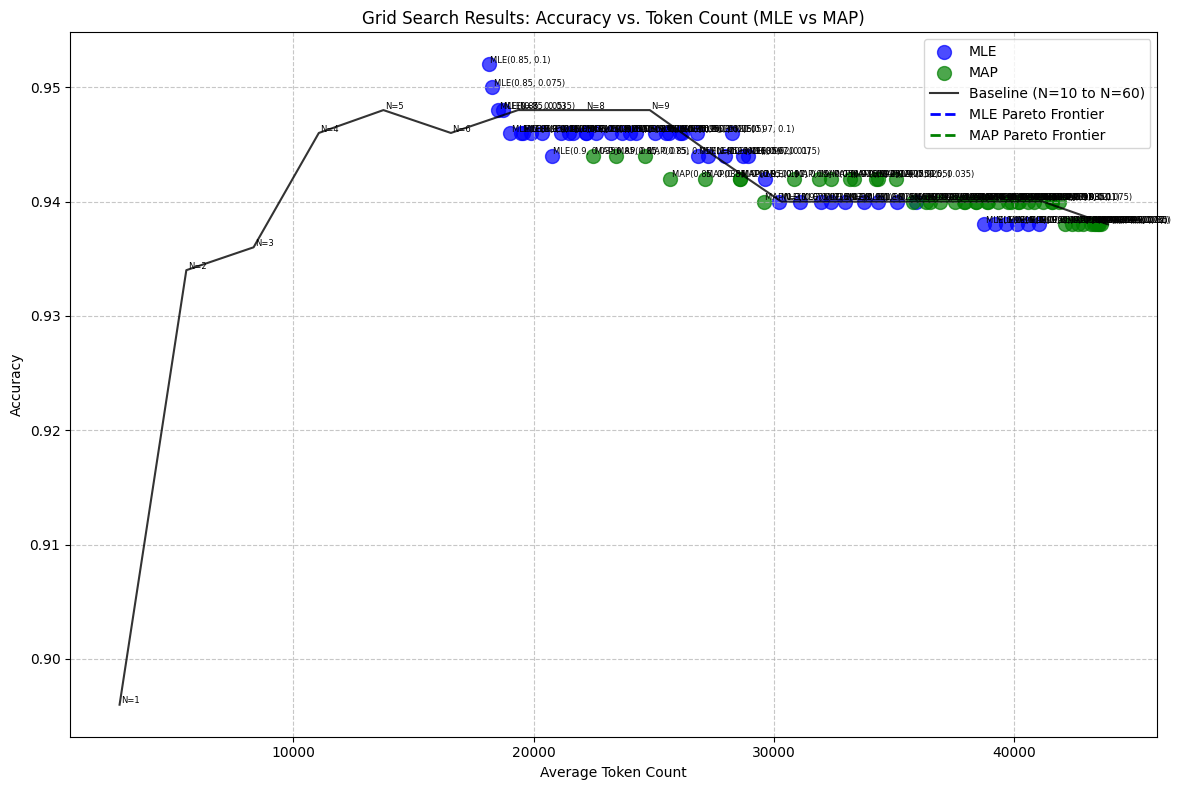


MLE Pareto-optimal configurations:
Target Score: 0.85, Percentile: 0.1, Accuracy: 0.9520, Avg Token Count: 18123.41

MAP Pareto-optimal configurations:
Target Score: 0.85, Percentile: 0.1, Accuracy: 0.9440, Avg Token Count: 22487.26


In [7]:
max_N_panel = 16
print("Target Score Panel:", target_score_panel_values)
print("Percentile Panel:", percentile_panel_values)
print("Max N:", max_N_panel)

# Evaluate MLE results
print("\nEvaluating MLE Results...")
truncated_normal_params_all = mle_estimated_params
mle_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MLE)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MLE Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MLE - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MLE - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        mle_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MLE_results_{max_N_panel}.json', 'w') as f:
    json.dump(mle_grid_search_results, f)


# Evaluate MAP results
print("\nEvaluating MAP Results...")
truncated_normal_params_all = map_estimated_params
map_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MAP)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MAP Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MAP - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MAP - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        map_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MAP_results_{max_N_panel}.json', 'w') as f:
    json.dump(map_grid_search_results, f)

plot_mle_map_optscale(mle_grid_search_results, map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel)

In [8]:
peek_number = 10

mle_estimated_params = []  # Store MLE estimates
map_estimated_params = []  # Store MAP estimates
predictor_params = []      # Store predictor's estimates

for i, (score, prediction) in enumerate(zip(val_scores, val_labels)):
    peek_data = np.array(score[0][:peek_number])
    
    # Store predictor's parameters
    prior_mu, prior_sigma = prediction
    predictor_params.append((prior_mu, prior_sigma))
    
    # MLE estimation with limited data
    initial_mu = np.mean(peek_data)
    initial_sigma = np.std(peek_data)
    mle_result = minimize(
        lambda params: neg_log_likelihood(params, peek_data),
        [initial_mu, initial_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    mle_mu, mle_sigma = mle_result.x
    mle_estimated_params.append((mle_mu, mle_sigma))
    
    # MAP estimation with limited data
    map_result = minimize(
        lambda params: neg_log_posterior(
            params, 
            peek_data, 
            prior_mu=prior_mu, 
            prior_sigma=prior_sigma
        ),
        [prior_mu, prior_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    map_mu, map_sigma = map_result.x
    map_estimated_params.append((map_mu, map_sigma))
    
    # Print comparison for first 50 examples
    if i < 50:
        gt_mu, gt_sigma = original_params_compare[i]
        print(f"{i:<4} {prior_mu:11.4f} {prior_sigma:11.4f} {mle_mu:9.4f} {mle_sigma:9.4f} "
              f"{map_mu:9.4f} {map_sigma:9.4f} {gt_mu:9.4f} {gt_sigma:9.4f}")

# Call the function to perform the analysis
analyze_estimation_performance(predictor_params, mle_estimated_params, map_estimated_params, original_params_compare)


0         0.6015      0.1227    0.9566    0.0108    0.9170    0.0391    0.9559    0.0145
1         0.4543      0.0766    0.9606    0.0094    0.9314    0.0982    0.9781    0.0432
2         0.6429      0.1356    0.9810    0.0291    0.9249    0.0448    0.9637    0.0222
3         0.4399      0.0769    0.9672    0.0095    0.8910    0.1283    0.9713    0.0204
4         0.4217      0.1085    1.2843    0.0887    0.7751    0.1829   30.9907    0.8595
5         0.4133      0.0200    0.9967    0.0121    0.7033    0.2216    1.1051    0.0412
6         0.5740      0.1303    2.0047    0.2122    0.8560    0.1229   41.5896    1.1720
7         0.5280      0.0904    0.9712    0.0126    0.9272    0.0349    0.9732    0.0181
8         0.4172      0.0738    0.9305    0.0247    0.9100    0.0230    0.9309    0.0216
9         0.5581      0.1733    0.9767    0.0087    0.7948    0.1957    1.0747    0.0605
10        0.4970      0.1497    2.0787    0.3610    0.8009    0.1270    1.6000    0.2797
11        0.3311     

Target Score Panel: [0.85, 0.9, 0.925, 0.95, 0.96, 0.97, 0.98, 0.99]
Percentile Panel: [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
Max N: 32

Evaluating MLE Results...


Target Score (MLE):   0%|          | 0/8 [00:00<?, ?it/s]

MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 26, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 27, 10, 10, 16, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 17, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.85, Percentile: 0.01
MLE - Accuracy: 0.9480, Average Token Count: 36190.06
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 22, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 23, 10, 10, 14, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.85, Percentile: 0.02
MLE - Accuracy: 0.9500, Average Token Count: 35713.36
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 10, 10, 12, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.85, Percentile: 0.035
MLE - Accuracy: 0.9500, Average Token Count: 35362.97
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 10, 11, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10

MLE - Target Score: 0.85, Percentile: 0.05
MLE - Accuracy: 0.9500, Average Token Count: 35189.44
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.85, Percentile: 0.075
MLE - Accuracy: 0.9500, Average Token Count: 34955.57
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10

Target Score (MLE):  12%|█▎        | 1/8 [00:08<01:01,  8.84s/it]

MLE - Target Score: 0.85, Percentile: 0.1
MLE - Accuracy: 0.9500, Average Token Count: 34731.75


MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 24, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 29, 11, 10, 10, 10, 32, 10, 13, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 14, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 12, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 22, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.9, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 38800.97
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 25, 10, 10, 10, 10, 32, 10, 11, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 30, 10, 10, 10, 10, 32, 12, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 11, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.9, Percentile: 0.02
MLE - Accuracy: 0.9480, Average Token Count: 38085.52
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 18, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 21, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 26, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.9, Percentile: 0.035
MLE - Accuracy: 0.9480, Average Token Count: 37522.53
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 19, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 23, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 10, 28, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.9, Percentile: 0.05
MLE - Accuracy: 0.9480, Average Token Count: 37190.56
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 30, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 17, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 20, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 10, 25, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.9, Percentile: 0.075
MLE - Accuracy: 0.9480, Average Token Count: 36805.89
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 27, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 30, 10, 10, 15, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 18, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 10, 22, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

Target Score (MLE):  25%|██▌       | 2/8 [00:18<00:55,  9.33s/it]

MLE - Target Score: 0.9, Percentile: 0.1
MLE - Accuracy: 0.9500, Average Token Count: 36442.57


MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 27, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 13, 17, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 24, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 15, 10, 10, 10, 32, 10, 18, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 11, 10, 32, 20, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 18, 10, 10, 10, 24, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 13, 10, 10, 10, 10, 

MLE - Target Score: 0.925, Percentile: 0.01
MLE - Accuracy: 0.9460, Average Token Count: 41044.08
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 23, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 11, 14, 10, 10, 10, 10, 10, 10, 10, 30, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 13, 10, 10, 10, 32, 10, 16, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 17, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 15, 10, 10, 10, 20, 10, 10, 10, 10, 10, 10, 10

MLE - Target Score: 0.925, Percentile: 0.02
MLE - Accuracy: 0.9480, Average Token Count: 40148.55
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 26, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 18, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 11, 10, 10, 10, 32, 10, 13, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 15, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 13, 10, 10, 10, 18, 10, 10, 10, 10, 10, 10, 10

MLE - Target Score: 0.925, Percentile: 0.035
MLE - Accuracy: 0.9480, Average Token Count: 39308.18
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 18, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 23, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 28, 10, 10, 10, 10, 32, 10, 12, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 13, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 12, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 1

MLE - Target Score: 0.925, Percentile: 0.05
MLE - Accuracy: 0.9500, Average Token Count: 38745.23
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 25, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 11, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10

MLE - Target Score: 0.925, Percentile: 0.075
MLE - Accuracy: 0.9500, Average Token Count: 38170.17
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 18, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 22, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 29, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 1

Target Score (MLE):  38%|███▊      | 3/8 [00:28<00:48,  9.74s/it]

MLE - Target Score: 0.925, Percentile: 0.1
MLE - Accuracy: 0.9500, Average Token Count: 37733.95


MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 25, 10, 10, 10, 10, 10, 10, 32, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 13, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 12, 10, 10, 10, 10, 10, 32, 26, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 25, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 22, 10, 32, 32, 10, 10, 32, 25, 10, 10, 10, 32, 10, 28, 10, 11, 32, 10, 32, 10, 10, 14, 10, 10, 10, 10, 32, 10, 10, 16, 10, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 18, 10, 10, 11, 32, 10, 10, 28, 10, 14, 10, 32, 10, 10, 10, 10, 12, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 21, 10, 10, 10, 10, 

MLE - Target Score: 0.95, Percentile: 0.01
MLE - Accuracy: 0.9460, Average Token Count: 45217.02
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 11, 10, 10, 10, 10, 10, 32, 22, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 19, 10, 32, 32, 10, 10, 32, 21, 10, 10, 10, 32, 10, 24, 10, 10, 32, 10, 32, 10, 10, 12, 10, 10, 10, 10, 32, 10, 10, 14, 10, 32, 28, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 10, 10, 32, 10, 10, 24, 10, 12, 10, 32, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.95, Percentile: 0.02
MLE - Accuracy: 0.9460, Average Token Count: 43924.82
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 18, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 19, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 18, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 16, 10, 32, 32, 10, 10, 32, 18, 10, 10, 10, 32, 10, 21, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 12, 10, 32, 24, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 32, 10, 10, 21, 10, 10, 10, 30, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.95, Percentile: 0.035
MLE - Accuracy: 0.9460, Average Token Count: 42745.45
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 29, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 17, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 32, 32, 10, 10, 32, 16, 10, 10, 10, 32, 10, 18, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 11, 10, 32, 21, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 32, 10, 10, 19, 10, 10, 10, 27, 10, 10, 10, 10, 10, 10, 10

MLE - Target Score: 0.95, Percentile: 0.05
MLE - Accuracy: 0.9460, Average Token Count: 42004.40
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 25, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 15, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 31, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 32, 32, 10, 10, 32, 14, 10, 10, 10, 32, 10, 16, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 18, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 16, 10, 10, 10, 23, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.95, Percentile: 0.075
MLE - Accuracy: 0.9460, Average Token Count: 41246.27
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 23, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 13, 10, 10, 10, 10, 10, 10, 10, 29, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 27, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 31, 32, 10, 10, 32, 13, 10, 10, 10, 32, 10, 14, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 16, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 14, 10, 10, 10, 21, 10, 10, 10, 10, 10, 10, 10

Target Score (MLE):  50%|█████     | 4/8 [00:40<00:41, 10.40s/it]

MLE - Target Score: 0.95, Percentile: 0.1
MLE - Accuracy: 0.9460, Average Token Count: 40588.65


MLE Min N Required [11, 10, 10, 10, 10, 10, 10, 10, 32, 10, 13, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 32, 10, 10, 19, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 14, 10, 10, 10, 10, 10, 10, 10, 12, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 14, 15, 19, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 13, 10, 10, 10, 10, 11, 32, 10, 32, 32, 10, 12, 32, 32, 10, 10, 10, 32, 10, 32, 10, 13, 32, 10, 32, 10, 10, 18, 10, 10, 10, 10, 32, 10, 10, 20, 10, 32, 32, 10, 10, 32, 10, 12, 10, 10, 32, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 14, 32, 10, 32, 32, 12, 17, 10, 32, 10, 10, 10, 12, 14, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 20, 10, 10, 10, 10, 13, 10, 32, 10, 10, 10, 26, 10, 10, 10, 10, 

MLE - Target Score: 0.96, Percentile: 0.01
MLE - Accuracy: 0.9460, Average Token Count: 48443.12
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 27, 10, 10, 17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 27, 10, 10, 10, 10, 10, 10, 32, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 31, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 12, 13, 16, 10, 10, 10, 10, 32, 27, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 28, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 11, 10, 10, 10, 10, 10, 28, 10, 32, 32, 10, 10, 32, 27, 10, 10, 10, 32, 10, 30, 10, 11, 32, 10, 32, 10, 10, 15, 10, 10, 10, 10, 32, 10, 10, 17, 10, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 12, 32, 10, 32, 31, 10, 15, 10, 32, 10, 10, 10, 11, 12, 10, 10,

MLE - Target Score: 0.96, Percentile: 0.02
MLE - Accuracy: 0.9440, Average Token Count: 46657.82
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 29, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 23, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 23, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 27, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 11, 11, 14, 10, 10, 10, 10, 32, 24, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 24, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 24, 10, 32, 32, 10, 10, 32, 23, 10, 10, 10, 32, 10, 26, 10, 10, 32, 10, 32, 10, 10, 13, 10, 10, 10, 10, 32, 10, 10, 15, 10, 32, 31, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 31, 10, 10, 10, 32, 10, 28, 27, 10, 13, 10, 32, 10, 10, 10, 10, 11, 10, 10,

MLE - Target Score: 0.96, Percentile: 0.035
MLE - Accuracy: 0.9460, Average Token Count: 45168.40
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 26, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 24, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 12, 10, 10, 10, 10, 32, 21, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 22, 10, 32, 32, 10, 10, 32, 21, 10, 10, 10, 32, 10, 23, 10, 10, 32, 10, 32, 10, 10, 12, 10, 10, 10, 10, 32, 10, 10, 13, 10, 32, 27, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 28, 10, 10, 10, 32, 10, 25, 24, 10, 11, 10, 32, 10, 10, 10, 10, 10, 10, 10

MLE - Target Score: 0.96, Percentile: 0.05
MLE - Accuracy: 0.9460, Average Token Count: 44212.40
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 23, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 18, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 18, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 11, 10, 10, 10, 10, 32, 18, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 19, 10, 32, 32, 10, 10, 32, 18, 10, 10, 10, 32, 10, 20, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 12, 10, 32, 24, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 24, 10, 10, 10, 32, 10, 21, 21, 10, 10, 10, 30, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.96, Percentile: 0.075
MLE - Accuracy: 0.9460, Average Token Count: 43075.10
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 29, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 16, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 32, 32, 10, 10, 32, 16, 10, 10, 10, 32, 10, 18, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 21, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 22, 10, 10, 10, 32, 10, 19, 18, 10, 10, 10, 27, 10, 10, 10, 10, 10, 10, 10

Target Score (MLE):  62%|██████▎   | 5/8 [00:52<00:33, 11.27s/it]

MLE - Target Score: 0.96, Percentile: 0.1
MLE - Accuracy: 0.9460, Average Token Count: 42253.98


MLE Min N Required [32, 30, 10, 11, 10, 10, 10, 10, 32, 10, 17, 10, 10, 10, 10, 10, 10, 16, 14, 10, 10, 10, 10, 10, 15, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 27, 10, 10, 10, 11, 10, 13, 10, 10, 23, 11, 10, 10, 10, 10, 14, 10, 10, 10, 16, 11, 10, 32, 12, 10, 10, 10, 10, 10, 32, 10, 19, 10, 10, 10, 10, 10, 10, 10, 17, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 21, 32, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 11, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 17, 10, 10, 10, 10, 15, 32, 13, 32, 32, 10, 16, 32, 32, 10, 21, 10, 32, 24, 32, 13, 18, 32, 10, 32, 10, 10, 24, 10, 10, 10, 10, 32, 10, 10, 27, 13, 32, 32, 10, 10, 32, 10, 16, 18, 10, 32, 10, 10, 18, 10, 12, 10, 10, 10, 23, 10, 10, 10, 10, 13, 10, 10, 32, 10, 10, 19, 32, 10, 32, 32, 16, 23, 10, 32, 10, 10, 10, 16, 19, 10, 11, 10, 10, 32, 10, 10, 10, 10, 10, 26, 10, 10, 10, 10, 18, 10, 32, 10, 10, 10, 32, 10, 10, 10, 10, 

MLE - Target Score: 0.97, Percentile: 0.01
MLE - Accuracy: 0.9420, Average Token Count: 53138.84
MLE Min N Required [32, 25, 10, 10, 10, 10, 10, 10, 32, 10, 15, 10, 10, 10, 10, 10, 10, 13, 12, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 31, 10, 10, 32, 10, 10, 23, 10, 10, 10, 10, 10, 11, 10, 10, 20, 10, 10, 10, 10, 10, 12, 10, 10, 10, 14, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 16, 10, 10, 10, 10, 10, 10, 10, 14, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 18, 32, 10, 10, 10, 10, 32, 32, 27, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 15, 10, 10, 10, 10, 12, 32, 11, 32, 32, 10, 14, 32, 32, 10, 18, 10, 32, 20, 32, 11, 15, 32, 10, 32, 10, 10, 20, 10, 10, 10, 10, 32, 10, 10, 23, 11, 32, 32, 10, 10, 32, 10, 14, 15, 10, 32, 10, 10, 16, 10, 10, 10, 10, 10, 19, 10, 10, 10, 10, 11, 10, 10, 32, 10, 10, 16, 32, 10, 32, 32, 14, 20, 10, 32, 10, 10, 10, 14, 16, 10, 10,

MLE - Target Score: 0.97, Percentile: 0.02
MLE - Accuracy: 0.9440, Average Token Count: 51308.00
MLE Min N Required [32, 22, 10, 10, 10, 10, 10, 10, 32, 10, 13, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 26, 10, 10, 32, 10, 10, 20, 10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 31, 10, 10, 10, 10, 10, 10, 32, 10, 14, 10, 10, 10, 10, 10, 10, 10, 12, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 15, 31, 10, 10, 10, 10, 32, 32, 23, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 13, 10, 10, 10, 10, 11, 32, 10, 32, 32, 10, 12, 32, 32, 10, 15, 10, 32, 18, 32, 10, 13, 32, 10, 32, 10, 10, 18, 10, 10, 10, 10, 32, 10, 10, 20, 10, 32, 32, 10, 10, 32, 10, 12, 13, 10, 32, 10, 10, 14, 10, 10, 10, 10, 10, 17, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 14, 32, 10, 32, 32, 12, 17, 10, 32, 10, 10, 10, 12, 14, 10, 10,

MLE - Target Score: 0.97, Percentile: 0.035
MLE - Accuracy: 0.9440, Average Token Count: 49559.39
MLE Min N Required [29, 19, 10, 10, 10, 10, 10, 10, 32, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 24, 10, 10, 32, 10, 10, 18, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 28, 10, 10, 10, 10, 10, 10, 32, 10, 12, 10, 10, 10, 10, 10, 10, 10, 11, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 14, 28, 10, 10, 10, 10, 32, 28, 21, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 30, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 11, 10, 10, 10, 10, 10, 32, 10, 32, 32, 10, 11, 32, 29, 10, 14, 10, 32, 16, 31, 10, 12, 32, 10, 32, 10, 10, 16, 10, 10, 10, 10, 32, 10, 10, 18, 10, 32, 32, 10, 10, 32, 10, 11, 12, 10, 32, 10, 10, 12, 10, 10, 10, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 12, 32, 10, 32, 32, 11, 15, 10, 32, 10, 10, 10, 11, 13, 10, 10

MLE - Target Score: 0.97, Percentile: 0.05
MLE - Accuracy: 0.9440, Average Token Count: 48209.80
MLE Min N Required [25, 17, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 20, 10, 10, 32, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 24, 10, 10, 10, 10, 10, 10, 32, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 12, 24, 10, 10, 10, 10, 32, 25, 18, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 26, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 31, 10, 32, 32, 10, 10, 32, 25, 10, 12, 10, 32, 14, 27, 10, 10, 32, 10, 32, 10, 10, 14, 10, 10, 10, 10, 32, 10, 10, 16, 10, 32, 32, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 11, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 11, 32, 10, 32, 28, 10, 13, 10, 32, 10, 10, 10, 10, 11, 10, 10,

MLE - Target Score: 0.97, Percentile: 0.075
MLE - Accuracy: 0.9440, Average Token Count: 46623.26
MLE Min N Required [23, 15, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 18, 10, 10, 32, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 22, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 11, 22, 10, 10, 10, 10, 32, 22, 16, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 23, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 28, 10, 32, 32, 10, 10, 32, 22, 10, 11, 10, 32, 12, 24, 10, 10, 32, 10, 32, 10, 10, 12, 10, 10, 10, 10, 32, 10, 10, 14, 10, 32, 29, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 32, 25, 10, 12, 10, 32, 10, 10, 10, 10, 10, 10, 10

Target Score (MLE):  75%|███████▌  | 6/8 [01:07<00:24, 12.44s/it]

MLE - Target Score: 0.97, Percentile: 0.1
MLE - Accuracy: 0.9440, Average Token Count: 45568.93


MLE Min N Required [32, 32, 12, 32, 10, 10, 10, 19, 32, 12, 26, 10, 14, 15, 32, 10, 10, 23, 20, 15, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 19, 10, 32, 10, 13, 32, 10, 10, 12, 27, 10, 32, 10, 24, 32, 16, 15, 10, 10, 21, 20, 10, 16, 10, 32, 32, 10, 32, 18, 32, 10, 26, 13, 11, 32, 11, 28, 10, 10, 10, 20, 10, 10, 10, 26, 32, 32, 10, 10, 15, 10, 10, 10, 11, 13, 10, 10, 10, 32, 32, 31, 32, 10, 12, 10, 10, 32, 32, 32, 11, 10, 10, 11, 16, 15, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 13, 10, 10, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 26, 10, 10, 10, 10, 22, 32, 19, 32, 32, 10, 24, 32, 32, 10, 32, 10, 32, 32, 32, 24, 27, 32, 10, 32, 10, 10, 32, 10, 10, 10, 10, 32, 18, 11, 32, 32, 32, 32, 10, 16, 32, 10, 24, 32, 10, 32, 10, 14, 28, 16, 20, 14, 10, 10, 32, 10, 10, 10, 10, 24, 10, 12, 32, 10, 10, 28, 32, 12, 32, 32, 24, 32, 10, 32, 24, 15, 10, 24, 28, 10, 16, 13, 32, 32, 27, 10, 10, 10, 17, 32, 10, 10, 11, 10, 29, 10, 32, 10, 10, 10, 32, 10, 10, 10, 30, 

MLE - Target Score: 0.98, Percentile: 0.01
MLE - Accuracy: 0.9440, Average Token Count: 61537.93
MLE Min N Required [32, 32, 10, 32, 10, 10, 10, 16, 32, 10, 22, 10, 12, 13, 32, 10, 10, 20, 17, 13, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 16, 10, 32, 10, 11, 32, 10, 10, 10, 23, 10, 32, 10, 20, 32, 14, 12, 10, 10, 18, 17, 10, 14, 10, 32, 32, 10, 32, 15, 32, 10, 22, 11, 10, 32, 10, 24, 10, 10, 10, 17, 10, 10, 10, 22, 32, 32, 10, 10, 13, 10, 10, 10, 10, 11, 10, 10, 10, 32, 32, 26, 32, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 13, 12, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 11, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 22, 10, 10, 10, 10, 19, 32, 16, 32, 32, 10, 20, 32, 32, 10, 32, 10, 32, 32, 32, 21, 23, 32, 10, 32, 10, 10, 31, 10, 10, 10, 10, 32, 15, 10, 32, 27, 32, 32, 10, 13, 32, 10, 20, 32, 10, 32, 10, 12, 23, 13, 17, 12, 10, 10, 32, 10, 10, 10, 10, 21, 10, 10, 32, 10, 10, 24, 32, 11, 32, 32, 20, 30, 10, 32, 21, 13, 10, 21, 24, 10, 14,

MLE - Target Score: 0.98, Percentile: 0.02
MLE - Accuracy: 0.9420, Average Token Count: 59148.03
MLE Min N Required [32, 32, 10, 32, 10, 10, 10, 14, 32, 10, 19, 10, 10, 11, 32, 10, 10, 17, 15, 11, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 14, 10, 32, 10, 10, 32, 10, 10, 10, 20, 10, 29, 10, 17, 32, 12, 11, 10, 10, 15, 15, 10, 12, 10, 28, 30, 10, 32, 13, 32, 10, 19, 10, 10, 32, 10, 20, 10, 10, 10, 15, 10, 10, 10, 19, 32, 32, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 23, 32, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 11, 11, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 19, 10, 10, 10, 10, 16, 32, 14, 32, 32, 10, 17, 32, 32, 10, 32, 10, 32, 32, 32, 18, 19, 32, 10, 32, 10, 10, 27, 10, 10, 10, 10, 32, 13, 10, 30, 23, 32, 32, 10, 12, 32, 10, 17, 32, 10, 32, 10, 10, 20, 12, 14, 10, 10, 10, 32, 10, 10, 10, 10, 18, 10, 10, 32, 10, 10, 20, 32, 10, 32, 32, 17, 26, 10, 32, 18, 11, 10, 18, 21, 10, 12,

MLE - Target Score: 0.98, Percentile: 0.035
MLE - Accuracy: 0.9420, Average Token Count: 57011.47
MLE Min N Required [32, 32, 10, 32, 10, 10, 10, 12, 32, 10, 17, 10, 10, 10, 32, 10, 10, 15, 13, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 13, 10, 32, 10, 10, 28, 10, 10, 10, 17, 10, 26, 10, 16, 32, 11, 10, 10, 10, 14, 13, 10, 11, 10, 25, 27, 10, 32, 12, 32, 10, 17, 10, 10, 32, 10, 18, 10, 10, 10, 13, 10, 10, 10, 17, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 20, 32, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 17, 10, 10, 10, 10, 15, 32, 12, 32, 32, 10, 16, 32, 32, 10, 32, 10, 32, 32, 32, 16, 17, 32, 10, 32, 10, 10, 24, 10, 10, 10, 10, 32, 12, 10, 27, 21, 32, 32, 10, 10, 32, 10, 16, 32, 10, 32, 10, 10, 18, 10, 13, 10, 10, 10, 32, 10, 10, 10, 10, 16, 10, 10, 32, 10, 10, 18, 32, 10, 32, 32, 16, 23, 10, 32, 16, 10, 10, 16, 19, 10, 11

MLE - Target Score: 0.98, Percentile: 0.05
MLE - Accuracy: 0.9440, Average Token Count: 55565.80
MLE Min N Required [32, 32, 10, 31, 10, 10, 10, 11, 32, 10, 15, 10, 10, 10, 32, 10, 10, 13, 12, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 11, 10, 32, 10, 10, 24, 10, 10, 10, 15, 10, 23, 10, 14, 32, 10, 10, 10, 10, 12, 12, 10, 10, 10, 22, 23, 10, 32, 10, 32, 10, 15, 10, 10, 32, 10, 16, 10, 10, 10, 11, 10, 10, 10, 15, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 18, 32, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 15, 10, 10, 10, 10, 13, 32, 11, 32, 32, 10, 13, 32, 32, 10, 32, 10, 32, 32, 32, 14, 15, 32, 10, 32, 10, 10, 21, 10, 10, 10, 10, 32, 10, 10, 23, 18, 32, 32, 10, 10, 32, 10, 14, 32, 10, 32, 10, 10, 16, 10, 11, 10, 10, 10, 32, 10, 10, 10, 10, 14, 10, 10, 32, 10, 10, 16, 32, 10, 32, 32, 14, 20, 10, 32, 14, 10, 10, 14, 16, 10, 10,

MLE - Target Score: 0.98, Percentile: 0.075
MLE - Accuracy: 0.9440, Average Token Count: 53981.97
MLE Min N Required [32, 32, 10, 27, 10, 10, 10, 10, 32, 10, 13, 10, 10, 10, 32, 10, 10, 12, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 22, 10, 10, 10, 14, 10, 20, 10, 12, 32, 10, 10, 10, 10, 11, 10, 10, 10, 10, 19, 21, 10, 32, 10, 32, 10, 13, 10, 10, 32, 10, 14, 10, 10, 10, 10, 10, 10, 10, 13, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 16, 32, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 13, 10, 10, 10, 10, 11, 32, 10, 32, 32, 10, 12, 32, 32, 10, 32, 10, 32, 32, 32, 12, 14, 32, 10, 32, 10, 10, 18, 10, 10, 10, 10, 32, 10, 10, 21, 16, 32, 32, 10, 10, 32, 10, 12, 32, 10, 32, 10, 10, 14, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 12, 10, 10, 32, 10, 10, 14, 32, 10, 32, 32, 12, 18, 10, 32, 12, 10, 10, 12, 14, 10, 10

Target Score (MLE):  88%|████████▊ | 7/8 [01:25<00:14, 14.30s/it]

MLE - Target Score: 0.98, Percentile: 0.1
MLE - Accuracy: 0.9440, Average Token Count: 52510.47


MLE Min N Required [32, 32, 27, 32, 12, 10, 20, 32, 32, 32, 32, 20, 32, 32, 32, 10, 13, 32, 32, 31, 32, 10, 17, 16, 32, 10, 12, 32, 19, 32, 32, 25, 32, 10, 25, 32, 32, 10, 23, 32, 10, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 10, 32, 32, 24, 32, 32, 32, 32, 32, 26, 25, 32, 22, 32, 10, 15, 10, 32, 10, 10, 10, 32, 32, 32, 22, 10, 32, 10, 32, 10, 32, 27, 10, 10, 10, 32, 32, 32, 32, 10, 24, 32, 10, 32, 32, 32, 22, 10, 10, 21, 31, 29, 32, 10, 10, 10, 10, 10, 18, 19, 30, 14, 14, 10, 32, 15, 32, 10, 10, 10, 32, 11, 10, 10, 11, 32, 13, 10, 10, 10, 10, 10, 10, 32, 10, 32, 32, 10, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 10, 15, 32, 11, 24, 16, 10, 32, 32, 22, 32, 32, 32, 32, 10, 32, 32, 10, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 10, 19, 32, 10, 10, 26, 16, 32, 10, 32, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 27, 31, 28, 32, 32, 32, 15, 11, 18, 32, 32, 22, 10, 28, 16, 32, 10, 32, 10, 24, 10, 32, 12, 16, 10, 32, 

MLE - Target Score: 0.99, Percentile: 0.01
MLE - Accuracy: 0.9440, Average Token Count: 75169.50
MLE Min N Required [32, 32, 23, 32, 10, 10, 17, 32, 32, 32, 32, 17, 32, 32, 32, 10, 11, 32, 32, 27, 29, 10, 14, 14, 32, 10, 10, 32, 16, 32, 32, 21, 32, 10, 21, 32, 32, 10, 20, 32, 10, 32, 30, 32, 32, 27, 32, 32, 10, 32, 32, 10, 32, 10, 32, 32, 21, 32, 30, 32, 32, 32, 22, 21, 32, 19, 32, 10, 13, 10, 32, 10, 10, 10, 32, 32, 32, 19, 10, 32, 10, 32, 10, 32, 23, 10, 10, 10, 32, 32, 32, 32, 10, 20, 32, 10, 32, 32, 32, 19, 10, 10, 18, 26, 25, 32, 10, 10, 10, 10, 10, 15, 16, 26, 12, 12, 10, 32, 13, 32, 10, 10, 10, 32, 10, 10, 10, 10, 32, 11, 10, 10, 10, 10, 10, 10, 32, 10, 32, 32, 10, 10, 10, 10, 32, 32, 31, 32, 32, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 10, 13, 32, 10, 20, 14, 10, 32, 32, 19, 32, 32, 32, 32, 10, 32, 32, 10, 32, 32, 10, 32, 32, 29, 32, 32, 32, 28, 10, 16, 32, 10, 10, 22, 13, 32, 10, 32, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 27, 32, 32, 32, 23, 27,

MLE - Target Score: 0.99, Percentile: 0.02
MLE - Accuracy: 0.9440, Average Token Count: 73001.09
MLE Min N Required [32, 32, 20, 32, 10, 10, 15, 32, 32, 32, 32, 15, 32, 32, 32, 10, 10, 32, 29, 23, 25, 10, 12, 12, 32, 10, 10, 32, 14, 32, 32, 18, 32, 10, 18, 32, 32, 10, 17, 32, 10, 32, 26, 32, 32, 23, 32, 32, 10, 32, 29, 10, 32, 10, 32, 32, 18, 32, 26, 32, 32, 32, 19, 18, 32, 16, 32, 10, 11, 10, 32, 10, 10, 10, 32, 32, 32, 16, 10, 32, 10, 32, 10, 32, 20, 10, 10, 10, 32, 32, 32, 32, 10, 18, 32, 10, 32, 32, 32, 16, 10, 10, 15, 22, 21, 32, 10, 10, 10, 10, 10, 13, 14, 22, 10, 11, 10, 32, 11, 32, 10, 10, 10, 29, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 32, 10, 10, 10, 10, 32, 32, 27, 32, 32, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 10, 11, 32, 10, 17, 12, 10, 32, 32, 16, 32, 32, 32, 32, 10, 32, 32, 10, 32, 32, 10, 32, 32, 25, 32, 32, 32, 24, 10, 14, 32, 10, 10, 19, 12, 32, 10, 30, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 24, 32, 32, 32, 20, 23,

MLE - Target Score: 0.99, Percentile: 0.035
MLE - Accuracy: 0.9440, Average Token Count: 71070.32
MLE Min N Required [32, 32, 18, 32, 10, 10, 13, 32, 32, 32, 32, 13, 32, 32, 32, 10, 10, 30, 26, 20, 22, 10, 11, 11, 32, 10, 10, 32, 13, 32, 32, 17, 32, 10, 16, 32, 32, 10, 15, 32, 10, 32, 24, 32, 32, 21, 32, 32, 10, 32, 26, 10, 32, 10, 32, 32, 16, 32, 23, 32, 32, 32, 17, 17, 32, 14, 32, 10, 10, 10, 32, 10, 10, 10, 32, 32, 32, 14, 10, 32, 10, 32, 10, 32, 18, 10, 10, 10, 32, 32, 32, 32, 10, 16, 32, 10, 32, 32, 32, 14, 10, 10, 14, 20, 19, 32, 10, 10, 10, 10, 10, 12, 13, 20, 10, 10, 10, 32, 10, 32, 10, 10, 10, 26, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 30, 32, 10, 10, 10, 10, 30, 32, 24, 32, 32, 10, 31, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 10, 10, 32, 10, 16, 11, 10, 32, 32, 15, 32, 32, 32, 32, 10, 32, 32, 10, 31, 32, 10, 32, 32, 23, 32, 32, 29, 21, 10, 12, 32, 10, 10, 17, 10, 32, 10, 27, 32, 10, 10, 32, 32, 32, 32, 32, 31, 32, 10, 32, 32, 21, 32, 31, 32, 18, 21

MLE - Target Score: 0.99, Percentile: 0.05
MLE - Accuracy: 0.9420, Average Token Count: 69629.67
MLE Min N Required [32, 32, 15, 32, 10, 10, 12, 32, 32, 32, 29, 12, 32, 32, 32, 10, 10, 26, 23, 18, 19, 10, 10, 10, 32, 10, 10, 32, 11, 32, 32, 14, 32, 10, 14, 32, 32, 10, 13, 32, 10, 32, 21, 32, 32, 18, 32, 32, 10, 32, 23, 10, 32, 10, 32, 32, 14, 32, 20, 32, 32, 32, 15, 14, 32, 13, 31, 10, 10, 10, 32, 10, 10, 10, 30, 32, 32, 12, 10, 32, 10, 32, 10, 32, 15, 10, 10, 10, 32, 32, 32, 32, 10, 14, 28, 10, 32, 32, 32, 13, 10, 10, 12, 17, 16, 32, 10, 10, 10, 10, 10, 10, 11, 17, 10, 10, 10, 32, 10, 32, 10, 10, 10, 23, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 26, 29, 10, 10, 10, 10, 26, 32, 21, 32, 32, 10, 26, 32, 32, 32, 32, 10, 32, 32, 32, 32, 30, 32, 10, 32, 10, 10, 32, 10, 14, 10, 10, 32, 32, 13, 32, 32, 32, 32, 10, 32, 32, 10, 27, 32, 10, 32, 32, 20, 31, 32, 25, 19, 10, 11, 32, 10, 10, 15, 10, 32, 10, 23, 32, 10, 10, 32, 32, 32, 32, 32, 27, 32, 10, 32, 32, 18, 32, 27, 32, 16, 18,

MLE - Target Score: 0.99, Percentile: 0.075
MLE - Accuracy: 0.9420, Average Token Count: 67691.17
MLE Min N Required [32, 32, 14, 32, 10, 10, 10, 32, 32, 32, 26, 10, 32, 32, 32, 10, 10, 23, 20, 16, 17, 10, 10, 10, 32, 10, 10, 32, 10, 32, 32, 13, 32, 10, 13, 32, 32, 10, 12, 32, 10, 32, 18, 32, 32, 16, 32, 32, 10, 32, 20, 10, 32, 10, 32, 32, 12, 32, 18, 32, 32, 32, 13, 13, 32, 11, 28, 10, 10, 10, 32, 10, 10, 10, 27, 32, 32, 11, 10, 32, 10, 32, 10, 31, 14, 10, 10, 10, 32, 32, 31, 32, 10, 12, 25, 10, 32, 32, 32, 11, 10, 10, 11, 16, 15, 32, 10, 10, 10, 10, 10, 10, 10, 15, 10, 10, 10, 32, 10, 32, 10, 10, 10, 20, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 23, 26, 10, 10, 10, 10, 23, 32, 19, 32, 32, 10, 24, 32, 32, 32, 32, 10, 32, 32, 32, 31, 27, 32, 10, 32, 10, 10, 32, 10, 12, 10, 10, 32, 32, 11, 32, 32, 32, 32, 10, 32, 32, 10, 24, 32, 10, 32, 32, 17, 28, 32, 23, 17, 10, 10, 32, 10, 10, 13, 10, 30, 10, 21, 32, 10, 10, 28, 32, 32, 32, 32, 24, 32, 10, 32, 32, 16, 29, 24, 28, 14, 16

Target Score (MLE): 100%|██████████| 8/8 [01:50<00:00, 13.84s/it]


MLE - Target Score: 0.99, Percentile: 0.1
MLE - Accuracy: 0.9420, Average Token Count: 65937.28

Evaluating MAP Results...


Target Score (MAP):   0%|          | 0/8 [00:00<?, ?it/s]

MAP Min N Required [10, 10, 10, 10, 16, 24, 10, 10, 10, 14, 13, 10, 21, 10, 10, 10, 14, 15, 19, 10, 10, 19, 10, 17, 17, 25, 23, 10, 10, 15, 10, 10, 10, 22, 17, 12, 21, 10, 19, 10, 19, 10, 10, 10, 10, 15, 10, 10, 13, 13, 19, 14, 10, 10, 10, 19, 16, 18, 13, 10, 13, 10, 15, 10, 32, 10, 10, 10, 10, 10, 17, 10, 10, 10, 11, 10, 15, 18, 32, 10, 18, 10, 10, 10, 10, 17, 10, 10, 32, 10, 15, 10, 23, 21, 10, 18, 10, 13, 10, 10, 10, 10, 10, 16, 10, 21, 10, 10, 19, 10, 12, 10, 12, 10, 10, 25, 11, 10, 27, 10, 10, 20, 20, 20, 10, 19, 10, 14, 16, 10, 10, 10, 10, 10, 15, 10, 32, 10, 15, 10, 10, 21, 22, 10, 10, 10, 10, 11, 30, 10, 10, 20, 10, 18, 10, 10, 32, 11, 13, 10, 10, 32, 10, 32, 11, 10, 10, 21, 11, 10, 10, 21, 10, 12, 10, 10, 32, 12, 10, 10, 32, 18, 10, 10, 10, 17, 10, 11, 23, 10, 10, 10, 16, 17, 27, 17, 10, 22, 10, 10, 10, 16, 10, 10, 17, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 27, 21, 10, 17, 10, 11, 16, 13, 20, 15, 10, 10, 11, 16, 10, 21, 10, 10, 17, 32, 10, 10, 20, 10, 10, 10, 14, 10, 

MAP - Target Score: 0.85, Percentile: 0.01
MAP - Accuracy: 0.9460, Average Token Count: 43887.61
MAP Min N Required [10, 10, 10, 10, 14, 20, 10, 10, 10, 12, 11, 10, 18, 10, 10, 10, 12, 13, 16, 10, 10, 16, 10, 14, 15, 21, 19, 10, 10, 13, 10, 10, 10, 19, 15, 11, 18, 10, 16, 10, 16, 10, 10, 10, 10, 13, 10, 10, 11, 11, 16, 12, 10, 10, 10, 16, 14, 16, 11, 10, 12, 10, 13, 10, 28, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 13, 15, 28, 10, 16, 10, 10, 10, 10, 14, 10, 10, 32, 10, 13, 10, 19, 18, 10, 16, 10, 11, 10, 10, 10, 10, 10, 14, 10, 18, 10, 10, 16, 10, 11, 10, 10, 10, 10, 21, 10, 10, 23, 10, 10, 17, 17, 17, 10, 16, 10, 12, 14, 10, 10, 10, 10, 10, 13, 10, 32, 10, 13, 10, 10, 18, 19, 10, 10, 10, 10, 10, 25, 10, 10, 17, 10, 16, 10, 10, 32, 10, 12, 10, 10, 32, 10, 32, 10, 10, 10, 18, 10, 10, 10, 18, 10, 11, 10, 10, 32, 10, 10, 10, 32, 15, 10, 10, 10, 14, 10, 10, 19, 10, 10, 10, 14, 15, 23, 14, 10, 18, 10, 10, 10, 14, 10, 10, 14, 10, 32, 10, 10, 10, 10, 28, 10, 10, 10, 10, 10, 23, 18, 10, 14,

MAP - Target Score: 0.85, Percentile: 0.02
MAP - Accuracy: 0.9440, Average Token Count: 41011.17
MAP Min N Required [10, 10, 10, 10, 12, 17, 10, 10, 10, 11, 10, 10, 16, 10, 10, 10, 11, 11, 14, 10, 10, 14, 10, 12, 13, 18, 17, 10, 10, 11, 10, 10, 10, 16, 13, 10, 15, 10, 14, 10, 14, 10, 10, 10, 10, 11, 10, 10, 10, 10, 14, 10, 10, 10, 10, 14, 12, 13, 10, 10, 10, 10, 11, 10, 24, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 11, 13, 24, 10, 14, 10, 10, 10, 10, 12, 10, 10, 32, 10, 11, 10, 17, 15, 10, 13, 10, 10, 10, 10, 10, 10, 10, 12, 10, 16, 10, 10, 14, 10, 10, 10, 10, 10, 10, 18, 10, 10, 20, 10, 10, 15, 15, 15, 10, 14, 10, 10, 12, 10, 10, 10, 10, 10, 11, 10, 32, 10, 11, 10, 10, 15, 16, 10, 10, 10, 10, 10, 22, 10, 10, 14, 10, 13, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 15, 10, 10, 10, 16, 10, 10, 10, 10, 32, 10, 10, 10, 32, 13, 10, 10, 10, 12, 10, 10, 17, 10, 10, 10, 12, 13, 20, 12, 10, 16, 10, 10, 10, 12, 10, 10, 12, 10, 32, 10, 10, 10, 10, 24, 10, 10, 10, 10, 10, 19, 15, 10, 12,

MAP - Target Score: 0.85, Percentile: 0.035
MAP - Accuracy: 0.9460, Average Token Count: 38779.98
MAP Min N Required [10, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 12, 10, 10, 12, 10, 11, 12, 16, 15, 10, 10, 10, 10, 10, 10, 14, 11, 10, 14, 10, 12, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 13, 11, 12, 10, 10, 10, 10, 10, 10, 22, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 12, 21, 10, 12, 10, 10, 10, 10, 11, 10, 10, 32, 10, 10, 10, 15, 14, 10, 12, 10, 10, 10, 10, 10, 10, 10, 11, 10, 14, 10, 10, 12, 10, 10, 10, 10, 10, 10, 16, 10, 10, 18, 10, 10, 13, 13, 13, 10, 13, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 14, 15, 10, 10, 10, 10, 10, 19, 10, 10, 13, 10, 12, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 14, 10, 10, 10, 14, 10, 10, 10, 10, 32, 10, 10, 10, 32, 12, 10, 10, 10, 11, 10, 10, 15, 10, 10, 10, 11, 11, 18, 11, 10, 14, 10, 10, 10, 11, 10, 10, 11, 10, 32, 10, 10, 10, 10, 21, 10, 10, 10, 10, 10, 17, 14, 10, 11

MAP - Target Score: 0.85, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 37451.32
MAP Min N Required [10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 11, 10, 10, 11, 10, 10, 10, 14, 13, 10, 10, 10, 10, 10, 10, 12, 10, 10, 12, 10, 11, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 11, 10, 11, 10, 10, 10, 10, 10, 10, 19, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 10, 11, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 13, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 11, 10, 10, 10, 10, 10, 10, 14, 10, 10, 15, 10, 10, 11, 12, 12, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 12, 13, 10, 10, 10, 10, 10, 17, 10, 10, 11, 10, 11, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 12, 10, 10, 10, 12, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 16, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 19, 10, 10, 10, 10, 10, 15, 12, 10, 10,

MAP - Target Score: 0.85, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 36059.64
MAP Min N Required [10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 12, 10, 10, 10, 10, 10, 10, 11, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 12, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 11, 11, 10, 10, 10, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 11, 10, 10, 10, 11, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 14, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 17, 10, 10, 10, 10, 10, 14, 11, 10, 10

Target Score (MAP):  12%|█▎        | 1/8 [00:14<01:40, 14.35s/it]

MAP - Target Score: 0.85, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 35317.01


MAP Min N Required [10, 10, 10, 12, 28, 32, 15, 10, 10, 25, 25, 18, 32, 10, 10, 10, 24, 28, 32, 10, 10, 30, 10, 28, 27, 32, 32, 10, 10, 28, 10, 10, 10, 32, 29, 26, 32, 19, 32, 18, 32, 10, 10, 10, 10, 26, 10, 10, 23, 21, 31, 23, 10, 10, 11, 32, 26, 32, 22, 10, 23, 10, 26, 10, 32, 10, 11, 10, 10, 10, 28, 10, 10, 10, 20, 10, 29, 32, 32, 10, 30, 10, 10, 10, 10, 28, 19, 10, 32, 10, 28, 18, 32, 32, 10, 29, 10, 22, 14, 10, 10, 16, 10, 26, 16, 32, 10, 10, 32, 10, 23, 10, 21, 10, 10, 32, 17, 13, 32, 14, 13, 32, 32, 32, 10, 32, 10, 25, 27, 14, 10, 10, 10, 10, 24, 16, 32, 10, 25, 10, 10, 32, 32, 18, 10, 17, 17, 19, 32, 10, 10, 32, 17, 30, 10, 10, 32, 18, 24, 10, 10, 32, 10, 32, 21, 10, 11, 32, 20, 10, 10, 32, 10, 21, 16, 10, 32, 23, 15, 10, 32, 31, 11, 10, 10, 32, 10, 22, 32, 10, 16, 10, 26, 28, 32, 26, 10, 32, 10, 10, 10, 26, 10, 10, 27, 10, 32, 13, 11, 17, 10, 32, 10, 20, 10, 15, 10, 32, 32, 10, 28, 10, 19, 32, 24, 32, 24, 10, 10, 21, 25, 10, 32, 10, 10, 27, 32, 10, 10, 32, 16, 10, 18, 23, 10, 

MAP - Target Score: 0.9, Percentile: 0.01
MAP - Accuracy: 0.9440, Average Token Count: 58051.78
MAP Min N Required [10, 10, 10, 10, 24, 32, 13, 10, 10, 21, 22, 15, 30, 10, 10, 10, 20, 24, 29, 10, 10, 25, 10, 24, 23, 32, 32, 10, 10, 24, 10, 10, 10, 30, 25, 22, 32, 16, 27, 15, 28, 10, 10, 10, 10, 22, 10, 10, 20, 18, 26, 19, 10, 10, 10, 27, 22, 29, 19, 10, 20, 10, 22, 10, 32, 10, 10, 10, 10, 10, 24, 10, 10, 10, 17, 10, 25, 27, 32, 10, 26, 10, 10, 10, 10, 24, 16, 10, 32, 10, 24, 15, 32, 30, 10, 24, 10, 19, 12, 10, 10, 14, 10, 23, 14, 32, 10, 10, 28, 10, 19, 10, 18, 10, 10, 32, 15, 11, 32, 12, 11, 28, 29, 29, 10, 28, 10, 21, 23, 12, 10, 10, 10, 10, 21, 14, 32, 10, 22, 10, 10, 29, 32, 15, 10, 14, 15, 16, 32, 10, 10, 32, 14, 25, 10, 10, 32, 16, 20, 10, 10, 32, 10, 32, 18, 10, 10, 29, 17, 10, 10, 32, 10, 18, 13, 10, 32, 20, 12, 10, 32, 26, 10, 10, 10, 32, 10, 18, 32, 10, 13, 10, 22, 23, 32, 22, 10, 30, 10, 10, 10, 22, 10, 10, 23, 10, 32, 11, 10, 14, 10, 32, 10, 17, 10, 13, 10, 32, 31, 10, 24, 

MAP - Target Score: 0.9, Percentile: 0.02
MAP - Accuracy: 0.9460, Average Token Count: 54367.01
MAP Min N Required [10, 10, 10, 10, 20, 30, 11, 10, 10, 18, 19, 13, 26, 10, 10, 10, 18, 20, 25, 10, 10, 22, 10, 20, 20, 30, 28, 10, 10, 20, 10, 10, 10, 26, 22, 19, 27, 14, 23, 13, 24, 10, 10, 10, 10, 19, 10, 10, 17, 15, 23, 17, 10, 10, 10, 23, 19, 25, 16, 10, 17, 10, 19, 10, 32, 10, 10, 10, 10, 10, 21, 10, 10, 10, 15, 10, 21, 23, 32, 10, 22, 10, 10, 10, 10, 20, 14, 10, 32, 10, 21, 13, 28, 26, 10, 21, 10, 16, 10, 10, 10, 12, 10, 19, 12, 30, 10, 10, 24, 10, 17, 10, 15, 10, 10, 31, 13, 10, 32, 11, 10, 24, 25, 25, 10, 24, 10, 18, 20, 11, 10, 10, 10, 10, 18, 12, 32, 10, 19, 10, 10, 25, 27, 13, 10, 12, 13, 14, 32, 10, 10, 28, 12, 22, 10, 10, 32, 13, 18, 10, 10, 32, 10, 32, 16, 10, 10, 25, 15, 10, 10, 32, 10, 15, 12, 10, 32, 17, 11, 10, 32, 22, 10, 10, 10, 32, 10, 16, 30, 10, 11, 10, 19, 20, 32, 19, 10, 25, 10, 10, 10, 19, 10, 10, 20, 10, 32, 10, 10, 12, 10, 32, 10, 15, 10, 11, 10, 32, 26, 10, 20, 

MAP - Target Score: 0.9, Percentile: 0.035
MAP - Accuracy: 0.9440, Average Token Count: 50530.52
MAP Min N Required [10, 10, 10, 10, 18, 27, 10, 10, 10, 16, 17, 12, 23, 10, 10, 10, 16, 18, 22, 10, 10, 20, 10, 18, 18, 27, 25, 10, 10, 18, 10, 10, 10, 23, 19, 17, 25, 13, 21, 12, 21, 10, 10, 10, 10, 17, 10, 10, 15, 14, 20, 15, 10, 10, 10, 21, 17, 22, 15, 10, 15, 10, 17, 10, 32, 10, 10, 10, 10, 10, 19, 10, 10, 10, 13, 10, 19, 21, 32, 10, 20, 10, 10, 10, 10, 18, 12, 10, 32, 10, 19, 12, 25, 23, 10, 19, 10, 15, 10, 10, 10, 11, 10, 17, 11, 27, 10, 10, 21, 10, 15, 10, 14, 10, 10, 28, 12, 10, 30, 10, 10, 21, 22, 22, 10, 22, 10, 16, 18, 10, 10, 10, 10, 10, 16, 11, 32, 10, 17, 10, 10, 22, 24, 12, 10, 11, 11, 13, 32, 10, 10, 25, 11, 19, 10, 10, 32, 12, 16, 10, 10, 32, 10, 32, 14, 10, 10, 23, 13, 10, 10, 31, 10, 14, 10, 10, 32, 15, 10, 10, 32, 20, 10, 10, 10, 30, 10, 14, 27, 10, 10, 10, 17, 18, 31, 17, 10, 23, 10, 10, 10, 17, 10, 10, 18, 10, 32, 10, 10, 11, 10, 32, 10, 13, 10, 10, 10, 30, 24, 10, 18,

MAP - Target Score: 0.9, Percentile: 0.05
MAP - Accuracy: 0.9440, Average Token Count: 47875.59
MAP Min N Required [10, 10, 10, 10, 16, 23, 10, 10, 10, 14, 15, 10, 20, 10, 10, 10, 14, 16, 19, 10, 10, 17, 10, 16, 16, 24, 22, 10, 10, 16, 10, 10, 10, 20, 17, 15, 21, 11, 18, 10, 19, 10, 10, 10, 10, 15, 10, 10, 13, 12, 18, 13, 10, 10, 10, 18, 15, 19, 13, 10, 13, 10, 15, 10, 32, 10, 10, 10, 10, 10, 16, 10, 10, 10, 11, 10, 17, 18, 31, 10, 17, 10, 10, 10, 10, 16, 11, 10, 32, 10, 16, 10, 22, 20, 10, 16, 10, 13, 10, 10, 10, 10, 10, 15, 10, 23, 10, 10, 19, 10, 13, 10, 12, 10, 10, 24, 10, 10, 26, 10, 10, 19, 19, 19, 10, 19, 10, 14, 16, 10, 10, 10, 10, 10, 14, 10, 32, 10, 14, 10, 10, 19, 21, 10, 10, 10, 10, 11, 32, 10, 10, 22, 10, 17, 10, 10, 32, 10, 14, 10, 10, 32, 10, 32, 12, 10, 10, 20, 11, 10, 10, 27, 10, 12, 10, 10, 32, 13, 10, 10, 32, 17, 10, 10, 10, 26, 10, 12, 23, 10, 10, 10, 15, 16, 27, 15, 10, 20, 10, 10, 10, 15, 10, 10, 15, 10, 32, 10, 10, 10, 10, 31, 10, 11, 10, 10, 10, 26, 20, 10, 16, 

MAP - Target Score: 0.9, Percentile: 0.075
MAP - Accuracy: 0.9440, Average Token Count: 44680.03
MAP Min N Required [10, 10, 10, 10, 14, 21, 10, 10, 10, 13, 13, 10, 18, 10, 10, 10, 12, 14, 17, 10, 10, 15, 10, 14, 14, 21, 19, 10, 10, 14, 10, 10, 10, 18, 15, 13, 19, 10, 16, 10, 17, 10, 10, 10, 10, 13, 10, 10, 12, 11, 16, 12, 10, 10, 10, 16, 13, 17, 11, 10, 12, 10, 13, 10, 32, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 15, 16, 28, 10, 15, 10, 10, 10, 10, 14, 10, 10, 32, 10, 14, 10, 20, 18, 10, 15, 10, 11, 10, 10, 10, 10, 10, 13, 10, 21, 10, 10, 17, 10, 12, 10, 11, 10, 10, 21, 10, 10, 23, 10, 10, 17, 17, 17, 10, 17, 10, 13, 14, 10, 10, 10, 10, 10, 12, 10, 32, 10, 13, 10, 10, 17, 19, 10, 10, 10, 10, 10, 32, 10, 10, 19, 10, 15, 10, 10, 32, 10, 12, 10, 10, 32, 10, 32, 11, 10, 10, 18, 10, 10, 10, 24, 10, 11, 10, 10, 32, 12, 10, 10, 32, 16, 10, 10, 10, 23, 10, 11, 21, 10, 10, 10, 13, 14, 24, 13, 10, 18, 10, 10, 10, 13, 10, 10, 14, 10, 32, 10, 10, 10, 10, 27, 10, 10, 10, 10, 10, 23, 18, 10, 14,

Target Score (MAP):  25%|██▌       | 2/8 [00:33<01:44, 17.44s/it]

MAP - Target Score: 0.9, Percentile: 0.1
MAP - Accuracy: 0.9460, Average Token Count: 42448.41


MAP Min N Required [10, 10, 10, 17, 32, 32, 23, 10, 16, 32, 32, 26, 32, 10, 10, 10, 32, 32, 32, 10, 10, 32, 13, 32, 32, 32, 32, 14, 13, 32, 10, 10, 10, 32, 32, 32, 32, 29, 32, 29, 32, 10, 10, 10, 10, 32, 10, 10, 32, 29, 32, 32, 10, 10, 20, 32, 32, 32, 32, 10, 32, 10, 32, 10, 32, 12, 15, 10, 11, 10, 32, 10, 10, 10, 30, 20, 32, 32, 32, 12, 32, 10, 10, 10, 10, 32, 28, 10, 32, 10, 32, 25, 32, 32, 10, 32, 11, 32, 21, 11, 10, 23, 10, 32, 24, 32, 10, 10, 32, 10, 32, 10, 30, 10, 14, 32, 24, 20, 32, 28, 19, 32, 32, 32, 10, 32, 10, 32, 32, 20, 17, 10, 10, 10, 32, 23, 32, 10, 32, 12, 10, 32, 32, 27, 10, 24, 25, 28, 32, 10, 12, 32, 26, 32, 10, 10, 32, 26, 32, 10, 13, 32, 10, 32, 32, 10, 16, 32, 30, 10, 10, 32, 10, 29, 23, 12, 32, 32, 21, 10, 32, 32, 15, 10, 10, 32, 10, 32, 32, 10, 23, 10, 32, 32, 32, 32, 10, 32, 10, 12, 10, 32, 10, 12, 32, 12, 32, 18, 25, 25, 14, 32, 10, 31, 10, 22, 10, 32, 32, 10, 32, 10, 26, 32, 32, 32, 32, 10, 10, 31, 32, 10, 32, 10, 10, 32, 32, 10, 10, 32, 24, 10, 27, 32, 10, 

MAP - Target Score: 0.925, Percentile: 0.01
MAP - Accuracy: 0.9460, Average Token Count: 65733.94
MAP Min N Required [10, 10, 10, 14, 32, 32, 19, 10, 14, 30, 32, 22, 32, 10, 10, 10, 29, 32, 32, 10, 10, 32, 11, 32, 32, 32, 32, 12, 11, 32, 10, 10, 10, 32, 32, 32, 32, 25, 32, 25, 32, 10, 10, 10, 10, 31, 10, 10, 29, 25, 32, 27, 10, 10, 17, 32, 30, 32, 27, 10, 29, 10, 32, 10, 32, 10, 13, 10, 10, 10, 32, 10, 10, 10, 26, 17, 32, 32, 32, 10, 32, 10, 10, 10, 10, 32, 24, 10, 32, 10, 32, 21, 32, 32, 10, 32, 10, 27, 18, 10, 10, 19, 10, 32, 20, 32, 10, 10, 32, 10, 29, 10, 26, 10, 12, 32, 21, 17, 32, 24, 16, 32, 32, 32, 10, 32, 10, 31, 32, 17, 14, 10, 10, 10, 29, 20, 32, 10, 31, 11, 10, 32, 32, 23, 10, 21, 21, 24, 32, 10, 11, 32, 22, 32, 10, 10, 32, 22, 30, 10, 11, 32, 10, 32, 27, 10, 14, 32, 25, 10, 10, 32, 10, 25, 20, 10, 32, 30, 17, 10, 32, 32, 13, 10, 10, 32, 10, 28, 32, 10, 19, 10, 30, 32, 32, 31, 10, 32, 10, 10, 10, 30, 10, 11, 32, 11, 32, 16, 22, 22, 12, 32, 10, 26, 10, 18, 10, 32, 32, 10, 32

MAP - Target Score: 0.925, Percentile: 0.02
MAP - Accuracy: 0.9440, Average Token Count: 62885.36
MAP Min N Required [10, 10, 10, 12, 30, 32, 17, 10, 12, 26, 29, 19, 32, 10, 10, 10, 25, 30, 32, 10, 10, 30, 10, 28, 28, 32, 32, 10, 10, 30, 10, 10, 10, 32, 31, 31, 32, 21, 32, 22, 32, 10, 10, 10, 10, 27, 10, 10, 25, 22, 32, 24, 10, 10, 15, 32, 26, 32, 23, 10, 25, 10, 27, 10, 32, 10, 11, 10, 10, 10, 29, 10, 10, 10, 22, 14, 32, 32, 32, 10, 31, 10, 10, 10, 10, 29, 21, 10, 32, 10, 32, 18, 32, 32, 10, 29, 10, 23, 15, 10, 10, 17, 10, 27, 17, 32, 10, 10, 32, 10, 25, 10, 22, 10, 11, 32, 18, 15, 32, 20, 14, 32, 32, 32, 10, 32, 10, 27, 29, 15, 12, 10, 10, 10, 25, 17, 32, 10, 27, 10, 10, 32, 32, 20, 10, 18, 18, 21, 32, 10, 10, 32, 19, 30, 10, 10, 32, 19, 26, 10, 10, 32, 10, 32, 23, 10, 12, 32, 22, 10, 10, 32, 10, 21, 17, 10, 32, 26, 15, 10, 32, 32, 11, 10, 10, 32, 10, 24, 32, 10, 17, 10, 26, 28, 32, 26, 10, 32, 10, 10, 10, 26, 10, 10, 27, 10, 32, 13, 19, 19, 10, 32, 10, 23, 10, 16, 10, 32, 32, 10, 29

MAP - Target Score: 0.925, Percentile: 0.035
MAP - Accuracy: 0.9440, Average Token Count: 59661.87
MAP Min N Required [10, 10, 10, 11, 27, 32, 15, 10, 11, 23, 26, 17, 32, 10, 10, 10, 22, 27, 32, 10, 10, 27, 10, 25, 25, 32, 32, 10, 10, 27, 10, 10, 10, 32, 27, 28, 32, 19, 29, 19, 31, 10, 10, 10, 10, 24, 10, 10, 22, 19, 29, 21, 10, 10, 13, 29, 23, 32, 21, 10, 22, 10, 25, 10, 32, 10, 10, 10, 10, 10, 26, 10, 10, 10, 20, 13, 29, 30, 32, 10, 28, 10, 10, 10, 10, 26, 19, 10, 32, 10, 28, 16, 32, 32, 10, 26, 10, 21, 14, 10, 10, 15, 10, 24, 16, 32, 10, 10, 31, 10, 22, 10, 20, 10, 10, 32, 16, 13, 32, 18, 13, 30, 31, 31, 10, 31, 10, 24, 26, 13, 11, 10, 10, 10, 22, 15, 32, 10, 24, 10, 10, 31, 32, 18, 10, 16, 16, 18, 32, 10, 10, 32, 17, 27, 10, 10, 32, 17, 23, 10, 10, 32, 10, 32, 21, 10, 10, 32, 19, 10, 10, 32, 10, 19, 15, 10, 32, 23, 14, 10, 32, 29, 10, 10, 10, 32, 10, 22, 32, 10, 15, 10, 23, 25, 32, 24, 10, 31, 10, 10, 10, 23, 10, 10, 24, 10, 32, 12, 17, 17, 10, 32, 10, 20, 10, 14, 10, 32, 32, 10, 2

MAP - Target Score: 0.925, Percentile: 0.05
MAP - Accuracy: 0.9440, Average Token Count: 57247.95
MAP Min N Required [10, 10, 10, 10, 23, 32, 13, 10, 10, 20, 22, 15, 28, 10, 10, 10, 19, 23, 28, 10, 10, 23, 10, 22, 21, 32, 30, 10, 10, 23, 10, 10, 10, 28, 24, 24, 31, 16, 25, 17, 27, 10, 10, 10, 10, 21, 10, 10, 19, 17, 25, 18, 10, 10, 12, 25, 20, 28, 18, 10, 19, 10, 21, 10, 32, 10, 10, 10, 10, 10, 23, 10, 10, 10, 17, 11, 25, 26, 32, 10, 24, 10, 10, 10, 10, 22, 16, 10, 32, 10, 25, 14, 31, 28, 10, 22, 10, 18, 12, 10, 10, 13, 10, 21, 14, 32, 10, 10, 27, 10, 19, 10, 17, 10, 10, 32, 14, 11, 32, 16, 11, 26, 27, 27, 10, 27, 10, 21, 22, 11, 10, 10, 10, 10, 19, 13, 32, 10, 21, 10, 10, 27, 30, 16, 10, 14, 14, 16, 32, 10, 10, 32, 15, 23, 10, 10, 32, 15, 20, 10, 10, 32, 10, 32, 18, 10, 10, 28, 17, 10, 10, 32, 10, 17, 13, 10, 32, 20, 12, 10, 32, 25, 10, 10, 10, 32, 10, 19, 32, 10, 13, 10, 20, 21, 32, 20, 10, 27, 10, 10, 10, 20, 10, 10, 21, 10, 32, 10, 14, 14, 10, 32, 10, 18, 10, 12, 10, 32, 29, 10, 22

MAP - Target Score: 0.925, Percentile: 0.075
MAP - Accuracy: 0.9440, Average Token Count: 53818.39
MAP Min N Required [10, 10, 10, 10, 21, 30, 12, 10, 10, 18, 20, 13, 25, 10, 10, 10, 17, 21, 25, 10, 10, 21, 10, 20, 19, 30, 27, 10, 10, 21, 10, 10, 10, 25, 21, 21, 28, 15, 23, 15, 24, 10, 10, 10, 10, 19, 10, 10, 17, 15, 22, 16, 10, 10, 10, 22, 18, 25, 16, 10, 17, 10, 19, 10, 32, 10, 10, 10, 10, 10, 20, 10, 10, 10, 15, 10, 22, 23, 32, 10, 21, 10, 10, 10, 10, 20, 14, 10, 32, 10, 22, 13, 28, 25, 10, 20, 10, 16, 11, 10, 10, 12, 10, 19, 12, 31, 10, 10, 24, 10, 17, 10, 15, 10, 10, 30, 12, 10, 32, 14, 10, 23, 24, 24, 10, 24, 10, 19, 20, 10, 10, 10, 10, 10, 17, 12, 32, 10, 18, 10, 10, 24, 27, 14, 10, 12, 13, 14, 32, 10, 10, 29, 13, 21, 10, 10, 32, 13, 18, 10, 10, 32, 10, 32, 16, 10, 10, 25, 15, 10, 10, 32, 10, 15, 12, 10, 32, 18, 11, 10, 32, 22, 10, 10, 10, 32, 10, 17, 30, 10, 12, 10, 18, 19, 32, 18, 10, 24, 10, 10, 10, 18, 10, 10, 19, 10, 32, 10, 13, 13, 10, 32, 10, 16, 10, 11, 10, 32, 26, 10, 2

Target Score (MAP):  38%|███▊      | 3/8 [00:57<01:41, 20.34s/it]

MAP - Target Score: 0.925, Percentile: 0.1
MAP - Accuracy: 0.9440, Average Token Count: 51088.05


MAP Min N Required [23, 17, 17, 28, 32, 32, 32, 17, 32, 32, 32, 32, 32, 10, 10, 12, 32, 32, 32, 18, 10, 32, 21, 32, 32, 32, 32, 27, 22, 32, 20, 10, 19, 32, 32, 32, 32, 32, 32, 32, 32, 10, 15, 20, 10, 32, 10, 15, 32, 32, 32, 32, 10, 10, 32, 32, 32, 32, 32, 10, 32, 10, 32, 14, 32, 20, 24, 10, 18, 10, 32, 17, 10, 10, 32, 32, 32, 32, 32, 22, 32, 15, 10, 16, 13, 32, 32, 10, 32, 27, 32, 32, 32, 32, 10, 32, 32, 32, 32, 19, 10, 32, 10, 32, 32, 32, 10, 10, 32, 10, 32, 10, 32, 10, 27, 32, 32, 32, 32, 32, 31, 32, 32, 32, 11, 32, 10, 32, 32, 32, 32, 14, 19, 17, 32, 32, 32, 16, 32, 21, 19, 32, 32, 32, 13, 32, 32, 32, 32, 10, 20, 32, 32, 32, 10, 18, 32, 32, 32, 10, 21, 32, 15, 32, 32, 10, 26, 32, 32, 12, 10, 32, 14, 32, 32, 22, 32, 32, 32, 15, 32, 32, 26, 14, 10, 32, 10, 32, 32, 18, 32, 10, 32, 32, 32, 32, 10, 32, 15, 32, 10, 32, 20, 20, 32, 21, 32, 29, 32, 32, 23, 32, 10, 32, 10, 32, 10, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 12, 10, 32, 32, 10, 32, 10, 14, 32, 32, 10, 10, 32, 32, 12, 32, 32, 10, 

MAP - Target Score: 0.95, Percentile: 0.01
MAP - Accuracy: 0.9460, Average Token Count: 73644.43
MAP Min N Required [20, 15, 14, 24, 32, 32, 32, 15, 32, 32, 32, 32, 32, 10, 10, 11, 32, 32, 32, 16, 10, 32, 18, 32, 32, 32, 32, 23, 19, 32, 17, 10, 16, 32, 32, 32, 32, 32, 32, 32, 32, 10, 13, 17, 10, 32, 10, 13, 32, 32, 32, 32, 10, 10, 32, 32, 32, 32, 32, 10, 32, 10, 32, 12, 32, 17, 21, 10, 15, 10, 32, 15, 10, 10, 32, 32, 32, 32, 32, 19, 32, 13, 10, 14, 11, 32, 32, 10, 32, 23, 32, 32, 32, 32, 10, 32, 32, 32, 31, 16, 10, 31, 10, 32, 32, 32, 10, 10, 32, 10, 32, 10, 32, 10, 23, 32, 32, 30, 32, 32, 27, 32, 32, 32, 10, 32, 10, 32, 32, 27, 27, 12, 16, 14, 32, 31, 32, 14, 32, 18, 16, 32, 32, 32, 11, 32, 32, 32, 32, 10, 17, 32, 32, 32, 10, 15, 32, 32, 32, 10, 18, 32, 12, 32, 32, 10, 22, 32, 32, 10, 10, 32, 12, 32, 32, 19, 32, 32, 28, 13, 32, 32, 22, 12, 10, 32, 10, 32, 32, 15, 32, 10, 32, 32, 32, 32, 10, 32, 13, 28, 10, 32, 17, 17, 32, 18, 32, 25, 32, 32, 20, 32, 10, 32, 10, 30, 10, 32, 32, 10, 32,

MAP - Target Score: 0.95, Percentile: 0.02
MAP - Accuracy: 0.9460, Average Token Count: 71790.76
MAP Min N Required [17, 13, 12, 20, 32, 32, 28, 13, 32, 32, 32, 32, 32, 10, 10, 10, 32, 32, 32, 13, 10, 32, 16, 32, 32, 32, 32, 20, 16, 32, 15, 10, 14, 32, 32, 32, 32, 32, 32, 32, 32, 10, 11, 15, 10, 32, 10, 11, 32, 32, 32, 32, 10, 10, 30, 32, 32, 32, 32, 10, 32, 10, 32, 10, 32, 15, 18, 10, 13, 10, 32, 13, 10, 10, 32, 32, 32, 32, 32, 17, 32, 11, 10, 12, 10, 32, 32, 10, 32, 20, 32, 29, 32, 32, 10, 32, 32, 32, 27, 14, 10, 27, 10, 32, 29, 32, 10, 10, 32, 10, 32, 10, 32, 10, 20, 32, 28, 26, 32, 32, 23, 32, 32, 32, 10, 32, 10, 32, 32, 23, 23, 11, 14, 12, 32, 27, 32, 12, 32, 15, 14, 32, 32, 32, 10, 29, 29, 32, 32, 10, 15, 32, 32, 32, 10, 13, 32, 31, 32, 10, 16, 32, 11, 32, 32, 10, 19, 32, 32, 10, 10, 32, 11, 32, 28, 16, 32, 32, 24, 11, 32, 32, 19, 10, 10, 32, 10, 32, 32, 13, 28, 10, 32, 32, 32, 32, 10, 32, 11, 24, 10, 32, 15, 14, 32, 15, 32, 21, 32, 31, 17, 32, 10, 32, 10, 26, 10, 32, 32, 10, 32,

MAP - Target Score: 0.95, Percentile: 0.035
MAP - Accuracy: 0.9460, Average Token Count: 69787.14
MAP Min N Required [15, 11, 11, 18, 32, 32, 25, 11, 32, 32, 32, 28, 32, 10, 10, 10, 32, 32, 32, 12, 10, 32, 14, 32, 32, 32, 32, 18, 14, 32, 13, 10, 12, 32, 32, 32, 32, 32, 32, 32, 32, 10, 10, 13, 10, 32, 10, 10, 32, 30, 32, 32, 10, 10, 27, 32, 32, 32, 32, 10, 32, 10, 32, 10, 32, 13, 16, 10, 12, 10, 32, 11, 10, 10, 32, 31, 32, 32, 32, 15, 32, 10, 10, 11, 10, 32, 31, 10, 32, 18, 32, 26, 32, 32, 10, 32, 32, 32, 24, 13, 10, 24, 10, 32, 26, 32, 10, 10, 32, 10, 32, 10, 32, 10, 18, 32, 25, 23, 32, 32, 20, 32, 32, 32, 10, 32, 10, 32, 32, 21, 21, 10, 12, 11, 32, 24, 32, 10, 32, 14, 12, 32, 32, 32, 10, 26, 26, 30, 32, 10, 13, 32, 29, 32, 10, 12, 32, 27, 32, 10, 14, 32, 10, 32, 32, 10, 17, 32, 32, 10, 10, 32, 10, 30, 25, 15, 32, 32, 21, 10, 32, 32, 17, 10, 10, 32, 10, 32, 32, 12, 25, 10, 32, 32, 32, 32, 10, 32, 10, 22, 10, 32, 13, 13, 32, 14, 32, 19, 32, 28, 15, 32, 10, 32, 10, 23, 10, 32, 32, 10, 32

MAP - Target Score: 0.95, Percentile: 0.05
MAP - Accuracy: 0.9460, Average Token Count: 68199.93
MAP Min N Required [13, 10, 10, 16, 32, 32, 22, 10, 32, 32, 32, 24, 32, 10, 10, 10, 30, 32, 32, 11, 10, 32, 12, 32, 32, 32, 32, 16, 13, 32, 11, 10, 11, 32, 32, 32, 32, 28, 32, 31, 32, 10, 10, 12, 10, 32, 10, 10, 31, 26, 32, 29, 10, 10, 23, 32, 31, 32, 29, 10, 31, 10, 32, 10, 32, 11, 14, 10, 10, 10, 32, 10, 10, 10, 30, 27, 32, 32, 32, 13, 32, 10, 10, 10, 10, 32, 27, 10, 32, 15, 32, 23, 32, 32, 10, 32, 32, 30, 21, 11, 10, 21, 10, 32, 22, 32, 10, 10, 32, 10, 32, 10, 27, 10, 15, 32, 21, 20, 32, 32, 18, 32, 32, 32, 10, 32, 10, 32, 32, 18, 18, 10, 11, 10, 30, 21, 32, 10, 32, 12, 11, 32, 32, 28, 10, 23, 23, 26, 32, 10, 12, 32, 25, 32, 10, 10, 32, 24, 32, 10, 12, 32, 10, 32, 30, 10, 15, 32, 28, 10, 10, 32, 10, 26, 22, 13, 32, 32, 19, 10, 32, 32, 15, 10, 10, 32, 10, 32, 32, 10, 22, 10, 31, 32, 32, 31, 10, 32, 10, 19, 10, 31, 11, 11, 32, 12, 32, 17, 32, 24, 13, 32, 10, 31, 10, 20, 10, 32, 32, 10, 32,

MAP - Target Score: 0.95, Percentile: 0.075
MAP - Accuracy: 0.9460, Average Token Count: 65903.38
MAP Min N Required [12, 10, 10, 14, 32, 32, 19, 10, 32, 29, 32, 22, 32, 10, 10, 10, 27, 32, 32, 10, 10, 32, 11, 31, 29, 32, 32, 14, 11, 32, 10, 10, 10, 32, 32, 32, 32, 25, 32, 28, 32, 10, 10, 10, 10, 30, 10, 10, 28, 24, 32, 26, 10, 10, 21, 32, 28, 32, 26, 10, 28, 10, 30, 10, 32, 10, 12, 10, 10, 10, 32, 10, 10, 10, 26, 24, 32, 32, 32, 11, 32, 10, 10, 10, 10, 31, 24, 10, 32, 14, 32, 20, 32, 32, 10, 30, 32, 26, 18, 10, 10, 18, 10, 30, 20, 32, 10, 10, 32, 10, 29, 10, 24, 10, 14, 32, 19, 18, 32, 32, 16, 32, 32, 32, 10, 32, 10, 31, 32, 16, 16, 10, 10, 10, 27, 19, 32, 10, 29, 11, 10, 32, 32, 25, 10, 20, 20, 23, 32, 10, 10, 32, 23, 32, 10, 10, 32, 21, 29, 10, 11, 32, 10, 32, 27, 10, 13, 32, 25, 10, 10, 32, 10, 23, 19, 11, 32, 31, 17, 10, 32, 32, 13, 10, 10, 32, 10, 29, 32, 10, 19, 10, 28, 29, 32, 28, 10, 32, 10, 17, 10, 27, 10, 10, 29, 11, 32, 15, 32, 22, 12, 32, 10, 27, 10, 18, 10, 32, 32, 10, 32

Target Score (MAP):  50%|█████     | 4/8 [01:26<01:35, 23.85s/it]

MAP - Target Score: 0.95, Percentile: 0.1
MAP - Accuracy: 0.9440, Average Token Count: 63382.68


MAP Min N Required [32, 23, 24, 32, 32, 32, 32, 28, 32, 32, 32, 32, 32, 10, 10, 16, 32, 32, 32, 25, 10, 32, 27, 32, 32, 32, 32, 32, 29, 32, 32, 10, 31, 32, 32, 32, 32, 32, 32, 32, 32, 10, 22, 31, 10, 32, 12, 22, 32, 32, 32, 32, 12, 10, 32, 32, 32, 32, 32, 15, 32, 10, 32, 21, 32, 27, 31, 11, 23, 10, 32, 24, 10, 10, 32, 32, 32, 32, 32, 31, 32, 22, 12, 24, 18, 32, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 25, 10, 32, 12, 32, 32, 32, 13, 10, 32, 10, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 15, 32, 10, 32, 32, 32, 32, 20, 27, 22, 32, 32, 32, 20, 32, 27, 26, 32, 32, 32, 18, 32, 32, 32, 32, 10, 26, 32, 32, 32, 10, 25, 32, 32, 32, 14, 28, 32, 21, 32, 32, 10, 32, 32, 32, 18, 10, 32, 23, 32, 32, 31, 32, 32, 32, 23, 32, 32, 32, 24, 10, 32, 10, 32, 32, 26, 32, 10, 32, 32, 32, 32, 10, 32, 21, 32, 10, 32, 32, 25, 32, 27, 32, 32, 32, 32, 30, 32, 10, 32, 10, 32, 15, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 19, 10, 32, 32, 10, 32, 10, 20, 32, 32, 13, 10, 32, 32, 17, 32, 32, 10, 

MAP - Target Score: 0.96, Percentile: 0.01
MAP - Accuracy: 0.9460, Average Token Count: 77413.12
MAP Min N Required [31, 19, 21, 31, 32, 32, 32, 24, 32, 32, 32, 32, 32, 10, 10, 14, 32, 32, 32, 22, 10, 32, 23, 32, 32, 32, 32, 32, 25, 32, 27, 10, 27, 32, 32, 32, 32, 32, 32, 32, 32, 10, 19, 26, 10, 32, 10, 19, 32, 32, 32, 32, 10, 10, 32, 32, 32, 32, 32, 13, 32, 10, 32, 18, 32, 23, 26, 10, 19, 10, 32, 21, 10, 10, 32, 32, 32, 32, 32, 27, 32, 19, 11, 20, 16, 32, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 21, 10, 32, 10, 32, 32, 32, 11, 10, 32, 10, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 13, 32, 10, 32, 32, 32, 32, 17, 23, 18, 32, 32, 32, 17, 32, 23, 22, 32, 32, 32, 15, 32, 32, 32, 32, 10, 22, 32, 32, 32, 10, 21, 32, 32, 32, 12, 24, 32, 18, 32, 32, 10, 29, 32, 32, 15, 10, 32, 19, 32, 32, 26, 32, 32, 32, 20, 32, 32, 28, 20, 10, 32, 10, 32, 32, 22, 32, 10, 32, 32, 32, 32, 10, 32, 18, 32, 10, 32, 32, 21, 32, 23, 32, 32, 32, 32, 26, 32, 10, 32, 10, 32, 13, 32, 32, 10, 32,

MAP - Target Score: 0.96, Percentile: 0.02
MAP - Accuracy: 0.9460, Average Token Count: 75678.90
MAP Min N Required [27, 17, 18, 26, 32, 32, 32, 20, 32, 32, 32, 32, 32, 10, 10, 12, 32, 32, 32, 19, 10, 32, 20, 32, 32, 32, 32, 28, 21, 32, 23, 10, 23, 32, 32, 32, 32, 32, 32, 32, 32, 10, 16, 23, 10, 32, 10, 16, 32, 32, 32, 32, 10, 10, 32, 32, 32, 32, 32, 11, 32, 10, 32, 15, 32, 20, 23, 10, 17, 10, 32, 18, 10, 10, 32, 32, 32, 32, 32, 23, 32, 16, 10, 17, 13, 32, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 18, 10, 32, 10, 32, 32, 32, 10, 10, 32, 10, 32, 10, 32, 10, 27, 32, 32, 32, 32, 32, 29, 32, 32, 32, 11, 32, 10, 32, 32, 30, 32, 15, 20, 16, 32, 32, 32, 15, 32, 20, 19, 32, 32, 32, 13, 32, 32, 32, 32, 10, 19, 32, 32, 32, 10, 18, 32, 32, 32, 10, 21, 32, 16, 32, 32, 10, 25, 32, 32, 13, 10, 32, 17, 32, 32, 22, 32, 32, 30, 17, 32, 32, 24, 17, 10, 32, 10, 32, 32, 19, 32, 10, 32, 32, 32, 32, 10, 32, 15, 32, 10, 32, 32, 18, 32, 20, 32, 28, 32, 32, 22, 32, 10, 32, 10, 32, 11, 32, 32, 10, 32,

MAP - Target Score: 0.96, Percentile: 0.035
MAP - Accuracy: 0.9460, Average Token Count: 73905.68
MAP Min N Required [24, 15, 16, 24, 32, 32, 32, 18, 32, 32, 32, 32, 32, 10, 10, 11, 32, 32, 32, 17, 10, 32, 18, 32, 32, 32, 32, 25, 19, 32, 21, 10, 21, 32, 32, 32, 32, 32, 32, 32, 32, 10, 15, 20, 10, 32, 10, 14, 32, 32, 32, 32, 10, 10, 32, 32, 32, 32, 32, 10, 32, 10, 32, 14, 32, 18, 20, 10, 15, 10, 32, 16, 10, 10, 32, 32, 32, 32, 32, 20, 32, 14, 10, 16, 12, 32, 32, 10, 32, 31, 32, 32, 32, 32, 10, 32, 32, 32, 32, 16, 10, 30, 10, 32, 32, 32, 10, 10, 32, 10, 32, 10, 32, 10, 25, 32, 31, 31, 32, 32, 26, 32, 32, 32, 10, 32, 10, 32, 32, 26, 28, 13, 18, 14, 32, 31, 32, 13, 32, 18, 17, 32, 32, 32, 12, 32, 32, 32, 32, 10, 17, 32, 32, 32, 10, 16, 32, 32, 32, 10, 18, 32, 14, 32, 32, 10, 23, 32, 32, 12, 10, 32, 15, 32, 32, 20, 32, 32, 27, 15, 32, 32, 22, 16, 10, 32, 10, 32, 32, 17, 32, 10, 32, 32, 32, 32, 10, 32, 14, 32, 10, 32, 31, 16, 32, 18, 32, 25, 32, 32, 20, 32, 10, 32, 10, 29, 10, 32, 32, 10, 32

MAP - Target Score: 0.96, Percentile: 0.05
MAP - Accuracy: 0.9460, Average Token Count: 72588.39
MAP Min N Required [21, 13, 14, 21, 32, 32, 28, 16, 32, 32, 32, 32, 32, 10, 10, 10, 32, 32, 32, 15, 10, 32, 16, 32, 32, 32, 32, 22, 17, 32, 18, 10, 18, 32, 32, 32, 32, 32, 32, 32, 32, 10, 13, 18, 10, 32, 10, 12, 32, 32, 32, 32, 10, 10, 32, 32, 32, 32, 32, 10, 32, 10, 32, 12, 32, 15, 18, 10, 13, 10, 32, 14, 10, 10, 32, 32, 32, 32, 32, 18, 32, 12, 10, 14, 11, 32, 32, 10, 32, 26, 32, 29, 32, 32, 10, 32, 32, 32, 27, 14, 10, 26, 10, 32, 29, 32, 10, 10, 32, 10, 32, 10, 32, 10, 21, 32, 27, 27, 32, 32, 23, 32, 32, 32, 10, 32, 10, 32, 32, 23, 25, 12, 16, 12, 32, 27, 32, 12, 32, 16, 15, 32, 32, 32, 10, 29, 29, 32, 32, 10, 15, 32, 32, 32, 10, 14, 32, 31, 32, 10, 16, 32, 12, 32, 32, 10, 20, 32, 32, 10, 10, 32, 13, 32, 28, 17, 32, 32, 24, 13, 32, 32, 19, 14, 10, 32, 10, 32, 32, 15, 28, 10, 32, 32, 32, 32, 10, 32, 12, 31, 10, 32, 27, 14, 32, 15, 32, 21, 32, 32, 17, 32, 10, 32, 10, 26, 10, 32, 32, 10, 32,

MAP - Target Score: 0.96, Percentile: 0.075
MAP - Accuracy: 0.9460, Average Token Count: 70745.10
MAP Min N Required [19, 12, 12, 18, 32, 32, 25, 14, 32, 32, 32, 28, 32, 10, 10, 10, 32, 32, 32, 13, 10, 32, 14, 32, 32, 32, 32, 19, 15, 32, 16, 10, 16, 32, 32, 32, 32, 32, 32, 32, 32, 10, 11, 16, 10, 32, 10, 11, 32, 30, 32, 32, 10, 10, 30, 32, 32, 32, 32, 10, 32, 10, 32, 11, 32, 14, 16, 10, 12, 10, 32, 12, 10, 10, 32, 32, 32, 32, 32, 16, 32, 11, 10, 12, 10, 32, 32, 10, 32, 24, 32, 26, 32, 32, 10, 32, 32, 32, 24, 13, 10, 24, 10, 32, 26, 32, 10, 10, 32, 10, 32, 10, 31, 10, 19, 32, 24, 24, 32, 32, 20, 32, 32, 32, 10, 32, 10, 32, 32, 20, 22, 10, 14, 11, 32, 24, 32, 10, 32, 14, 13, 32, 32, 32, 10, 26, 26, 30, 32, 10, 13, 32, 30, 32, 10, 13, 32, 27, 32, 10, 14, 32, 11, 32, 32, 10, 17, 32, 32, 10, 10, 32, 12, 30, 25, 16, 32, 32, 21, 12, 32, 32, 17, 12, 10, 32, 10, 32, 32, 13, 25, 10, 32, 32, 32, 32, 10, 32, 11, 28, 10, 32, 24, 13, 32, 14, 32, 19, 32, 28, 15, 32, 10, 32, 10, 23, 10, 32, 32, 10, 32

Target Score (MAP):  62%|██████▎   | 5/8 [01:57<01:18, 26.20s/it]

MAP - Target Score: 0.96, Percentile: 0.1
MAP - Accuracy: 0.9460, Average Token Count: 69012.80


MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 12, 12, 22, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 14, 32, 32, 12, 32, 21, 32, 32, 32, 32, 32, 20, 13, 32, 32, 32, 32, 32, 27, 32, 10, 32, 32, 32, 32, 32, 15, 31, 10, 32, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 19, 32, 28, 32, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 14, 32, 17, 32, 32, 32, 18, 10, 32, 11, 32, 13, 32, 14, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 21, 32, 10, 32, 32, 32, 32, 31, 32, 30, 32, 32, 32, 28, 32, 32, 32, 32, 32, 32, 25, 32, 32, 32, 32, 16, 32, 32, 32, 32, 10, 32, 32, 32, 32, 22, 32, 32, 32, 32, 32, 10, 32, 32, 32, 28, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 11, 32, 32, 32, 32, 10, 32, 31, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 18, 32, 24, 32, 32, 10, 32, 12, 32, 32, 32, 32, 32, 32, 14, 32, 32, 10, 32, 10, 30, 32, 32, 19, 10, 32, 32, 25, 32, 32, 13, 

MAP - Target Score: 0.97, Percentile: 0.01
MAP - Accuracy: 0.9440, Average Token Count: 80518.93
MAP Min N Required [32, 27, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 11, 19, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 12, 30, 32, 11, 32, 18, 29, 32, 32, 32, 32, 17, 11, 32, 32, 32, 32, 32, 23, 32, 10, 32, 28, 32, 32, 32, 13, 26, 10, 32, 31, 10, 10, 32, 32, 32, 32, 32, 32, 32, 29, 17, 32, 24, 32, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 30, 12, 32, 14, 32, 32, 32, 15, 10, 32, 10, 32, 11, 32, 12, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 18, 32, 10, 32, 32, 32, 32, 26, 32, 25, 32, 32, 32, 24, 32, 32, 32, 32, 32, 32, 22, 32, 32, 32, 32, 14, 31, 32, 32, 32, 10, 32, 32, 32, 32, 19, 32, 32, 29, 32, 32, 10, 32, 32, 32, 24, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 10, 32, 32, 32, 32, 10, 32, 27, 32, 10, 32, 32, 29, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 15, 32, 20, 32, 32, 10, 32,

MAP - Target Score: 0.97, Percentile: 0.02
MAP - Accuracy: 0.9440, Average Token Count: 79602.18
MAP Min N Required [32, 23, 28, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 10, 16, 32, 32, 32, 28, 10, 32, 27, 32, 32, 32, 32, 32, 30, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 26, 32, 10, 32, 15, 25, 32, 32, 32, 32, 15, 10, 32, 32, 32, 32, 32, 20, 32, 10, 32, 24, 32, 28, 31, 11, 23, 10, 32, 27, 10, 10, 32, 32, 32, 32, 32, 32, 32, 25, 14, 28, 20, 32, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 26, 10, 32, 12, 32, 32, 32, 13, 10, 32, 10, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 15, 32, 10, 32, 32, 32, 32, 22, 31, 22, 32, 32, 32, 20, 32, 28, 28, 32, 32, 32, 19, 32, 32, 32, 32, 12, 27, 32, 32, 32, 10, 28, 32, 32, 32, 16, 29, 32, 25, 32, 32, 10, 32, 32, 32, 21, 10, 32, 29, 32, 32, 32, 32, 32, 32, 28, 32, 32, 32, 32, 10, 32, 10, 32, 32, 30, 32, 10, 32, 32, 32, 32, 10, 32, 23, 32, 10, 32, 32, 25, 32, 27, 32, 32, 32, 32, 30, 32, 10, 32, 13, 32, 18, 32, 32, 10, 32,

MAP - Target Score: 0.97, Percentile: 0.035
MAP - Accuracy: 0.9460, Average Token Count: 78285.13
MAP Min N Required [32, 21, 25, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 10, 14, 32, 32, 32, 25, 10, 32, 24, 32, 32, 32, 32, 32, 27, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 23, 32, 10, 32, 14, 22, 32, 32, 32, 32, 13, 10, 32, 32, 32, 32, 32, 18, 32, 10, 32, 22, 32, 25, 28, 10, 20, 10, 32, 24, 10, 10, 32, 32, 32, 32, 32, 30, 32, 22, 13, 25, 18, 32, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 23, 10, 32, 11, 32, 32, 32, 12, 10, 32, 10, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 14, 32, 10, 32, 32, 32, 32, 20, 28, 20, 32, 32, 32, 18, 32, 25, 25, 32, 32, 32, 17, 32, 32, 32, 32, 11, 24, 32, 32, 32, 10, 25, 32, 32, 32, 15, 26, 32, 22, 32, 32, 10, 31, 32, 32, 19, 10, 32, 26, 32, 32, 29, 32, 32, 32, 25, 32, 32, 30, 30, 10, 32, 10, 32, 32, 27, 32, 10, 32, 32, 32, 32, 10, 32, 21, 32, 10, 32, 32, 22, 32, 25, 32, 32, 32, 32, 27, 32, 10, 32, 12, 32, 16, 32, 32, 10, 32

MAP - Target Score: 0.97, Percentile: 0.05
MAP - Accuracy: 0.9460, Average Token Count: 77333.77
MAP Min N Required [32, 18, 22, 28, 32, 32, 32, 28, 32, 32, 32, 32, 32, 10, 10, 12, 32, 32, 32, 22, 10, 32, 21, 32, 32, 32, 32, 32, 23, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 20, 29, 10, 32, 12, 19, 32, 32, 32, 32, 11, 10, 32, 32, 32, 32, 32, 15, 32, 10, 32, 19, 32, 22, 24, 10, 18, 10, 32, 21, 10, 10, 32, 32, 32, 32, 32, 26, 32, 19, 11, 22, 16, 32, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 20, 10, 32, 10, 32, 32, 32, 10, 10, 32, 10, 32, 10, 32, 10, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 12, 32, 10, 32, 32, 31, 32, 17, 24, 17, 32, 32, 32, 16, 32, 22, 22, 32, 32, 32, 14, 32, 32, 32, 32, 10, 21, 32, 32, 32, 10, 22, 32, 32, 32, 13, 22, 32, 19, 32, 32, 10, 27, 32, 32, 16, 10, 32, 23, 32, 32, 26, 32, 32, 32, 22, 32, 32, 26, 26, 10, 32, 10, 32, 32, 23, 32, 10, 32, 32, 32, 32, 10, 32, 18, 32, 10, 32, 32, 19, 32, 21, 32, 29, 32, 32, 24, 32, 10, 32, 10, 32, 14, 32, 32, 10, 32,

MAP - Target Score: 0.97, Percentile: 0.075
MAP - Accuracy: 0.9460, Average Token Count: 75767.35
MAP Min N Required [32, 16, 20, 25, 32, 32, 32, 25, 32, 32, 32, 32, 32, 10, 10, 11, 32, 32, 32, 19, 10, 32, 19, 32, 32, 32, 32, 29, 21, 32, 28, 10, 29, 32, 32, 32, 32, 32, 32, 32, 32, 10, 18, 26, 10, 32, 11, 17, 32, 32, 32, 32, 10, 10, 32, 32, 32, 32, 32, 14, 32, 10, 32, 17, 32, 19, 21, 10, 16, 10, 32, 19, 10, 10, 32, 32, 32, 32, 32, 23, 32, 17, 10, 19, 14, 32, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 18, 10, 32, 10, 32, 32, 32, 10, 10, 32, 10, 32, 10, 32, 10, 28, 32, 32, 32, 32, 32, 28, 32, 32, 32, 11, 32, 10, 32, 32, 28, 32, 16, 22, 15, 32, 32, 32, 14, 32, 19, 19, 32, 32, 32, 13, 32, 32, 32, 32, 10, 18, 32, 32, 32, 10, 19, 32, 32, 32, 11, 20, 32, 17, 32, 32, 10, 24, 32, 32, 14, 10, 32, 20, 32, 32, 23, 32, 32, 29, 20, 32, 32, 23, 23, 10, 32, 10, 32, 32, 21, 32, 10, 32, 32, 32, 32, 10, 32, 16, 32, 10, 32, 32, 17, 32, 19, 32, 26, 32, 32, 21, 32, 10, 32, 10, 31, 12, 32, 32, 10, 32

Target Score (MAP):  75%|███████▌  | 6/8 [02:30<00:56, 28.42s/it]

MAP - Target Score: 0.97, Percentile: 0.1
MAP - Accuracy: 0.9460, Average Token Count: 74283.58


MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 12, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 19, 32, 32, 32, 32, 32, 32, 32, 32, 20, 32, 32, 32, 32, 32, 32, 32, 18, 32, 32, 32, 32, 32, 23, 32, 18, 32, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 12, 32, 32, 32, 32, 32, 24, 32, 27, 32, 32, 32, 28, 10, 32, 19, 32, 21, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 29, 32, 32, 32, 32, 14, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 20, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 14, 32, 32, 32, 32, 20, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 20, 32, 32, 32, 32, 32, 32, 24, 32, 32, 10, 32, 14, 32, 32, 32, 29, 10, 32, 32, 32, 32, 32, 22, 

MAP - Target Score: 0.98, Percentile: 0.01
MAP - Accuracy: 0.9440, Average Token Count: 83636.65
MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 30, 32, 29, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 16, 32, 32, 32, 32, 32, 32, 32, 32, 17, 32, 32, 32, 32, 32, 32, 32, 15, 32, 32, 32, 32, 32, 20, 32, 15, 32, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 29, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 21, 32, 23, 32, 32, 32, 24, 10, 32, 16, 32, 18, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 29, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 25, 32, 32, 32, 32, 12, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 17, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 12, 32, 32, 32, 32, 17, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32,

MAP - Target Score: 0.98, Percentile: 0.02
MAP - Accuracy: 0.9440, Average Token Count: 83064.45
MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 26, 32, 25, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 14, 32, 30, 32, 32, 32, 32, 32, 28, 15, 32, 32, 32, 32, 32, 32, 32, 13, 32, 32, 32, 32, 32, 17, 32, 13, 32, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 25, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 18, 32, 19, 32, 32, 32, 21, 10, 32, 14, 32, 15, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 25, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31, 32, 32, 32, 32, 32, 32, 30, 32, 32, 32, 32, 21, 32, 32, 32, 32, 11, 32, 32, 32, 32, 29, 32, 32, 32, 32, 32, 15, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 15, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32,

MAP - Target Score: 0.98, Percentile: 0.035
MAP - Accuracy: 0.9440, Average Token Count: 82435.58
MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 23, 32, 22, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 29, 32, 32, 13, 32, 27, 32, 32, 32, 32, 32, 25, 13, 32, 32, 32, 32, 32, 32, 32, 12, 32, 32, 32, 32, 32, 15, 31, 12, 32, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 23, 32, 31, 32, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 16, 32, 17, 32, 32, 32, 19, 10, 32, 13, 32, 14, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 22, 32, 10, 32, 32, 32, 32, 32, 32, 30, 32, 32, 32, 28, 32, 32, 32, 32, 32, 32, 27, 32, 32, 32, 32, 19, 32, 32, 32, 32, 10, 32, 32, 32, 32, 26, 32, 32, 32, 32, 32, 13, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 13, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 29, 32, 32, 10, 32

MAP - Target Score: 0.98, Percentile: 0.05
MAP - Accuracy: 0.9440, Average Token Count: 81854.12
MAP Min N Required [32, 28, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 20, 32, 19, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 25, 32, 32, 11, 32, 23, 32, 32, 32, 32, 32, 22, 11, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 13, 27, 10, 32, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 20, 32, 27, 32, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 31, 14, 32, 15, 32, 32, 32, 16, 10, 32, 11, 32, 12, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 19, 32, 10, 32, 32, 32, 32, 30, 32, 26, 32, 32, 32, 24, 32, 32, 32, 32, 32, 32, 23, 32, 32, 32, 32, 17, 32, 32, 32, 32, 10, 32, 32, 32, 32, 23, 32, 32, 32, 32, 32, 11, 32, 32, 32, 29, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 11, 32, 32, 32, 32, 10, 32, 30, 32, 10, 32, 32, 30, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 25, 32, 32, 10, 32,

MAP - Target Score: 0.98, Percentile: 0.075
MAP - Accuracy: 0.9440, Average Token Count: 81046.73
MAP Min N Required [32, 25, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 18, 32, 17, 32, 32, 32, 32, 10, 32, 29, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 22, 32, 32, 10, 32, 21, 30, 32, 32, 32, 32, 19, 10, 32, 32, 32, 32, 32, 28, 32, 10, 32, 30, 32, 31, 32, 12, 24, 10, 32, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 30, 18, 32, 24, 32, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 28, 12, 32, 14, 32, 32, 32, 14, 10, 32, 10, 32, 11, 32, 30, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 17, 32, 10, 32, 32, 32, 32, 27, 32, 23, 32, 32, 32, 22, 32, 31, 32, 32, 32, 32, 21, 32, 32, 32, 32, 15, 29, 32, 32, 32, 10, 32, 32, 32, 32, 20, 31, 32, 30, 32, 32, 10, 32, 32, 32, 26, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 10, 32, 32, 32, 32, 10, 32, 27, 32, 10, 32, 32, 26, 32, 30, 32, 32, 32, 32, 32, 32, 10, 32, 31, 32, 23, 32, 32, 10, 32

Target Score (MAP):  88%|████████▊ | 7/8 [03:06<00:31, 31.13s/it]

MAP - Target Score: 0.98, Percentile: 0.1
MAP - Accuracy: 0.9460, Average Token Count: 80149.56


MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 16, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 26, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 19, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 28, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 13, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 12, 32, 32, 32, 17, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 28, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 30, 32, 32, 32, 32, 22, 32, 32, 32, 32, 32, 32, 

MAP - Target Score: 0.99, Percentile: 0.01
MAP - Accuracy: 0.9440, Average Token Count: 86200.77
MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 27, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 14, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 22, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 16, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 24, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 28, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 12, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 15, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 24, 32,

MAP - Target Score: 0.99, Percentile: 0.02
MAP - Accuracy: 0.9440, Average Token Count: 85915.34
MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 28, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 23, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 29, 32, 32, 32, 32, 32, 32, 32, 32, 30, 32, 32, 32, 32, 32, 32, 32, 30, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 12, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 19, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 14, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 20, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 24, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 13, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 21, 32,

MAP - Target Score: 0.99, Percentile: 0.035
MAP - Accuracy: 0.9440, Average Token Count: 85588.75
MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 25, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 20, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 26, 32, 32, 32, 32, 32, 32, 32, 32, 27, 32, 32, 32, 32, 32, 32, 32, 27, 32, 32, 32, 32, 32, 31, 32, 29, 32, 32, 10, 11, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 17, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 12, 32, 29, 32, 30, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 18, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 22, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 11, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 19, 32

MAP - Target Score: 0.99, Percentile: 0.05
MAP - Accuracy: 0.9440, Average Token Count: 85288.07
MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 21, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 18, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 22, 32, 32, 32, 32, 32, 32, 32, 32, 23, 32, 32, 32, 32, 32, 32, 32, 23, 32, 32, 32, 32, 32, 27, 32, 25, 32, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 15, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 11, 32, 25, 32, 26, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 16, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 19, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 29, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 16, 32,

MAP - Target Score: 0.99, Percentile: 0.075
MAP - Accuracy: 0.9440, Average Token Count: 84809.24
MAP Min N Required [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 19, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 16, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 20, 32, 32, 32, 32, 32, 32, 32, 32, 21, 32, 32, 32, 32, 32, 32, 32, 21, 32, 32, 32, 32, 32, 24, 32, 22, 32, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 13, 32, 32, 32, 32, 32, 29, 32, 29, 32, 32, 32, 30, 10, 32, 22, 32, 23, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 14, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 17, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 28, 32, 32, 32, 32, 26, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 14, 32

Target Score (MAP): 100%|██████████| 8/8 [03:46<00:00, 28.29s/it]

MAP - Target Score: 0.99, Percentile: 0.1
MAP - Accuracy: 0.9440, Average Token Count: 84359.30


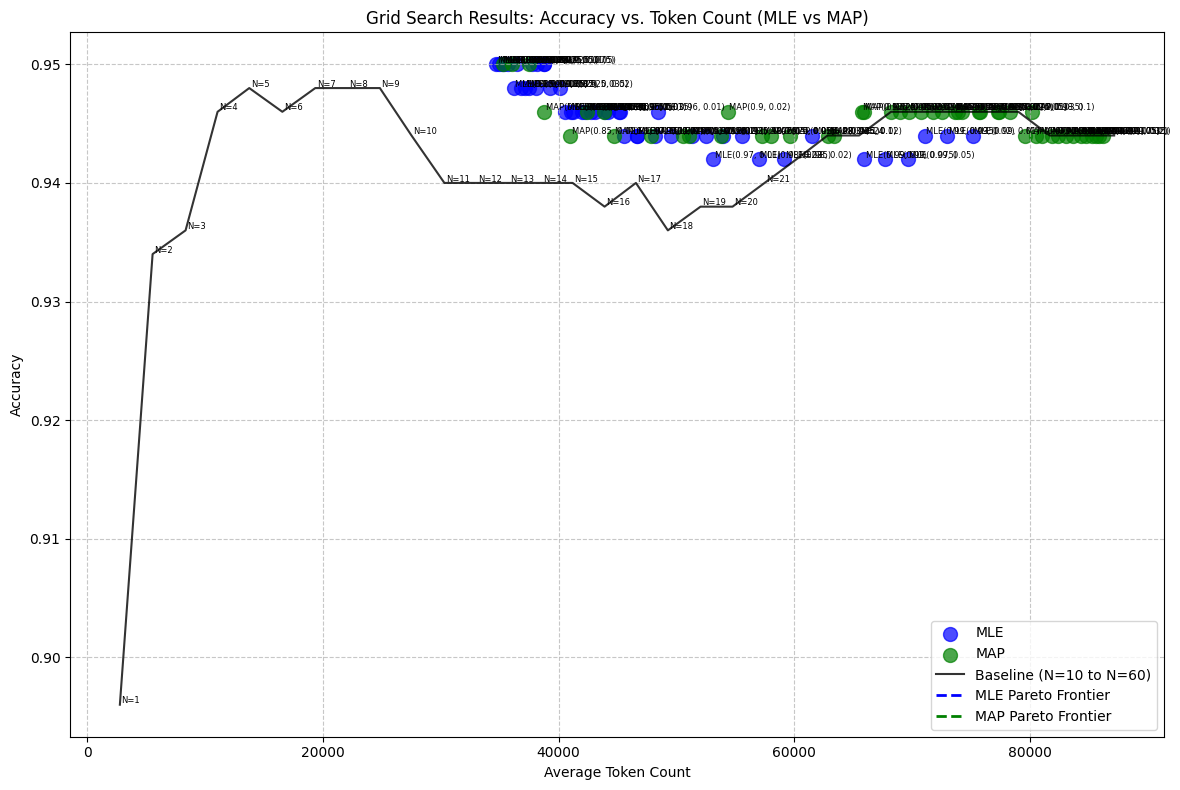


MLE Pareto-optimal configurations:
Target Score: 0.85, Percentile: 0.1, Accuracy: 0.9500, Avg Token Count: 34731.75

MAP Pareto-optimal configurations:
Target Score: 0.85, Percentile: 0.1, Accuracy: 0.9500, Avg Token Count: 35317.01


In [9]:
max_N_panel = 32
print("Target Score Panel:", target_score_panel_values)
print("Percentile Panel:", percentile_panel_values)
print("Max N:", max_N_panel)

# Evaluate MLE results
print("\nEvaluating MLE Results...")
truncated_normal_params_all = mle_estimated_params
mle_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MLE)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MLE Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MLE - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MLE - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        mle_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MLE_results_{max_N_panel}.json', 'w') as f:
    json.dump(mle_grid_search_results, f)


# Evaluate MAP results
print("\nEvaluating MAP Results...")
truncated_normal_params_all = map_estimated_params
map_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MAP)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MAP Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MAP - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MAP - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        map_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MAP_results_{max_N_panel}.json', 'w') as f:
    json.dump(map_grid_search_results, f)

plot_mle_map_optscale(mle_grid_search_results, map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel)

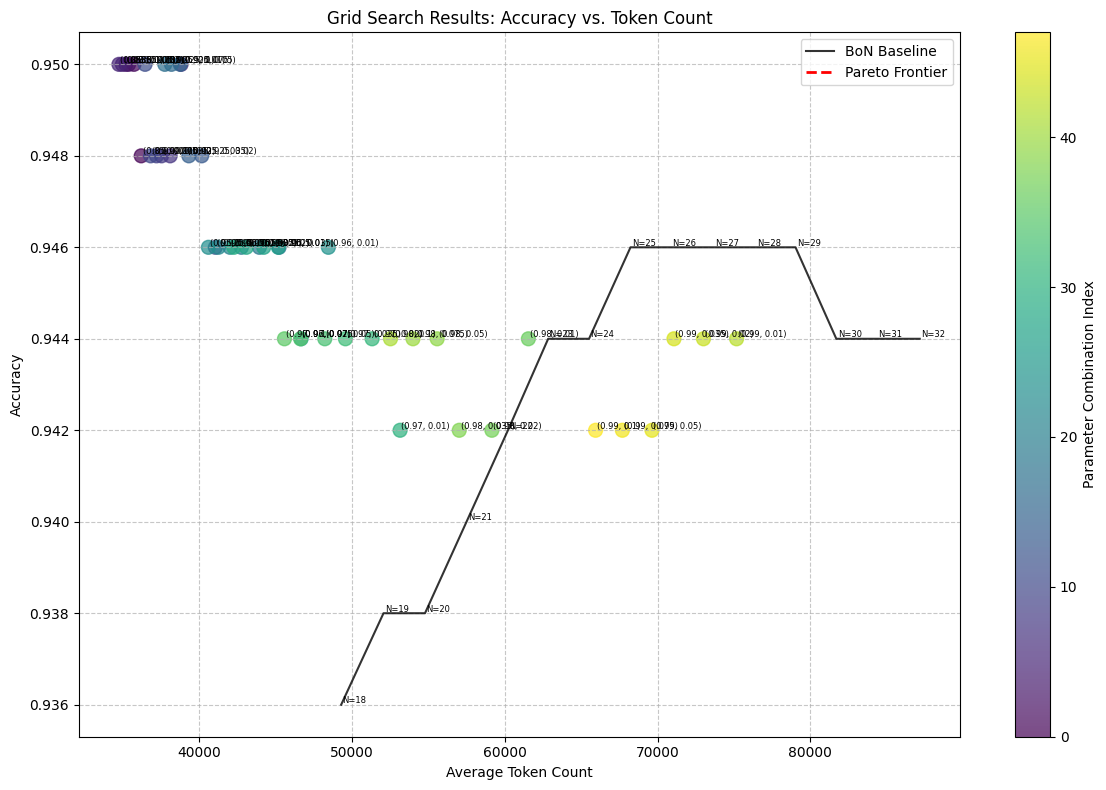

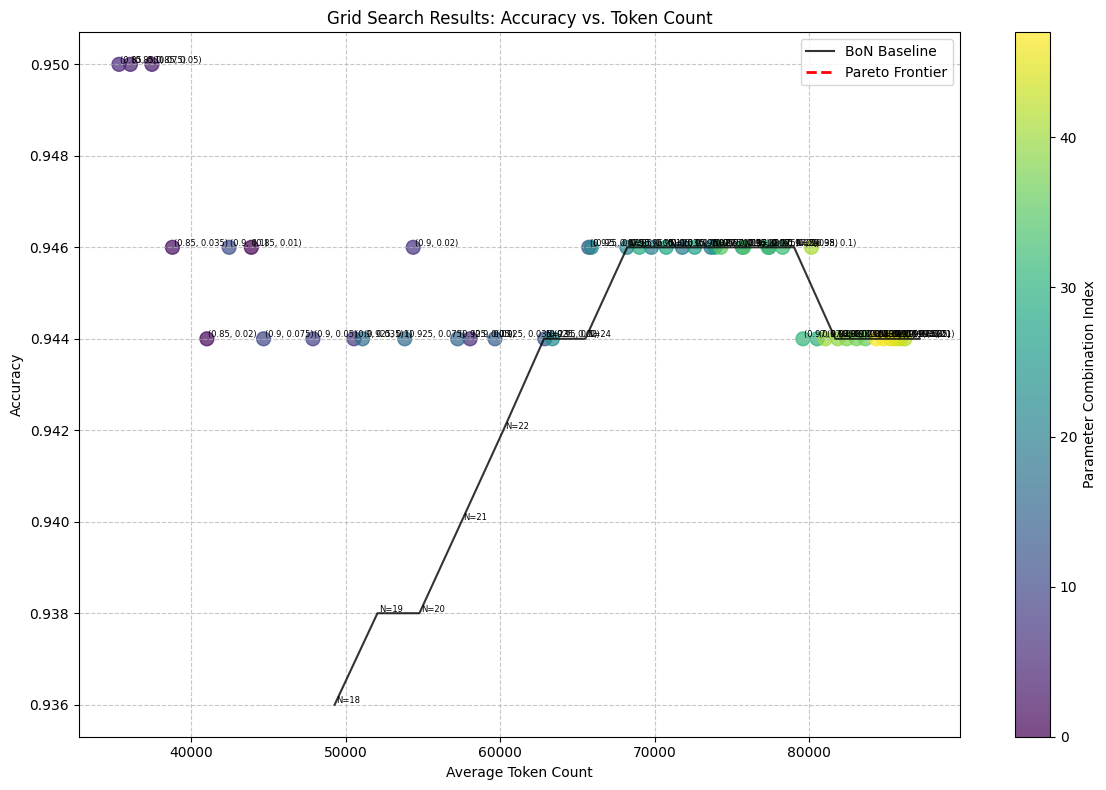

In [10]:
plot_optscale_start(mle_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel, 17)
plot_optscale_start(map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel, 17)

In [11]:
peek_number = 20

mle_estimated_params = []  # Store MLE estimates
map_estimated_params = []  # Store MAP estimates
predictor_params = []      # Store predictor's estimates

for i, (score, prediction) in enumerate(zip(val_scores, val_labels)):
    peek_data = np.array(score[0][:peek_number])
    
    # Store predictor's parameters
    prior_mu, prior_sigma = prediction
    predictor_params.append((prior_mu, prior_sigma))
    
    # MLE estimation with limited data
    initial_mu = np.mean(peek_data)
    initial_sigma = np.std(peek_data)
    mle_result = minimize(
        lambda params: neg_log_likelihood(params, peek_data),
        [initial_mu, initial_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    mle_mu, mle_sigma = mle_result.x
    mle_estimated_params.append((mle_mu, mle_sigma))
    
    # MAP estimation with limited data
    map_result = minimize(
        lambda params: neg_log_posterior(
            params, 
            peek_data, 
            prior_mu=prior_mu, 
            prior_sigma=prior_sigma
        ),
        [prior_mu, prior_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    map_mu, map_sigma = map_result.x
    map_estimated_params.append((map_mu, map_sigma))
    
    # Print comparison for first 50 examples
    if i < 50:
        gt_mu, gt_sigma = original_params_compare[i]
        print(f"{i:<4} {prior_mu:11.4f} {prior_sigma:11.4f} {mle_mu:9.4f} {mle_sigma:9.4f} "
              f"{map_mu:9.4f} {map_sigma:9.4f} {gt_mu:9.4f} {gt_sigma:9.4f}")

# Call the function to perform the analysis
analyze_estimation_performance(predictor_params, mle_estimated_params, map_estimated_params, original_params_compare)


0         0.6015      0.1227    0.9522    0.0195    0.8677    0.4633    0.9559    0.0145
1         0.4543      0.0766   13.2290    0.7892    0.9091    0.0596    0.9781    0.0432
2         0.6429      0.1356    0.9660    0.0172    0.9655    0.0173    0.9637    0.0222
3         0.4399      0.0769    0.9667    0.0149    0.9627    0.0145    0.9713    0.0204
4         0.4217      0.1085    8.7637    0.3726    0.8433    0.1195   30.9907    0.8595
5         0.4133      0.0200    0.9925    0.0126    0.9575    0.1732    1.1051    0.0412
6         0.5740      0.1303   23.6939    1.0157    0.8339    0.4720   41.5896    1.1720
7         0.5280      0.0904    0.9743    0.0279    0.7390    0.4446    0.9732    0.0181
8         0.4172      0.0738    0.9303    0.0210    0.8636    0.0564    0.9309    0.0216
9         0.5581      0.1733    0.9786    0.0071    0.9661    0.0241    1.0747    0.0605
10        0.4970      0.1497    1.6565    0.2858    0.8709    0.1098    1.6000    0.2797
11        0.3311     

Target Score Panel: [0.85, 0.9, 0.925, 0.95, 0.96, 0.97, 0.98, 0.99]
Percentile Panel: [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
Max N: 64

Evaluating MLE Results...


Target Score (MLE):   0%|          | 0/8 [00:00<?, ?it/s]

MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 29, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 54, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 45, 20, 20, 21, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 

MLE - Target Score: 0.85, Percentile: 0.01
MLE - Accuracy: 0.9420, Average Token Count: 68271.47
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 46, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 39, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.85, Percentile: 0.02
MLE - Accuracy: 0.9420, Average Token Count: 67464.79
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 40, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 33, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.85, Percentile: 0.035
MLE - Accuracy: 0.9420, Average Token Count: 66871.42
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 35, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

MLE - Target Score: 0.85, Percentile: 0.05
MLE - Accuracy: 0.9420, Average Token Count: 66370.91
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 31, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.85, Percentile: 0.075
MLE - Accuracy: 0.9420, Average Token Count: 65714.34
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 58, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

Target Score (MLE):  12%|█▎        | 1/8 [00:09<01:08,  9.78s/it]

MLE - Target Score: 0.85, Percentile: 0.1
MLE - Accuracy: 0.9420, Average Token Count: 65086.80


MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 61, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 46, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 44, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 

MLE - Target Score: 0.9, Percentile: 0.01
MLE - Accuracy: 0.9420, Average Token Count: 73211.04
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 52, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 39, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 38, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 

MLE - Target Score: 0.9, Percentile: 0.02
MLE - Accuracy: 0.9420, Average Token Count: 72071.42
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 45, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 34, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 

MLE - Target Score: 0.9, Percentile: 0.035
MLE - Accuracy: 0.9420, Average Token Count: 71299.35
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 40, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 30, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 29, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.9, Percentile: 0.05
MLE - Accuracy: 0.9420, Average Token Count: 70867.96
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 35, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 26, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 

MLE - Target Score: 0.9, Percentile: 0.075
MLE - Accuracy: 0.9420, Average Token Count: 70422.40
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 31, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 23, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

Target Score (MLE):  25%|██▌       | 2/8 [00:20<01:02, 10.36s/it]

MLE - Target Score: 0.9, Percentile: 0.1
MLE - Accuracy: 0.9420, Average Token Count: 70129.20


MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 20, 20, 20, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 38, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 40, 20, 20, 20, 30, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 

MLE - Target Score: 0.925, Percentile: 0.01
MLE - Accuracy: 0.9400, Average Token Count: 76122.82
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 33, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 34, 20, 20, 20, 25, 20, 20, 20, 20, 20, 20, 20

MLE - Target Score: 0.925, Percentile: 0.02
MLE - Accuracy: 0.9400, Average Token Count: 75228.89
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 55, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 28, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 63, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 29, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20

MLE - Target Score: 0.925, Percentile: 0.035
MLE - Accuracy: 0.9440, Average Token Count: 74356.14
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 49, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 57, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 26, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2

MLE - Target Score: 0.925, Percentile: 0.05
MLE - Accuracy: 0.9440, Average Token Count: 73747.03
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 56, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 43, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 49, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

MLE - Target Score: 0.925, Percentile: 0.075
MLE - Accuracy: 0.9420, Average Token Count: 72829.12
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 49, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 38, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 44, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2

Target Score (MLE):  38%|███▊      | 3/8 [00:32<00:54, 10.88s/it]

MLE - Target Score: 0.925, Percentile: 0.1
MLE - Accuracy: 0.9420, Average Token Count: 72183.59


MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 41, 20, 20, 20, 20, 20, 20, 20, 43, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 42, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 31, 20, 20, 20, 64, 20, 25, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 28, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 52, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 

MLE - Target Score: 0.95, Percentile: 0.01
MLE - Accuracy: 0.9400, Average Token Count: 80899.01
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 59, 35, 20, 20, 20, 20, 20, 20, 20, 37, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 36, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 27, 20, 20, 20, 64, 20, 22, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 56, 20, 20, 20, 20, 64, 23, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 60, 20, 20, 20, 44, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.95, Percentile: 0.02
MLE - Accuracy: 0.9400, Average Token Count: 79693.78
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 51, 30, 20, 20, 20, 20, 20, 20, 20, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 31, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 23, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 48, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 51, 20, 20, 20, 38, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.95, Percentile: 0.035
MLE - Accuracy: 0.9400, Average Token Count: 78313.12
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 45, 27, 20, 20, 20, 20, 20, 20, 20, 28, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 28, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 21, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 43, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 46, 20, 20, 20, 34, 20, 20, 20, 20, 20, 20, 20

MLE - Target Score: 0.95, Percentile: 0.05
MLE - Accuracy: 0.9400, Average Token Count: 77450.67
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 39, 23, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 60, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 38, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 40, 20, 20, 20, 30, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.95, Percentile: 0.075
MLE - Accuracy: 0.9400, Average Token Count: 76511.48
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 35, 21, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 53, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 33, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 35, 20, 20, 20, 26, 20, 20, 20, 20, 20, 20, 20

Target Score (MLE):  50%|█████     | 4/8 [00:45<00:47, 11.91s/it]

MLE - Target Score: 0.95, Percentile: 0.1
MLE - Accuracy: 0.9400, Average Token Count: 75785.99


MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 59, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 52, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 21, 20, 20, 20, 20, 64, 52, 20, 20, 20, 20, 20, 20, 20, 56, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 57, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 22, 64, 40, 20, 20, 20, 64, 20, 32, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 36, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 30, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 26, 20, 20, 20, 20, 

MLE - Target Score: 0.96, Percentile: 0.01
MLE - Accuracy: 0.9400, Average Token Count: 83188.32
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 51, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 44, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 45, 20, 20, 20, 20, 20, 20, 20, 47, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 48, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 34, 20, 20, 20, 64, 20, 27, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 31, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 59, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.96, Percentile: 0.02
MLE - Accuracy: 0.9400, Average Token Count: 81775.17
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 43, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 38, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 38, 20, 20, 20, 20, 20, 20, 20, 41, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 41, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 29, 20, 20, 20, 64, 20, 23, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 26, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 51, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.96, Percentile: 0.035
MLE - Accuracy: 0.9400, Average Token Count: 80871.32
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 39, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 34, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 34, 20, 20, 20, 20, 20, 20, 20, 36, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 37, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 26, 20, 20, 20, 64, 20, 21, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 58, 20, 20, 20, 20, 64, 24, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 61, 20, 20, 20, 45, 20, 20, 20, 20, 20, 20, 20

MLE - Target Score: 0.96, Percentile: 0.05
MLE - Accuracy: 0.9400, Average Token Count: 80040.56
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 34, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 30, 20, 20, 20, 20, 20, 20, 20, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 23, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 50, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 53, 20, 20, 20, 39, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.96, Percentile: 0.075
MLE - Accuracy: 0.9400, Average Token Count: 78755.69
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 30, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 26, 20, 20, 20, 20, 20, 20, 20, 28, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 29, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 44, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 47, 20, 20, 20, 35, 20, 20, 20, 20, 20, 20, 20

Target Score (MLE):  62%|██████▎   | 5/8 [00:59<00:38, 12.81s/it]

MLE - Target Score: 0.96, Percentile: 0.1
MLE - Accuracy: 0.9400, Average Token Count: 77845.42


MLE Min N Required [25, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 27, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 64, 30, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 32, 21, 58, 20, 20, 20, 20, 64, 64, 29, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 31, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 64, 64, 20, 30, 64, 55, 20, 27, 20, 64, 31, 43, 20, 20, 64, 20, 64, 20, 20, 26, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 50, 20, 20, 64, 20, 22, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 64, 64, 20, 24, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 33, 20, 20, 20, 20, 20, 41, 20, 20, 20, 20, 23, 20, 64, 20, 20, 20, 36, 20, 20, 20, 20, 

MLE - Target Score: 0.97, Percentile: 0.01
MLE - Accuracy: 0.9400, Average Token Count: 88478.03
MLE Min N Required [22, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 27, 20, 49, 20, 20, 20, 20, 64, 61, 25, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 64, 64, 20, 25, 64, 47, 20, 23, 20, 64, 26, 37, 20, 20, 64, 20, 64, 20, 20, 22, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 42, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 57, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.97, Percentile: 0.02
MLE - Accuracy: 0.9400, Average Token Count: 85925.04
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 23, 20, 42, 20, 20, 20, 20, 64, 52, 22, 20, 20, 20, 20, 20, 20, 56, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 59, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 22, 64, 40, 20, 20, 20, 64, 22, 31, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 36, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 59, 20, 20, 20, 64, 20, 49, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.97, Percentile: 0.035
MLE - Accuracy: 0.9400, Average Token Count: 84082.92
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 21, 20, 38, 20, 20, 20, 20, 64, 47, 20, 20, 20, 20, 20, 20, 20, 50, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 53, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 36, 20, 20, 20, 64, 20, 28, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 33, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 53, 20, 20, 20, 64, 20, 44, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20

MLE - Target Score: 0.97, Percentile: 0.05
MLE - Accuracy: 0.9400, Average Token Count: 83057.75
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 33, 20, 20, 20, 20, 64, 41, 20, 20, 20, 20, 20, 20, 20, 43, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 46, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 31, 20, 20, 20, 64, 20, 24, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 28, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 46, 20, 20, 20, 64, 20, 38, 64, 20, 20, 20, 56, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.97, Percentile: 0.075
MLE - Accuracy: 0.9400, Average Token Count: 81983.30
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 29, 20, 20, 20, 20, 64, 36, 20, 20, 20, 20, 20, 20, 20, 38, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 41, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 64, 28, 20, 20, 20, 64, 20, 22, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 63, 20, 20, 20, 20, 64, 25, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 41, 20, 20, 20, 64, 20, 34, 64, 20, 20, 20, 50, 20, 20, 20, 20, 20, 20, 20

Target Score (MLE):  75%|███████▌  | 6/8 [01:17<00:28, 14.33s/it]

MLE - Target Score: 0.97, Percentile: 0.1
MLE - Accuracy: 0.9400, Average Token Count: 81332.08


MLE Min N Required [64, 20, 23, 25, 20, 20, 20, 20, 64, 20, 25, 20, 20, 20, 23, 20, 20, 23, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 50, 20, 20, 37, 20, 20, 20, 20, 20, 20, 20, 20, 45, 20, 20, 20, 20, 22, 20, 20, 20, 20, 34, 26, 20, 36, 20, 29, 20, 36, 20, 20, 64, 20, 21, 20, 20, 20, 20, 20, 20, 20, 34, 64, 44, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20, 20, 64, 64, 31, 64, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 48, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 25, 20, 20, 20, 20, 21, 39, 21, 64, 64, 20, 45, 64, 64, 20, 64, 20, 64, 64, 64, 22, 20, 64, 20, 64, 20, 20, 39, 20, 20, 20, 20, 64, 20, 20, 24, 27, 64, 64, 20, 20, 64, 20, 32, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 26, 64, 20, 64, 64, 25, 36, 20, 64, 20, 21, 20, 25, 27, 20, 20, 20, 34, 49, 21, 20, 20, 20, 20, 64, 20, 20, 20, 20, 41, 20, 64, 20, 20, 20, 55, 20, 20, 20, 32, 

MLE - Target Score: 0.98, Percentile: 0.01
MLE - Accuracy: 0.9420, Average Token Count: 100431.14
MLE Min N Required [57, 20, 20, 22, 20, 20, 20, 20, 64, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 61, 20, 20, 20, 20, 64, 20, 20, 43, 20, 20, 32, 20, 20, 20, 20, 20, 20, 20, 20, 38, 20, 20, 20, 20, 20, 20, 20, 20, 20, 29, 22, 20, 31, 20, 25, 20, 31, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 29, 64, 38, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 64, 64, 27, 64, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 41, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 22, 20, 20, 20, 20, 20, 34, 20, 64, 64, 20, 39, 64, 64, 20, 64, 20, 64, 64, 56, 20, 20, 64, 20, 64, 20, 20, 33, 20, 20, 20, 20, 64, 20, 20, 20, 23, 64, 64, 20, 20, 64, 20, 28, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 22, 64, 20, 64, 64, 22, 31, 20, 64, 20, 20, 20, 21, 23, 20, 20

MLE - Target Score: 0.98, Percentile: 0.02
MLE - Accuracy: 0.9400, Average Token Count: 96610.19
MLE Min N Required [49, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 52, 20, 20, 20, 20, 62, 20, 20, 37, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 33, 20, 20, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20, 27, 20, 22, 20, 26, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 25, 64, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 23, 64, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 35, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 29, 20, 64, 64, 20, 33, 64, 62, 20, 64, 20, 64, 64, 48, 20, 20, 64, 20, 64, 20, 20, 28, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 57, 20, 20, 64, 20, 24, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 64, 64, 20, 26, 20, 64, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.98, Percentile: 0.035
MLE - Accuracy: 0.9400, Average Token Count: 93582.03
MLE Min N Required [44, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 47, 20, 20, 20, 20, 55, 20, 20, 33, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 29, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 24, 20, 20, 20, 24, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 64, 29, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 64, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 32, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 64, 64, 20, 30, 64, 56, 20, 64, 20, 64, 60, 43, 20, 20, 64, 20, 64, 20, 20, 25, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 51, 20, 20, 64, 20, 21, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 64, 64, 20, 24, 20, 64, 20, 20, 20, 20, 20, 20, 20

MLE - Target Score: 0.98, Percentile: 0.05
MLE - Accuracy: 0.9400, Average Token Count: 91472.10
MLE Min N Required [38, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 40, 20, 20, 20, 20, 48, 20, 20, 28, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 21, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 64, 20, 20, 20, 20, 64, 62, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 64, 64, 20, 26, 64, 48, 20, 56, 20, 64, 52, 37, 20, 20, 64, 20, 64, 20, 20, 22, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 44, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 64, 64, 20, 21, 20, 64, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.98, Percentile: 0.075
MLE - Accuracy: 0.9400, Average Token Count: 89012.88
MLE Min N Required [34, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 36, 20, 20, 20, 20, 43, 20, 20, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 64, 20, 20, 20, 20, 64, 55, 64, 20, 20, 20, 20, 20, 20, 59, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 23, 64, 43, 20, 50, 20, 64, 46, 33, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 39, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 64, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20

Target Score (MLE):  88%|████████▊ | 7/8 [01:38<00:16, 16.69s/it]

MLE - Target Score: 0.98, Percentile: 0.1
MLE - Accuracy: 0.9400, Average Token Count: 87389.24


MLE Min N Required [64, 24, 64, 64, 20, 20, 21, 34, 64, 64, 50, 20, 53, 64, 64, 20, 20, 45, 31, 28, 39, 20, 20, 27, 64, 20, 20, 64, 20, 64, 21, 52, 64, 20, 20, 64, 36, 20, 26, 61, 20, 60, 20, 56, 64, 27, 64, 64, 20, 64, 35, 20, 24, 20, 64, 64, 20, 64, 33, 64, 40, 64, 21, 22, 64, 20, 42, 20, 20, 20, 58, 20, 20, 20, 64, 64, 64, 20, 20, 64, 20, 20, 20, 25, 51, 20, 20, 20, 64, 64, 62, 64, 20, 26, 26, 20, 64, 64, 64, 20, 20, 20, 26, 21, 39, 64, 20, 20, 20, 20, 20, 20, 20, 35, 20, 20, 20, 64, 20, 64, 20, 20, 20, 29, 20, 20, 20, 20, 39, 20, 20, 20, 20, 20, 20, 20, 64, 20, 39, 50, 20, 20, 20, 23, 43, 64, 41, 64, 64, 20, 64, 64, 64, 43, 64, 20, 64, 64, 64, 50, 35, 64, 20, 64, 20, 20, 64, 20, 21, 20, 20, 64, 34, 20, 48, 64, 64, 64, 20, 64, 64, 20, 64, 25, 20, 64, 64, 36, 38, 49, 40, 33, 20, 28, 64, 20, 20, 20, 20, 34, 20, 43, 64, 20, 20, 52, 64, 49, 64, 64, 50, 64, 20, 64, 64, 53, 39, 49, 54, 45, 27, 35, 64, 64, 64, 20, 20, 20, 40, 64, 21, 20, 24, 20, 64, 20, 64, 20, 30, 20, 64, 20, 20, 20, 64, 

MLE - Target Score: 0.99, Percentile: 0.01
MLE - Accuracy: 0.9420, Average Token Count: 127207.64
MLE Min N Required [64, 20, 64, 64, 20, 20, 20, 29, 64, 64, 43, 20, 45, 64, 64, 20, 20, 39, 26, 23, 34, 20, 20, 23, 64, 20, 20, 64, 20, 64, 20, 44, 64, 20, 20, 64, 31, 20, 22, 52, 20, 51, 20, 47, 64, 23, 64, 64, 20, 64, 30, 20, 20, 20, 64, 64, 20, 62, 28, 64, 34, 64, 20, 20, 64, 20, 36, 20, 20, 20, 50, 20, 20, 20, 63, 64, 64, 20, 20, 64, 20, 20, 20, 21, 44, 20, 20, 20, 64, 64, 53, 64, 20, 22, 22, 20, 64, 64, 64, 20, 20, 20, 22, 20, 33, 64, 20, 20, 20, 20, 20, 20, 20, 30, 20, 20, 20, 64, 20, 64, 20, 20, 20, 25, 20, 20, 20, 20, 34, 20, 20, 20, 20, 20, 20, 20, 64, 20, 34, 43, 20, 20, 20, 20, 36, 64, 35, 64, 64, 20, 64, 64, 64, 36, 64, 20, 64, 64, 64, 42, 30, 64, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 29, 20, 41, 58, 64, 64, 20, 64, 64, 20, 55, 21, 20, 64, 64, 30, 32, 41, 34, 28, 20, 24, 64, 20, 20, 20, 20, 29, 20, 37, 64, 20, 20, 44, 64, 42, 64, 64, 43, 62, 20, 64, 64, 45, 34, 42, 46, 38, 23

MLE - Target Score: 0.99, Percentile: 0.02
MLE - Accuracy: 0.9420, Average Token Count: 122521.48
MLE Min N Required [64, 20, 58, 64, 20, 20, 20, 25, 64, 64, 37, 20, 39, 56, 64, 20, 20, 33, 23, 20, 29, 20, 20, 20, 64, 20, 20, 64, 20, 64, 20, 38, 64, 20, 20, 57, 27, 20, 20, 45, 20, 44, 20, 41, 64, 20, 64, 64, 20, 64, 26, 20, 20, 20, 64, 64, 20, 53, 24, 64, 29, 64, 20, 20, 64, 20, 31, 20, 20, 20, 43, 20, 20, 20, 54, 64, 64, 20, 20, 61, 20, 20, 20, 20, 37, 20, 20, 20, 64, 64, 46, 64, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 29, 64, 20, 20, 20, 20, 20, 20, 20, 26, 20, 20, 20, 64, 20, 64, 20, 20, 20, 21, 20, 20, 20, 20, 29, 20, 20, 20, 20, 20, 20, 20, 64, 20, 29, 37, 20, 20, 20, 20, 31, 59, 30, 64, 64, 20, 64, 64, 64, 31, 64, 20, 64, 64, 64, 36, 26, 64, 20, 64, 20, 20, 57, 20, 20, 20, 20, 64, 25, 20, 35, 50, 64, 64, 20, 64, 64, 20, 47, 20, 20, 64, 64, 26, 28, 36, 29, 24, 20, 21, 64, 20, 20, 20, 20, 25, 20, 31, 64, 20, 20, 38, 64, 36, 64, 64, 37, 53, 20, 64, 64, 39, 29, 36, 39, 33, 20

MLE - Target Score: 0.99, Percentile: 0.035
MLE - Accuracy: 0.9420, Average Token Count: 117683.98
MLE Min N Required [64, 20, 52, 64, 20, 20, 20, 22, 64, 63, 33, 20, 35, 50, 64, 20, 20, 30, 20, 20, 26, 20, 20, 20, 64, 20, 20, 64, 20, 64, 20, 34, 64, 20, 20, 51, 24, 20, 20, 40, 20, 39, 20, 36, 64, 20, 64, 64, 20, 64, 23, 20, 20, 20, 60, 64, 20, 47, 22, 64, 26, 64, 20, 20, 64, 20, 27, 20, 20, 20, 38, 20, 20, 20, 48, 64, 58, 20, 20, 55, 20, 20, 20, 20, 34, 20, 20, 20, 64, 64, 41, 64, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 26, 64, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 20, 20, 20, 20, 20, 20, 64, 20, 26, 33, 20, 20, 20, 20, 28, 53, 27, 64, 64, 20, 60, 64, 64, 28, 64, 20, 64, 64, 64, 33, 23, 64, 20, 64, 20, 20, 51, 20, 20, 20, 20, 64, 22, 20, 31, 45, 64, 64, 20, 64, 64, 20, 42, 20, 20, 64, 64, 23, 25, 32, 26, 22, 20, 20, 64, 20, 20, 20, 20, 23, 20, 28, 64, 20, 20, 34, 64, 32, 64, 64, 33, 48, 20, 64, 64, 35, 26, 32, 35, 29, 2

MLE - Target Score: 0.99, Percentile: 0.05
MLE - Accuracy: 0.9420, Average Token Count: 114314.93
MLE Min N Required [64, 20, 45, 57, 20, 20, 20, 20, 64, 54, 28, 20, 30, 43, 64, 20, 20, 26, 20, 20, 22, 20, 20, 20, 64, 20, 20, 55, 20, 64, 20, 29, 64, 20, 20, 44, 21, 20, 20, 35, 20, 34, 20, 32, 64, 20, 64, 64, 20, 64, 20, 20, 20, 20, 52, 64, 20, 41, 20, 64, 23, 64, 20, 20, 64, 20, 24, 20, 20, 20, 33, 20, 20, 20, 42, 64, 50, 20, 20, 47, 20, 20, 20, 20, 29, 20, 20, 20, 64, 64, 35, 64, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 22, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 58, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 64, 20, 22, 28, 20, 20, 20, 20, 24, 46, 23, 64, 64, 20, 52, 64, 64, 24, 64, 20, 64, 64, 64, 28, 20, 64, 20, 64, 20, 20, 44, 20, 20, 20, 20, 64, 20, 20, 27, 39, 64, 64, 20, 64, 64, 20, 36, 20, 20, 64, 64, 20, 22, 28, 22, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 24, 64, 20, 20, 29, 64, 28, 64, 64, 29, 41, 20, 64, 64, 30, 23, 28, 31, 25, 20

MLE - Target Score: 0.99, Percentile: 0.075
MLE - Accuracy: 0.9460, Average Token Count: 110000.66
MLE Min N Required [64, 20, 40, 51, 20, 20, 20, 20, 64, 48, 25, 20, 27, 38, 64, 20, 20, 23, 20, 20, 20, 20, 20, 20, 64, 20, 20, 49, 20, 64, 20, 26, 64, 20, 20, 39, 20, 20, 20, 31, 20, 30, 20, 28, 64, 20, 64, 64, 20, 58, 20, 20, 20, 20, 47, 64, 20, 36, 20, 64, 20, 64, 20, 20, 64, 20, 21, 20, 20, 20, 30, 20, 20, 20, 37, 64, 45, 20, 20, 42, 20, 20, 20, 20, 26, 20, 20, 20, 64, 64, 31, 64, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 51, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 25, 20, 20, 20, 20, 22, 41, 21, 64, 64, 20, 46, 64, 64, 22, 64, 20, 64, 64, 64, 25, 20, 64, 20, 64, 20, 20, 40, 20, 20, 20, 20, 64, 20, 20, 24, 34, 64, 64, 20, 64, 64, 20, 32, 20, 20, 64, 64, 20, 20, 25, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 22, 64, 20, 20, 26, 64, 25, 64, 64, 25, 37, 20, 64, 57, 27, 20, 25, 27, 23, 2

Target Score (MLE): 100%|██████████| 8/8 [02:12<00:00, 16.59s/it]


MLE - Target Score: 0.99, Percentile: 0.1
MLE - Accuracy: 0.9440, Average Token Count: 106680.05

Evaluating MAP Results...


Target Score (MAP):   0%|          | 0/8 [00:00<?, ?it/s]

MAP Min N Required [20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 21, 20, 24, 20, 20, 26, 26, 20, 29, 20, 20, 20, 28, 23, 22, 21, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 23, 21, 22, 32, 20, 20, 20, 28, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 21, 20, 20, 27, 20, 53, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 28, 25, 24, 20, 20, 28, 26, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 22, 20, 26, 20, 25, 20, 20, 20, 21, 27, 25, 20, 20, 28, 22, 20, 64, 25, 20, 20, 20, 20, 20, 26, 20, 20, 20, 20, 47, 20, 20, 23, 20, 20, 22, 25, 64, 20, 20, 22, 20, 64, 26, 64, 27, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 64, 20, 20, 24, 64, 28, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 23, 20, 22, 20, 23, 24, 20, 20, 22, 20, 20, 23, 20, 64, 20, 20, 20, 20, 20, 27, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 27, 21, 20, 20, 20, 22, 20, 20, 23, 20, 23, 64, 20, 20, 26, 20, 21, 20, 20, 20, 

MAP - Target Score: 0.85, Percentile: 0.01
MAP - Accuracy: 0.9440, Average Token Count: 70354.12
MAP Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 22, 22, 20, 25, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 23, 20, 45, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 21, 20, 20, 20, 24, 22, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 22, 20, 22, 20, 20, 20, 20, 23, 21, 20, 20, 24, 20, 20, 64, 22, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 40, 20, 20, 20, 20, 20, 20, 21, 64, 20, 20, 20, 20, 64, 22, 64, 23, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20,

MAP - Target Score: 0.85, Percentile: 0.02
MAP - Accuracy: 0.9420, Average Token Count: 68090.70
MAP Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 39, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 34, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MAP - Target Score: 0.85, Percentile: 0.035
MAP - Accuracy: 0.9420, Average Token Count: 67116.37
MAP Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 35, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 31, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

MAP - Target Score: 0.85, Percentile: 0.05
MAP - Accuracy: 0.9420, Average Token Count: 66664.42
MAP Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MAP - Target Score: 0.85, Percentile: 0.075
MAP - Accuracy: 0.9420, Average Token Count: 66047.67
MAP Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 57, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

Target Score (MAP):  12%|█▎        | 1/8 [00:17<02:00, 17.18s/it]

MAP - Target Score: 0.85, Percentile: 0.1
MAP - Accuracy: 0.9420, Average Token Count: 65427.26


MAP Min N Required [30, 20, 20, 20, 20, 20, 32, 37, 20, 20, 20, 20, 20, 33, 24, 23, 20, 21, 20, 28, 20, 33, 20, 32, 20, 20, 20, 20, 33, 20, 38, 20, 20, 41, 40, 20, 46, 20, 20, 20, 44, 37, 35, 33, 20, 40, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 35, 20, 32, 20, 20, 36, 33, 34, 64, 20, 20, 20, 46, 20, 20, 20, 20, 20, 20, 20, 22, 20, 32, 20, 20, 20, 38, 33, 20, 20, 43, 20, 64, 20, 20, 20, 20, 20, 20, 31, 20, 24, 20, 20, 20, 20, 44, 39, 37, 29, 20, 44, 41, 20, 20, 20, 31, 20, 38, 30, 20, 20, 20, 20, 34, 34, 41, 35, 40, 21, 20, 20, 33, 45, 40, 20, 20, 45, 34, 26, 64, 42, 20, 20, 32, 20, 23, 41, 20, 20, 31, 30, 64, 20, 20, 50, 20, 20, 34, 39, 64, 20, 20, 34, 20, 64, 41, 64, 43, 29, 20, 20, 20, 31, 38, 31, 20, 20, 20, 20, 64, 20, 20, 38, 64, 45, 20, 28, 31, 46, 28, 20, 24, 20, 20, 20, 35, 35, 20, 34, 20, 36, 39, 20, 31, 34, 20, 28, 36, 20, 64, 20, 20, 27, 30, 31, 43, 21, 33, 20, 20, 20, 20, 20, 20, 32, 20, 20, 41, 44, 33, 20, 20, 20, 34, 20, 20, 36, 20, 36, 64, 20, 20, 41, 20, 32, 20, 24, 20, 

MAP - Target Score: 0.9, Percentile: 0.01
MAP - Accuracy: 0.9440, Average Token Count: 85672.34
MAP Min N Required [25, 20, 20, 20, 20, 20, 27, 31, 20, 20, 20, 20, 20, 28, 21, 20, 20, 20, 20, 24, 20, 28, 20, 27, 20, 20, 20, 20, 28, 20, 32, 20, 20, 35, 34, 20, 39, 20, 20, 20, 37, 31, 30, 28, 20, 34, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 20, 27, 20, 20, 31, 28, 29, 59, 20, 20, 20, 40, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 20, 20, 32, 28, 20, 20, 36, 20, 64, 20, 20, 20, 20, 20, 20, 27, 20, 21, 20, 20, 20, 20, 38, 33, 32, 25, 20, 38, 35, 20, 20, 20, 27, 20, 33, 26, 20, 20, 20, 20, 29, 29, 35, 29, 34, 20, 20, 20, 28, 38, 34, 20, 20, 38, 29, 22, 64, 36, 20, 20, 27, 20, 20, 35, 20, 20, 26, 25, 64, 20, 20, 42, 20, 20, 29, 34, 64, 20, 20, 29, 20, 64, 35, 64, 37, 25, 20, 20, 20, 27, 32, 26, 20, 20, 20, 20, 64, 20, 20, 32, 64, 38, 20, 24, 26, 39, 24, 20, 21, 20, 20, 20, 30, 30, 20, 29, 20, 30, 33, 20, 27, 29, 20, 24, 30, 20, 64, 20, 20, 23, 25, 26, 36, 20, 28, 20, 20, 20, 20, 20, 20, 

MAP - Target Score: 0.9, Percentile: 0.02
MAP - Accuracy: 0.9460, Average Token Count: 80274.89
MAP Min N Required [22, 20, 20, 20, 20, 20, 23, 27, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 21, 20, 24, 20, 23, 20, 20, 20, 20, 24, 20, 28, 20, 20, 30, 29, 20, 34, 20, 20, 20, 32, 27, 25, 24, 20, 29, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 23, 20, 20, 26, 24, 25, 50, 20, 20, 20, 34, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 28, 24, 20, 20, 31, 20, 64, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 32, 28, 27, 21, 20, 32, 30, 20, 20, 20, 23, 20, 28, 22, 20, 20, 20, 20, 25, 25, 30, 25, 29, 20, 20, 20, 24, 33, 29, 20, 20, 33, 25, 20, 64, 31, 20, 20, 23, 20, 20, 30, 20, 20, 22, 22, 64, 20, 20, 36, 20, 20, 25, 29, 64, 20, 20, 25, 20, 64, 30, 64, 31, 21, 20, 20, 20, 23, 28, 23, 20, 20, 20, 20, 64, 20, 20, 28, 64, 33, 20, 21, 23, 34, 21, 20, 20, 20, 20, 20, 26, 26, 20, 25, 20, 26, 28, 20, 23, 25, 20, 21, 26, 20, 64, 20, 20, 20, 22, 23, 31, 20, 24, 20, 20, 20, 20, 20, 20, 

MAP - Target Score: 0.9, Percentile: 0.035
MAP - Accuracy: 0.9440, Average Token Count: 75979.79
MAP Min N Required [20, 20, 20, 20, 20, 20, 21, 24, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 21, 20, 21, 20, 20, 20, 20, 22, 20, 25, 20, 20, 27, 26, 20, 30, 20, 20, 20, 29, 24, 23, 22, 20, 26, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 21, 20, 20, 24, 22, 23, 45, 20, 20, 20, 30, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 25, 22, 20, 20, 28, 20, 64, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 29, 25, 24, 20, 20, 29, 27, 20, 20, 20, 20, 20, 25, 20, 20, 20, 20, 20, 22, 22, 27, 23, 26, 20, 20, 20, 22, 30, 26, 20, 20, 29, 22, 20, 64, 28, 20, 20, 21, 20, 20, 27, 20, 20, 20, 20, 64, 20, 20, 33, 20, 20, 23, 26, 64, 20, 20, 22, 20, 64, 27, 64, 28, 20, 20, 20, 20, 20, 25, 20, 20, 20, 20, 20, 64, 20, 20, 25, 64, 29, 20, 20, 20, 30, 20, 20, 20, 20, 20, 20, 23, 23, 20, 22, 20, 23, 25, 20, 20, 22, 20, 20, 23, 20, 64, 20, 20, 20, 20, 20, 28, 20, 22, 20, 20, 20, 20, 20, 20,

MAP - Target Score: 0.9, Percentile: 0.05
MAP - Accuracy: 0.9440, Average Token Count: 73311.00
MAP Min N Required [20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 23, 23, 20, 26, 20, 20, 20, 25, 21, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 39, 20, 20, 20, 26, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 24, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 25, 22, 21, 20, 20, 25, 23, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 23, 20, 23, 20, 20, 20, 20, 26, 23, 20, 20, 26, 20, 20, 64, 24, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 64, 20, 20, 28, 20, 20, 20, 22, 64, 20, 20, 20, 20, 64, 23, 64, 24, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 64, 20, 20, 21, 64, 25, 20, 20, 20, 26, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 

MAP - Target Score: 0.9, Percentile: 0.075
MAP - Accuracy: 0.9440, Average Token Count: 70844.84
MAP Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 23, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 35, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 22, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 23, 20, 20, 64, 21, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 64, 20, 20, 25, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 21, 64, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 23, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20,

Target Score (MAP):  25%|██▌       | 2/8 [00:40<02:03, 20.55s/it]

MAP - Target Score: 0.9, Percentile: 0.1
MAP - Accuracy: 0.9420, Average Token Count: 69722.60


MAP Min N Required [41, 20, 20, 20, 26, 20, 43, 50, 34, 20, 20, 20, 20, 44, 34, 32, 20, 30, 26, 39, 20, 44, 20, 43, 20, 20, 20, 20, 45, 20, 52, 20, 20, 55, 55, 20, 63, 20, 20, 20, 60, 50, 47, 45, 20, 57, 20, 20, 20, 20, 20, 24, 20, 29, 20, 20, 48, 21, 48, 20, 20, 49, 45, 47, 64, 26, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 31, 20, 46, 20, 20, 20, 51, 45, 22, 24, 58, 20, 64, 20, 20, 20, 20, 20, 20, 43, 20, 36, 20, 20, 20, 20, 61, 53, 51, 42, 20, 61, 56, 20, 20, 20, 42, 20, 52, 42, 20, 20, 20, 29, 46, 49, 56, 49, 55, 31, 20, 20, 45, 64, 55, 20, 20, 62, 46, 36, 64, 59, 20, 20, 43, 20, 34, 57, 20, 20, 42, 41, 64, 20, 20, 64, 28, 20, 47, 54, 64, 20, 26, 47, 20, 64, 56, 64, 58, 40, 20, 20, 20, 42, 51, 48, 20, 20, 20, 20, 64, 23, 20, 51, 64, 61, 29, 38, 42, 64, 39, 20, 37, 20, 20, 23, 47, 47, 20, 46, 20, 49, 53, 26, 42, 46, 20, 41, 48, 20, 64, 20, 20, 43, 41, 48, 59, 33, 45, 20, 20, 21, 21, 20, 20, 43, 20, 26, 56, 60, 45, 20, 20, 27, 46, 20, 20, 49, 20, 49, 64, 20, 20, 55, 20, 43, 23, 34, 20, 

MAP - Target Score: 0.925, Percentile: 0.01
MAP - Accuracy: 0.9440, Average Token Count: 102059.50
MAP Min N Required [35, 20, 20, 20, 22, 20, 37, 43, 29, 20, 20, 20, 20, 38, 29, 27, 20, 25, 22, 33, 20, 38, 20, 37, 20, 20, 20, 20, 38, 20, 44, 20, 20, 47, 47, 20, 54, 20, 20, 20, 51, 43, 40, 38, 20, 48, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20, 41, 20, 41, 20, 20, 41, 38, 40, 64, 22, 20, 20, 56, 20, 20, 20, 20, 20, 20, 20, 26, 20, 39, 20, 20, 20, 44, 39, 20, 20, 49, 20, 64, 20, 20, 20, 20, 20, 20, 36, 20, 30, 20, 20, 20, 20, 52, 45, 43, 36, 20, 52, 48, 20, 20, 20, 36, 20, 45, 36, 20, 20, 20, 24, 39, 42, 48, 42, 47, 26, 20, 20, 38, 54, 46, 20, 20, 53, 40, 31, 64, 50, 20, 20, 37, 20, 29, 48, 20, 20, 35, 34, 64, 20, 20, 64, 24, 20, 40, 46, 64, 20, 22, 40, 20, 64, 48, 64, 50, 34, 20, 20, 20, 36, 44, 41, 20, 20, 20, 20, 64, 20, 20, 44, 64, 52, 24, 33, 35, 64, 33, 20, 31, 20, 20, 20, 40, 40, 20, 39, 20, 42, 45, 22, 36, 39, 20, 35, 41, 20, 64, 20, 20, 37, 35, 40, 50, 28, 38, 20, 20, 20, 20, 20, 2

MAP - Target Score: 0.925, Percentile: 0.02
MAP - Accuracy: 0.9440, Average Token Count: 94136.35
MAP Min N Required [30, 20, 20, 20, 20, 20, 32, 37, 25, 20, 20, 20, 20, 32, 25, 24, 20, 22, 20, 28, 20, 32, 20, 32, 20, 20, 20, 20, 33, 20, 38, 20, 20, 40, 40, 20, 46, 20, 20, 20, 44, 37, 35, 33, 20, 41, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 35, 20, 35, 20, 20, 36, 33, 34, 64, 20, 20, 20, 48, 20, 20, 20, 20, 20, 20, 20, 23, 20, 34, 20, 20, 20, 38, 33, 20, 20, 42, 20, 64, 20, 20, 20, 20, 20, 20, 31, 20, 26, 20, 20, 20, 20, 44, 39, 37, 31, 20, 44, 41, 20, 20, 20, 31, 20, 38, 31, 20, 20, 20, 21, 34, 36, 41, 36, 40, 23, 20, 20, 33, 46, 40, 20, 20, 45, 34, 26, 64, 43, 20, 20, 32, 20, 25, 42, 20, 20, 30, 30, 64, 20, 20, 60, 21, 20, 34, 40, 64, 20, 20, 34, 20, 64, 41, 64, 43, 29, 20, 20, 20, 31, 37, 35, 20, 20, 20, 20, 64, 20, 20, 38, 64, 44, 21, 28, 30, 64, 28, 20, 27, 20, 20, 20, 35, 35, 20, 34, 20, 36, 39, 20, 31, 33, 20, 30, 35, 20, 64, 20, 20, 31, 30, 35, 43, 24, 33, 20, 20, 20, 20, 20, 20

MAP - Target Score: 0.925, Percentile: 0.035
MAP - Accuracy: 0.9440, Average Token Count: 87797.93
MAP Min N Required [27, 20, 20, 20, 20, 20, 28, 33, 22, 20, 20, 20, 20, 29, 22, 21, 20, 20, 20, 25, 20, 29, 20, 28, 20, 20, 20, 20, 30, 20, 34, 20, 20, 36, 36, 20, 41, 20, 20, 20, 39, 33, 31, 29, 20, 37, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 31, 20, 31, 20, 20, 32, 29, 31, 64, 20, 20, 20, 43, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 20, 20, 20, 34, 30, 20, 20, 38, 20, 64, 20, 20, 20, 20, 20, 20, 28, 20, 23, 20, 20, 20, 20, 40, 35, 33, 28, 20, 40, 37, 20, 20, 20, 28, 20, 34, 28, 20, 20, 20, 20, 30, 32, 37, 32, 36, 20, 20, 20, 30, 42, 36, 20, 20, 40, 30, 24, 64, 38, 20, 20, 28, 20, 22, 37, 20, 20, 27, 27, 64, 20, 20, 53, 20, 20, 31, 35, 64, 20, 20, 30, 20, 64, 37, 64, 38, 26, 20, 20, 20, 28, 34, 32, 20, 20, 20, 20, 64, 20, 20, 34, 64, 40, 20, 25, 27, 58, 25, 20, 24, 20, 20, 20, 31, 31, 20, 30, 20, 32, 35, 20, 28, 30, 20, 27, 32, 20, 64, 20, 20, 28, 27, 31, 38, 22, 29, 20, 20, 20, 20, 20, 2

MAP - Target Score: 0.925, Percentile: 0.05
MAP - Accuracy: 0.9440, Average Token Count: 83900.05
MAP Min N Required [23, 20, 20, 20, 20, 20, 25, 29, 20, 20, 20, 20, 20, 25, 20, 20, 20, 20, 20, 22, 20, 25, 20, 25, 20, 20, 20, 20, 26, 20, 29, 20, 20, 31, 31, 20, 36, 20, 20, 20, 34, 28, 27, 25, 20, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 27, 20, 20, 28, 25, 27, 63, 20, 20, 20, 37, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 20, 20, 29, 26, 20, 20, 33, 20, 64, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 34, 30, 29, 24, 20, 34, 32, 20, 20, 20, 24, 20, 30, 24, 20, 20, 20, 20, 26, 28, 32, 28, 31, 20, 20, 20, 26, 36, 31, 20, 20, 35, 26, 21, 64, 33, 20, 20, 25, 20, 20, 32, 20, 20, 24, 23, 64, 20, 20, 46, 20, 20, 26, 31, 64, 20, 20, 26, 20, 64, 32, 64, 33, 23, 20, 20, 20, 24, 29, 27, 20, 20, 20, 20, 64, 20, 20, 29, 64, 34, 20, 22, 24, 51, 22, 20, 21, 20, 20, 20, 27, 27, 20, 26, 20, 28, 30, 20, 24, 26, 20, 23, 27, 20, 64, 20, 20, 24, 23, 27, 33, 20, 25, 20, 20, 20, 20, 20, 20

MAP - Target Score: 0.925, Percentile: 0.075
MAP - Accuracy: 0.9460, Average Token Count: 79443.41
MAP Min N Required [21, 20, 20, 20, 20, 20, 22, 25, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 22, 20, 22, 20, 20, 20, 20, 23, 20, 26, 20, 20, 28, 28, 20, 32, 20, 20, 20, 30, 25, 24, 23, 20, 29, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 24, 20, 20, 25, 23, 24, 56, 20, 20, 20, 33, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 26, 23, 20, 20, 29, 20, 64, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 31, 27, 26, 21, 20, 31, 28, 20, 20, 20, 21, 20, 26, 21, 20, 20, 20, 20, 23, 25, 28, 25, 28, 20, 20, 20, 23, 32, 28, 20, 20, 31, 23, 20, 64, 30, 20, 20, 22, 20, 20, 29, 20, 20, 21, 21, 64, 20, 20, 41, 20, 20, 24, 27, 64, 20, 20, 24, 20, 64, 28, 64, 29, 20, 20, 20, 20, 21, 26, 24, 20, 20, 20, 20, 64, 20, 20, 26, 64, 31, 20, 20, 21, 45, 20, 20, 20, 20, 20, 20, 24, 24, 20, 23, 20, 25, 27, 20, 21, 23, 20, 21, 24, 20, 64, 20, 20, 22, 21, 24, 30, 20, 23, 20, 20, 20, 20, 20, 2

Target Score (MAP):  38%|███▊      | 3/8 [01:09<02:02, 24.49s/it]

MAP - Target Score: 0.925, Percentile: 0.1
MAP - Accuracy: 0.9460, Average Token Count: 76284.33


MAP Min N Required [62, 22, 20, 20, 44, 22, 64, 64, 64, 20, 33, 20, 20, 64, 53, 52, 20, 48, 45, 59, 20, 64, 20, 64, 20, 20, 20, 31, 64, 20, 64, 20, 20, 64, 64, 22, 64, 20, 20, 20, 64, 64, 64, 64, 20, 64, 20, 20, 20, 20, 20, 37, 20, 50, 41, 20, 64, 34, 64, 20, 23, 64, 64, 64, 64, 45, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 48, 20, 64, 20, 20, 20, 64, 64, 40, 38, 64, 20, 64, 20, 23, 20, 20, 20, 20, 64, 64, 58, 20, 20, 20, 32, 64, 64, 64, 64, 26, 64, 64, 20, 32, 20, 64, 20, 64, 64, 23, 21, 23, 51, 64, 64, 64, 64, 64, 52, 20, 20, 64, 64, 64, 20, 20, 64, 64, 57, 64, 64, 22, 20, 64, 20, 55, 64, 20, 20, 63, 62, 64, 20, 26, 64, 47, 20, 64, 64, 64, 20, 43, 64, 20, 64, 64, 64, 64, 61, 23, 20, 20, 64, 64, 64, 20, 20, 20, 20, 64, 40, 20, 64, 64, 64, 46, 59, 64, 64, 59, 20, 64, 20, 20, 42, 64, 64, 31, 64, 20, 64, 64, 49, 64, 64, 20, 64, 64, 20, 64, 20, 20, 64, 62, 64, 64, 59, 64, 27, 20, 35, 34, 20, 20, 64, 20, 42, 64, 64, 64, 20, 20, 46, 64, 20, 20, 64, 20, 64, 64, 20, 20, 64, 31, 64, 38, 53, 20, 

MAP - Target Score: 0.95, Percentile: 0.01
MAP - Accuracy: 0.9440, Average Token Count: 125941.64
MAP Min N Required [53, 20, 20, 20, 38, 20, 57, 64, 64, 20, 28, 20, 20, 57, 45, 44, 20, 41, 38, 50, 20, 58, 20, 57, 20, 20, 20, 26, 59, 20, 64, 20, 20, 64, 64, 20, 64, 20, 20, 20, 64, 64, 61, 58, 20, 64, 20, 20, 20, 20, 20, 32, 20, 42, 35, 20, 62, 29, 64, 20, 20, 63, 58, 61, 64, 38, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 41, 20, 64, 20, 20, 20, 64, 59, 34, 32, 64, 20, 64, 20, 20, 20, 20, 20, 20, 55, 60, 50, 20, 20, 20, 27, 64, 64, 64, 60, 22, 64, 64, 20, 27, 20, 55, 20, 64, 57, 20, 20, 20, 44, 60, 64, 64, 64, 64, 44, 20, 20, 59, 64, 64, 20, 20, 64, 60, 49, 64, 64, 20, 20, 56, 20, 47, 64, 20, 20, 54, 53, 64, 20, 22, 64, 40, 20, 61, 64, 64, 20, 36, 61, 20, 64, 64, 64, 64, 52, 20, 20, 20, 55, 64, 64, 20, 20, 20, 20, 64, 34, 20, 64, 64, 64, 40, 50, 54, 64, 50, 20, 54, 20, 20, 35, 61, 62, 26, 60, 20, 64, 64, 42, 55, 59, 20, 57, 63, 20, 64, 20, 20, 64, 53, 64, 64, 50, 58, 23, 20, 30, 29, 20, 20

MAP - Target Score: 0.95, Percentile: 0.02
MAP - Accuracy: 0.9440, Average Token Count: 119502.40
MAP Min N Required [45, 20, 20, 20, 32, 20, 49, 57, 60, 20, 24, 20, 20, 49, 39, 38, 20, 35, 33, 43, 20, 50, 20, 49, 20, 20, 20, 23, 50, 20, 58, 20, 20, 62, 61, 20, 64, 20, 20, 20, 64, 56, 53, 50, 20, 64, 20, 20, 20, 20, 20, 27, 20, 36, 30, 20, 53, 25, 59, 20, 20, 54, 50, 52, 64, 33, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 35, 20, 55, 20, 20, 20, 58, 51, 29, 28, 64, 20, 64, 20, 20, 20, 20, 20, 20, 48, 52, 43, 20, 20, 20, 23, 64, 59, 57, 51, 20, 64, 63, 20, 24, 20, 47, 20, 59, 49, 20, 20, 20, 37, 51, 57, 63, 58, 62, 38, 20, 20, 50, 64, 61, 20, 20, 64, 52, 42, 64, 64, 20, 20, 48, 20, 40, 64, 20, 20, 46, 45, 64, 20, 20, 64, 35, 20, 52, 61, 64, 20, 31, 52, 20, 64, 63, 64, 64, 44, 20, 20, 20, 47, 57, 63, 20, 20, 20, 20, 64, 29, 20, 58, 64, 64, 34, 43, 46, 64, 43, 20, 46, 20, 20, 30, 53, 53, 23, 51, 20, 55, 60, 36, 47, 51, 20, 49, 54, 20, 64, 20, 20, 56, 45, 60, 64, 43, 50, 20, 20, 26, 25, 20, 20

MAP - Target Score: 0.95, Percentile: 0.035
MAP - Accuracy: 0.9440, Average Token Count: 111495.39
MAP Min N Required [41, 20, 20, 20, 29, 20, 43, 51, 54, 20, 22, 20, 20, 44, 35, 34, 20, 32, 29, 39, 20, 44, 20, 44, 20, 20, 20, 20, 45, 20, 52, 20, 20, 55, 55, 20, 63, 20, 20, 20, 61, 50, 47, 45, 20, 60, 20, 20, 20, 20, 20, 24, 20, 33, 27, 20, 48, 22, 53, 20, 20, 49, 45, 47, 64, 29, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 32, 20, 49, 20, 20, 20, 51, 45, 26, 25, 58, 20, 64, 20, 20, 20, 20, 20, 20, 43, 46, 38, 20, 20, 20, 21, 61, 53, 51, 46, 20, 61, 57, 20, 21, 20, 42, 20, 52, 44, 20, 20, 20, 33, 46, 51, 56, 52, 55, 34, 20, 20, 45, 64, 55, 20, 20, 62, 46, 37, 64, 61, 20, 20, 43, 20, 36, 58, 20, 20, 41, 40, 64, 20, 20, 64, 31, 20, 46, 55, 64, 20, 28, 47, 20, 64, 57, 64, 58, 40, 20, 20, 20, 42, 51, 56, 20, 20, 20, 20, 64, 26, 20, 52, 64, 61, 30, 38, 42, 64, 39, 20, 42, 20, 20, 27, 47, 47, 20, 46, 20, 49, 53, 32, 42, 45, 20, 44, 48, 20, 64, 20, 20, 50, 40, 54, 59, 39, 45, 20, 20, 23, 22, 20, 2

MAP - Target Score: 0.95, Percentile: 0.05
MAP - Accuracy: 0.9440, Average Token Count: 105039.29
MAP Min N Required [35, 20, 20, 20, 25, 20, 38, 44, 47, 20, 20, 20, 20, 38, 30, 29, 20, 27, 25, 33, 20, 38, 20, 38, 20, 20, 20, 20, 39, 20, 45, 20, 20, 48, 48, 20, 55, 20, 20, 20, 53, 44, 41, 39, 20, 52, 20, 20, 20, 20, 20, 21, 20, 28, 23, 20, 41, 20, 46, 20, 20, 42, 39, 40, 64, 25, 20, 20, 59, 20, 20, 20, 20, 20, 20, 20, 27, 20, 42, 20, 20, 20, 45, 39, 23, 22, 50, 20, 64, 20, 20, 20, 20, 20, 20, 37, 40, 33, 20, 20, 20, 20, 53, 46, 44, 40, 20, 52, 49, 20, 20, 20, 36, 20, 45, 38, 20, 20, 20, 29, 40, 44, 49, 45, 48, 29, 20, 20, 39, 57, 48, 20, 20, 54, 40, 32, 64, 52, 20, 20, 38, 20, 31, 50, 20, 20, 36, 35, 64, 20, 20, 64, 27, 20, 40, 47, 64, 20, 24, 40, 20, 64, 49, 64, 51, 34, 20, 20, 20, 37, 44, 49, 20, 20, 20, 20, 64, 23, 20, 45, 64, 53, 26, 33, 36, 64, 33, 20, 36, 20, 20, 24, 41, 41, 20, 40, 20, 43, 46, 28, 37, 39, 20, 38, 42, 20, 64, 20, 20, 44, 35, 47, 51, 33, 39, 20, 20, 20, 20, 20, 20

MAP - Target Score: 0.95, Percentile: 0.075
MAP - Accuracy: 0.9440, Average Token Count: 97379.78
MAP Min N Required [31, 20, 20, 20, 22, 20, 33, 39, 42, 20, 20, 20, 20, 34, 27, 26, 20, 24, 23, 30, 20, 34, 20, 34, 20, 20, 20, 20, 35, 20, 40, 20, 20, 43, 42, 20, 49, 20, 20, 20, 47, 39, 36, 35, 20, 46, 20, 20, 20, 20, 20, 20, 20, 25, 21, 20, 37, 20, 41, 20, 20, 37, 35, 36, 64, 23, 20, 20, 53, 20, 20, 20, 20, 20, 20, 20, 24, 20, 38, 20, 20, 20, 40, 35, 20, 20, 45, 20, 64, 20, 20, 20, 20, 20, 20, 33, 36, 29, 20, 20, 20, 20, 47, 41, 39, 35, 20, 47, 44, 20, 20, 20, 32, 20, 40, 34, 20, 20, 20, 26, 35, 40, 44, 40, 43, 26, 20, 20, 35, 51, 42, 20, 20, 48, 36, 29, 64, 47, 20, 20, 33, 20, 28, 44, 20, 20, 32, 31, 64, 20, 20, 64, 24, 20, 36, 42, 64, 20, 22, 36, 20, 64, 44, 64, 45, 31, 20, 20, 20, 33, 40, 43, 20, 20, 20, 20, 64, 20, 20, 40, 64, 47, 23, 30, 32, 64, 30, 20, 32, 20, 20, 21, 36, 36, 20, 35, 20, 38, 41, 25, 33, 35, 20, 34, 37, 20, 64, 20, 20, 39, 31, 42, 46, 30, 34, 20, 20, 20, 20, 20, 20

Target Score (MAP):  50%|█████     | 4/8 [01:47<01:59, 29.88s/it]

MAP - Target Score: 0.95, Percentile: 0.1
MAP - Accuracy: 0.9440, Average Token Count: 91999.17


MAP Min N Required [64, 31, 20, 20, 58, 28, 64, 64, 64, 20, 44, 20, 22, 64, 64, 64, 20, 63, 59, 64, 20, 64, 20, 64, 20, 20, 20, 42, 64, 20, 64, 20, 20, 64, 64, 29, 64, 20, 20, 20, 64, 64, 64, 64, 20, 64, 20, 20, 20, 20, 25, 47, 20, 64, 62, 20, 64, 44, 64, 20, 32, 64, 64, 64, 64, 59, 24, 20, 64, 20, 20, 27, 20, 20, 20, 54, 62, 20, 64, 20, 20, 20, 64, 64, 54, 49, 64, 20, 64, 20, 30, 20, 22, 20, 26, 64, 64, 64, 20, 20, 20, 41, 64, 64, 64, 64, 35, 64, 64, 20, 43, 27, 64, 20, 64, 64, 29, 28, 30, 64, 64, 64, 64, 64, 64, 64, 20, 20, 64, 64, 64, 20, 20, 64, 64, 64, 64, 64, 32, 26, 64, 20, 64, 64, 20, 27, 64, 64, 64, 20, 34, 64, 62, 20, 64, 64, 64, 20, 55, 64, 20, 64, 64, 64, 64, 64, 30, 20, 20, 64, 64, 64, 20, 26, 24, 20, 64, 53, 20, 64, 64, 64, 60, 64, 64, 64, 64, 20, 64, 20, 20, 56, 64, 64, 44, 64, 20, 64, 64, 64, 64, 64, 32, 64, 64, 21, 64, 20, 20, 64, 64, 64, 64, 64, 64, 39, 20, 46, 44, 20, 20, 64, 20, 55, 64, 64, 64, 20, 20, 60, 64, 20, 20, 64, 20, 64, 64, 20, 20, 64, 40, 64, 50, 64, 20, 

MAP - Target Score: 0.96, Percentile: 0.01
MAP - Accuracy: 0.9420, Average Token Count: 134432.18
MAP Min N Required [64, 26, 20, 20, 50, 24, 64, 64, 64, 20, 38, 20, 20, 64, 57, 57, 20, 53, 50, 63, 20, 64, 20, 64, 20, 20, 20, 36, 64, 20, 64, 20, 20, 64, 64, 25, 64, 20, 20, 20, 64, 64, 64, 64, 20, 64, 20, 20, 20, 20, 21, 40, 20, 56, 53, 20, 64, 38, 64, 20, 28, 64, 64, 64, 64, 50, 21, 20, 64, 20, 20, 23, 20, 20, 20, 46, 52, 20, 64, 20, 20, 20, 64, 64, 46, 42, 64, 20, 64, 20, 25, 20, 20, 20, 22, 64, 64, 64, 20, 20, 20, 35, 64, 64, 64, 64, 30, 64, 64, 20, 37, 23, 64, 20, 64, 64, 24, 24, 25, 59, 64, 64, 64, 64, 64, 57, 20, 20, 64, 64, 64, 20, 20, 64, 64, 62, 64, 64, 27, 22, 64, 20, 60, 64, 20, 23, 64, 64, 64, 20, 29, 64, 53, 20, 64, 64, 64, 20, 47, 64, 20, 64, 64, 64, 64, 64, 26, 20, 20, 64, 64, 64, 20, 23, 20, 20, 64, 45, 20, 64, 64, 64, 51, 63, 64, 64, 63, 20, 64, 20, 20, 48, 64, 64, 37, 64, 20, 64, 64, 57, 64, 64, 27, 64, 64, 20, 64, 20, 20, 64, 64, 64, 64, 64, 64, 33, 20, 39, 37, 20, 20

MAP - Target Score: 0.96, Percentile: 0.02
MAP - Accuracy: 0.9440, Average Token Count: 129689.49
MAP Min N Required [57, 23, 20, 20, 43, 21, 61, 64, 64, 20, 32, 20, 20, 62, 49, 49, 20, 46, 43, 54, 20, 63, 20, 61, 20, 20, 20, 31, 63, 20, 64, 20, 20, 64, 64, 21, 64, 20, 20, 20, 64, 64, 64, 63, 20, 64, 20, 20, 20, 20, 20, 34, 20, 48, 46, 20, 64, 32, 64, 20, 24, 64, 63, 64, 64, 43, 20, 20, 64, 20, 20, 20, 20, 20, 20, 40, 45, 20, 64, 20, 20, 20, 64, 64, 40, 36, 64, 20, 64, 20, 22, 20, 20, 20, 20, 60, 64, 55, 20, 20, 20, 30, 64, 64, 64, 64, 26, 64, 64, 20, 31, 20, 59, 20, 64, 62, 21, 20, 22, 50, 64, 64, 64, 64, 64, 49, 20, 20, 63, 64, 64, 20, 20, 64, 64, 54, 64, 64, 23, 20, 61, 20, 52, 64, 20, 20, 58, 57, 64, 20, 25, 64, 45, 20, 64, 64, 64, 20, 40, 64, 20, 64, 64, 64, 64, 56, 22, 20, 20, 59, 64, 64, 20, 20, 20, 20, 64, 39, 20, 64, 64, 64, 44, 54, 58, 64, 54, 20, 61, 20, 20, 41, 64, 64, 32, 64, 20, 64, 64, 49, 60, 64, 23, 63, 64, 20, 64, 20, 20, 64, 57, 64, 64, 58, 63, 29, 20, 34, 32, 20, 20

MAP - Target Score: 0.96, Percentile: 0.035
MAP - Accuracy: 0.9440, Average Token Count: 124344.97
MAP Min N Required [51, 20, 20, 20, 38, 20, 55, 64, 64, 20, 29, 20, 20, 56, 44, 44, 20, 41, 39, 48, 20, 56, 20, 55, 20, 20, 20, 27, 57, 20, 64, 20, 20, 64, 64, 20, 64, 20, 20, 20, 64, 63, 59, 56, 20, 64, 20, 20, 20, 20, 20, 31, 20, 43, 41, 20, 60, 29, 64, 20, 21, 61, 56, 59, 64, 38, 20, 20, 64, 20, 20, 20, 20, 20, 20, 35, 40, 20, 63, 20, 20, 20, 64, 57, 35, 32, 64, 20, 64, 20, 20, 20, 20, 20, 20, 54, 64, 50, 20, 20, 20, 27, 64, 64, 64, 60, 23, 64, 64, 20, 28, 20, 53, 20, 64, 56, 20, 20, 20, 45, 58, 64, 64, 64, 64, 44, 20, 20, 57, 64, 64, 20, 20, 64, 58, 48, 64, 64, 21, 20, 55, 20, 46, 64, 20, 20, 52, 51, 64, 20, 22, 64, 41, 20, 58, 64, 64, 20, 36, 59, 20, 64, 64, 64, 64, 50, 20, 20, 20, 53, 64, 64, 20, 20, 20, 20, 64, 35, 20, 64, 64, 64, 39, 48, 52, 64, 48, 20, 55, 20, 20, 37, 59, 59, 29, 58, 20, 62, 64, 44, 53, 57, 21, 57, 61, 20, 64, 20, 20, 64, 51, 64, 64, 52, 56, 26, 20, 30, 29, 20, 2

MAP - Target Score: 0.96, Percentile: 0.05
MAP - Accuracy: 0.9440, Average Token Count: 119160.03
MAP Min N Required [44, 20, 20, 20, 33, 20, 47, 55, 64, 20, 25, 20, 20, 48, 38, 38, 20, 35, 34, 42, 20, 48, 20, 47, 20, 20, 20, 24, 49, 20, 57, 20, 20, 60, 60, 20, 64, 20, 20, 20, 64, 55, 51, 49, 20, 64, 20, 20, 20, 20, 20, 27, 20, 37, 35, 20, 52, 25, 61, 20, 20, 53, 49, 51, 64, 33, 20, 20, 64, 20, 20, 20, 20, 20, 20, 31, 35, 20, 55, 20, 20, 20, 56, 49, 31, 28, 63, 20, 64, 20, 20, 20, 20, 20, 20, 46, 64, 43, 20, 20, 20, 23, 64, 58, 55, 52, 20, 64, 62, 20, 24, 20, 46, 20, 57, 48, 20, 20, 20, 39, 50, 57, 62, 58, 60, 38, 20, 20, 49, 64, 60, 20, 20, 64, 50, 42, 64, 64, 20, 20, 47, 20, 40, 63, 20, 20, 45, 44, 64, 20, 20, 64, 35, 20, 51, 60, 64, 20, 31, 51, 20, 64, 62, 64, 64, 43, 20, 20, 20, 46, 56, 64, 20, 20, 20, 20, 64, 30, 20, 56, 64, 64, 34, 42, 45, 64, 42, 20, 48, 20, 20, 32, 51, 51, 25, 50, 20, 54, 59, 38, 46, 49, 20, 49, 53, 20, 64, 20, 20, 59, 44, 62, 64, 45, 49, 22, 20, 26, 25, 20, 20

MAP - Target Score: 0.96, Percentile: 0.075
MAP - Accuracy: 0.9440, Average Token Count: 111512.94
MAP Min N Required [39, 20, 20, 20, 29, 20, 42, 49, 64, 20, 22, 20, 20, 43, 34, 34, 20, 32, 30, 37, 20, 43, 20, 42, 20, 20, 20, 21, 44, 20, 51, 20, 20, 54, 53, 20, 62, 20, 20, 20, 59, 49, 46, 43, 20, 59, 20, 20, 20, 20, 20, 24, 20, 33, 31, 20, 46, 22, 54, 20, 20, 47, 43, 45, 64, 30, 20, 20, 64, 20, 20, 20, 20, 20, 20, 27, 31, 20, 49, 20, 20, 20, 50, 44, 27, 25, 56, 20, 64, 20, 20, 20, 20, 20, 20, 41, 64, 38, 20, 20, 20, 21, 59, 51, 49, 46, 20, 59, 55, 20, 22, 20, 41, 20, 51, 43, 20, 20, 20, 35, 45, 51, 55, 51, 54, 34, 20, 20, 44, 64, 54, 20, 20, 61, 45, 37, 64, 59, 20, 20, 42, 20, 36, 56, 20, 20, 40, 39, 64, 20, 20, 64, 31, 20, 45, 53, 64, 20, 28, 45, 20, 64, 55, 64, 57, 38, 20, 20, 20, 41, 50, 58, 20, 20, 20, 20, 64, 27, 20, 50, 64, 59, 30, 37, 40, 64, 37, 20, 42, 20, 20, 28, 46, 46, 22, 44, 20, 48, 52, 34, 41, 44, 20, 44, 47, 20, 64, 20, 20, 52, 39, 55, 58, 40, 43, 20, 20, 23, 22, 20, 2

Target Score (MAP):  62%|██████▎   | 5/8 [02:31<01:45, 35.01s/it]

MAP - Target Score: 0.96, Percentile: 0.1
MAP - Accuracy: 0.9440, Average Token Count: 104738.14


MAP Min N Required [64, 47, 20, 20, 64, 39, 64, 64, 64, 20, 62, 21, 33, 64, 64, 64, 20, 64, 64, 64, 20, 64, 20, 64, 20, 20, 20, 60, 64, 44, 64, 20, 31, 64, 64, 41, 64, 20, 20, 20, 64, 64, 64, 64, 20, 64, 20, 20, 26, 20, 35, 64, 20, 64, 64, 20, 64, 62, 64, 20, 48, 64, 64, 64, 64, 64, 33, 20, 64, 20, 20, 38, 20, 20, 27, 64, 64, 20, 64, 20, 20, 20, 64, 64, 64, 64, 64, 22, 64, 32, 41, 22, 35, 24, 39, 64, 64, 64, 30, 20, 21, 56, 64, 64, 64, 64, 50, 64, 64, 20, 61, 44, 64, 20, 64, 64, 39, 40, 41, 64, 64, 64, 64, 64, 64, 64, 20, 20, 64, 64, 64, 20, 20, 64, 64, 64, 64, 64, 48, 36, 64, 20, 64, 64, 27, 38, 64, 64, 64, 20, 47, 64, 64, 20, 64, 64, 64, 32, 64, 64, 24, 64, 64, 64, 64, 64, 42, 23, 20, 64, 64, 64, 20, 37, 32, 20, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 32, 64, 20, 20, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 29, 64, 20, 20, 64, 64, 64, 64, 64, 64, 61, 20, 64, 61, 20, 24, 64, 20, 64, 64, 64, 64, 20, 23, 64, 64, 20, 29, 64, 21, 64, 64, 20, 20, 64, 57, 64, 64, 64, 20, 

MAP - Target Score: 0.97, Percentile: 0.01
MAP - Accuracy: 0.9420, Average Token Count: 143604.58
MAP Min N Required [64, 40, 20, 20, 64, 33, 64, 64, 64, 20, 53, 20, 28, 64, 64, 64, 20, 64, 64, 64, 20, 64, 20, 64, 20, 20, 20, 51, 64, 37, 64, 20, 26, 64, 64, 35, 64, 20, 20, 20, 64, 64, 64, 64, 20, 64, 20, 20, 22, 20, 30, 54, 20, 64, 64, 20, 64, 52, 64, 20, 41, 64, 64, 64, 64, 64, 28, 20, 64, 20, 20, 33, 20, 20, 23, 64, 64, 20, 64, 20, 20, 20, 64, 64, 64, 57, 64, 20, 64, 28, 35, 20, 30, 20, 33, 64, 64, 64, 26, 20, 20, 48, 64, 64, 64, 64, 43, 64, 64, 20, 52, 37, 64, 20, 64, 64, 33, 34, 35, 64, 64, 64, 64, 64, 64, 64, 20, 20, 64, 64, 64, 20, 20, 64, 64, 64, 64, 64, 41, 30, 64, 20, 64, 64, 23, 32, 64, 64, 64, 20, 40, 64, 64, 20, 64, 64, 64, 27, 64, 64, 20, 64, 64, 64, 64, 64, 36, 20, 20, 64, 64, 64, 20, 31, 28, 20, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 27, 64, 20, 20, 64, 64, 64, 57, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 25, 64, 20, 20, 64, 64, 64, 64, 64, 64, 51, 20, 55, 52, 20, 21

MAP - Target Score: 0.97, Percentile: 0.02
MAP - Accuracy: 0.9420, Average Token Count: 139695.45
MAP Min N Required [64, 34, 20, 20, 60, 28, 64, 64, 64, 20, 45, 20, 24, 64, 64, 64, 20, 63, 61, 64, 20, 64, 20, 64, 20, 20, 20, 44, 64, 32, 64, 20, 22, 64, 64, 30, 64, 20, 20, 20, 64, 64, 64, 64, 20, 64, 20, 20, 20, 20, 25, 47, 20, 64, 64, 20, 64, 45, 64, 20, 35, 64, 64, 64, 64, 60, 24, 20, 64, 20, 20, 28, 20, 20, 20, 64, 61, 20, 64, 20, 20, 20, 64, 64, 57, 49, 64, 20, 64, 24, 30, 20, 26, 20, 29, 64, 64, 64, 22, 20, 20, 41, 64, 64, 64, 64, 37, 64, 64, 20, 45, 32, 64, 20, 64, 64, 28, 29, 30, 64, 64, 64, 64, 64, 64, 64, 20, 20, 64, 64, 64, 20, 20, 64, 64, 64, 64, 64, 35, 26, 64, 20, 64, 64, 20, 28, 64, 64, 64, 20, 34, 64, 64, 20, 64, 64, 64, 23, 55, 64, 20, 64, 64, 64, 64, 64, 31, 20, 20, 64, 64, 64, 20, 27, 24, 20, 64, 55, 20, 64, 64, 64, 60, 64, 64, 64, 64, 23, 64, 20, 20, 59, 64, 64, 49, 64, 20, 64, 64, 64, 64, 64, 63, 64, 64, 21, 64, 20, 20, 64, 64, 64, 64, 64, 64, 44, 20, 47, 44, 20, 20

MAP - Target Score: 0.97, Percentile: 0.035
MAP - Accuracy: 0.9420, Average Token Count: 135596.54
MAP Min N Required [64, 31, 20, 20, 54, 25, 64, 64, 64, 20, 41, 20, 21, 64, 60, 60, 20, 56, 55, 64, 20, 64, 20, 64, 20, 20, 20, 40, 64, 29, 64, 20, 20, 64, 64, 27, 64, 20, 20, 20, 64, 64, 64, 64, 20, 64, 20, 20, 20, 20, 23, 42, 20, 60, 64, 20, 64, 40, 64, 20, 31, 64, 64, 64, 64, 54, 22, 20, 64, 20, 20, 25, 20, 20, 20, 64, 55, 20, 64, 20, 20, 20, 64, 64, 51, 44, 64, 20, 64, 21, 27, 20, 23, 20, 26, 64, 64, 64, 20, 20, 20, 37, 64, 64, 64, 64, 33, 64, 64, 20, 40, 29, 64, 20, 64, 64, 25, 26, 27, 64, 64, 64, 64, 64, 64, 61, 20, 20, 64, 64, 64, 20, 20, 64, 64, 64, 64, 64, 32, 23, 64, 20, 64, 64, 20, 25, 64, 64, 64, 20, 31, 64, 57, 20, 64, 64, 64, 21, 50, 64, 20, 64, 64, 64, 64, 64, 27, 20, 20, 64, 64, 64, 20, 24, 21, 20, 64, 49, 20, 64, 64, 64, 54, 64, 64, 64, 64, 21, 64, 20, 20, 53, 64, 64, 44, 64, 20, 64, 64, 64, 64, 64, 56, 64, 64, 20, 64, 20, 20, 64, 64, 64, 64, 64, 64, 40, 20, 42, 40, 20, 2

MAP - Target Score: 0.97, Percentile: 0.05
MAP - Accuracy: 0.9420, Average Token Count: 132343.21
MAP Min N Required [59, 26, 20, 20, 47, 22, 64, 64, 64, 20, 35, 20, 20, 64, 52, 52, 20, 49, 47, 56, 20, 64, 20, 64, 20, 20, 20, 34, 64, 25, 64, 20, 20, 64, 64, 23, 64, 20, 20, 20, 64, 64, 64, 64, 20, 64, 20, 20, 20, 20, 20, 36, 20, 52, 58, 20, 64, 35, 64, 20, 27, 64, 64, 64, 64, 47, 20, 20, 64, 20, 20, 22, 20, 20, 20, 64, 47, 20, 64, 20, 20, 20, 64, 64, 45, 38, 64, 20, 64, 20, 24, 20, 20, 20, 22, 62, 64, 59, 20, 20, 20, 32, 64, 64, 64, 64, 29, 64, 64, 20, 35, 25, 61, 20, 64, 64, 22, 23, 23, 56, 64, 64, 64, 64, 64, 53, 20, 20, 64, 64, 64, 20, 20, 64, 64, 57, 64, 64, 27, 20, 63, 20, 55, 64, 20, 21, 61, 59, 64, 20, 27, 64, 49, 20, 64, 64, 64, 20, 43, 64, 20, 64, 64, 64, 64, 58, 24, 20, 20, 62, 64, 64, 20, 21, 20, 20, 64, 43, 20, 64, 64, 64, 47, 56, 61, 64, 56, 20, 64, 20, 20, 46, 64, 64, 38, 64, 20, 64, 64, 56, 62, 64, 49, 64, 64, 20, 64, 20, 20, 64, 59, 64, 64, 64, 64, 34, 20, 36, 34, 20, 20

MAP - Target Score: 0.97, Percentile: 0.075
MAP - Accuracy: 0.9440, Average Token Count: 127528.60
MAP Min N Required [53, 24, 20, 20, 42, 20, 57, 64, 64, 20, 31, 20, 20, 57, 46, 46, 20, 43, 42, 50, 20, 58, 20, 57, 20, 20, 20, 31, 59, 22, 64, 20, 20, 64, 64, 21, 64, 20, 20, 20, 64, 64, 61, 58, 20, 64, 20, 20, 20, 20, 20, 32, 20, 46, 52, 20, 62, 31, 64, 20, 24, 63, 58, 61, 64, 42, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 42, 20, 64, 20, 20, 20, 64, 59, 40, 34, 64, 20, 64, 20, 21, 20, 20, 20, 20, 55, 64, 53, 20, 20, 20, 28, 64, 64, 64, 64, 25, 64, 64, 20, 31, 22, 55, 20, 64, 58, 20, 20, 21, 50, 60, 64, 64, 64, 64, 47, 20, 20, 59, 64, 64, 20, 20, 64, 60, 50, 64, 64, 24, 20, 56, 20, 49, 64, 20, 20, 54, 52, 64, 20, 24, 64, 44, 20, 60, 64, 64, 20, 38, 61, 20, 64, 64, 64, 64, 52, 21, 20, 20, 55, 64, 64, 20, 20, 20, 20, 64, 38, 20, 64, 64, 64, 42, 50, 54, 64, 50, 20, 60, 20, 20, 41, 61, 61, 34, 60, 20, 64, 64, 50, 55, 59, 44, 60, 63, 20, 64, 20, 20, 64, 53, 64, 64, 57, 58, 31, 20, 32, 31, 20, 2

Target Score (MAP):  75%|███████▌  | 6/8 [03:21<01:20, 40.10s/it]

MAP - Target Score: 0.97, Percentile: 0.1
MAP - Accuracy: 0.9440, Average Token Count: 122436.37


MAP Min N Required [64, 64, 24, 41, 64, 59, 64, 64, 64, 20, 64, 32, 55, 64, 64, 64, 20, 64, 64, 64, 20, 64, 20, 64, 20, 20, 20, 64, 64, 64, 64, 23, 59, 64, 64, 64, 64, 29, 29, 34, 64, 64, 64, 64, 20, 64, 20, 20, 42, 26, 54, 64, 20, 64, 64, 27, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 50, 26, 64, 20, 20, 62, 20, 20, 46, 64, 64, 20, 64, 20, 20, 20, 64, 64, 64, 64, 64, 44, 64, 64, 64, 44, 64, 39, 64, 64, 64, 64, 64, 25, 33, 64, 64, 64, 64, 64, 64, 64, 64, 33, 64, 64, 64, 33, 64, 64, 58, 64, 63, 64, 64, 64, 64, 64, 64, 64, 20, 32, 64, 64, 64, 20, 20, 64, 64, 64, 64, 64, 64, 55, 64, 20, 64, 64, 42, 60, 64, 64, 64, 20, 64, 64, 64, 22, 64, 64, 64, 64, 64, 64, 37, 64, 64, 64, 64, 64, 64, 39, 29, 64, 64, 64, 51, 58, 50, 20, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 57, 64, 20, 27, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 45, 64, 20, 31, 64, 64, 64, 64, 64, 64, 64, 33, 64, 64, 20, 38, 64, 35, 64, 64, 64, 64, 22, 36, 64, 64, 20, 49, 64, 33, 64, 64, 20, 20, 64, 64, 64, 64, 64, 20, 

MAP - Target Score: 0.98, Percentile: 0.01
MAP - Accuracy: 0.9380, Average Token Count: 154655.02
MAP Min N Required [64, 64, 21, 35, 64, 50, 64, 64, 64, 20, 64, 27, 46, 64, 64, 64, 20, 64, 64, 64, 20, 64, 20, 64, 20, 20, 20, 64, 64, 64, 64, 20, 50, 64, 64, 55, 64, 25, 24, 29, 64, 64, 64, 64, 20, 64, 20, 20, 36, 23, 46, 64, 20, 64, 64, 23, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 43, 22, 64, 20, 20, 53, 20, 20, 39, 64, 64, 20, 64, 20, 20, 20, 64, 64, 64, 64, 64, 37, 64, 64, 55, 38, 56, 33, 57, 64, 64, 64, 64, 21, 28, 64, 64, 64, 64, 64, 64, 64, 64, 28, 64, 64, 64, 28, 64, 64, 50, 54, 53, 64, 64, 64, 64, 64, 64, 64, 20, 28, 64, 64, 64, 20, 20, 64, 64, 64, 64, 64, 64, 47, 64, 20, 64, 64, 36, 51, 64, 64, 64, 20, 63, 64, 64, 20, 64, 64, 64, 64, 64, 64, 31, 64, 64, 64, 64, 64, 55, 33, 25, 64, 64, 64, 43, 49, 43, 20, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 49, 64, 20, 23, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 38, 64, 20, 27, 64, 64, 64, 64, 64, 64, 64, 29, 64, 64, 20, 32

MAP - Target Score: 0.98, Percentile: 0.02
MAP - Accuracy: 0.9400, Average Token Count: 151153.93
MAP Min N Required [64, 58, 20, 30, 64, 43, 64, 64, 64, 20, 64, 23, 40, 64, 64, 64, 20, 64, 64, 64, 20, 64, 20, 64, 20, 20, 20, 64, 64, 64, 64, 20, 43, 64, 64, 47, 64, 22, 21, 25, 64, 64, 64, 64, 20, 64, 20, 20, 31, 20, 40, 64, 20, 64, 64, 20, 64, 64, 64, 20, 59, 64, 64, 64, 64, 64, 37, 20, 64, 20, 20, 46, 20, 20, 34, 64, 64, 20, 64, 20, 20, 20, 64, 64, 64, 64, 64, 32, 64, 64, 47, 32, 48, 28, 49, 64, 64, 64, 64, 20, 24, 63, 64, 64, 64, 64, 60, 64, 64, 24, 64, 58, 64, 24, 64, 64, 43, 47, 46, 64, 64, 64, 64, 64, 64, 64, 20, 24, 64, 64, 64, 20, 20, 64, 64, 64, 64, 64, 61, 40, 64, 20, 64, 64, 31, 44, 64, 64, 64, 20, 54, 64, 64, 20, 64, 64, 64, 64, 64, 64, 27, 64, 64, 64, 64, 64, 48, 29, 21, 64, 64, 64, 37, 42, 37, 20, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 42, 64, 20, 20, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 33, 64, 20, 23, 64, 64, 64, 64, 64, 64, 64, 25, 64, 64, 20, 28

MAP - Target Score: 0.98, Percentile: 0.035
MAP - Accuracy: 0.9420, Average Token Count: 148048.00
MAP Min N Required [64, 52, 20, 27, 64, 39, 64, 64, 64, 20, 64, 21, 36, 64, 64, 64, 20, 64, 64, 64, 20, 64, 20, 64, 20, 20, 20, 64, 64, 64, 64, 20, 38, 64, 64, 42, 64, 20, 20, 22, 64, 64, 64, 64, 20, 64, 20, 20, 28, 20, 35, 64, 20, 64, 64, 20, 64, 63, 64, 20, 52, 64, 64, 64, 64, 64, 33, 20, 64, 20, 20, 41, 20, 20, 30, 64, 64, 20, 64, 20, 20, 20, 64, 64, 64, 64, 64, 29, 64, 64, 42, 29, 43, 25, 44, 64, 64, 64, 64, 20, 22, 56, 64, 64, 64, 64, 53, 64, 64, 22, 64, 52, 64, 22, 64, 64, 38, 42, 41, 64, 64, 64, 64, 64, 64, 64, 20, 21, 64, 64, 64, 20, 20, 64, 64, 64, 64, 64, 54, 36, 64, 20, 64, 64, 28, 39, 64, 64, 64, 20, 48, 64, 64, 20, 64, 64, 64, 62, 64, 64, 24, 64, 64, 64, 64, 64, 43, 26, 20, 64, 64, 64, 33, 38, 33, 20, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 37, 64, 20, 20, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 29, 64, 20, 21, 64, 64, 64, 64, 64, 64, 64, 22, 64, 62, 20, 2

MAP - Target Score: 0.98, Percentile: 0.05
MAP - Accuracy: 0.9420, Average Token Count: 145707.64
MAP Min N Required [64, 45, 20, 23, 64, 33, 64, 64, 64, 20, 56, 20, 31, 64, 64, 64, 20, 64, 64, 64, 20, 64, 20, 64, 20, 20, 20, 56, 64, 64, 64, 20, 33, 64, 64, 37, 64, 20, 20, 20, 64, 64, 64, 64, 20, 64, 20, 20, 24, 20, 31, 55, 20, 64, 64, 20, 64, 54, 64, 20, 45, 64, 64, 64, 64, 64, 28, 20, 64, 20, 20, 35, 20, 20, 26, 64, 64, 20, 64, 20, 20, 20, 64, 64, 64, 59, 64, 25, 64, 64, 37, 25, 37, 22, 38, 64, 64, 64, 64, 20, 20, 49, 64, 64, 64, 64, 46, 64, 64, 20, 55, 45, 64, 20, 64, 64, 33, 36, 35, 64, 64, 64, 64, 64, 64, 64, 20, 20, 64, 64, 64, 20, 20, 64, 64, 64, 64, 64, 47, 31, 64, 20, 64, 64, 24, 34, 64, 64, 64, 20, 42, 64, 64, 20, 64, 64, 64, 54, 64, 64, 21, 64, 64, 64, 64, 64, 37, 22, 20, 64, 64, 64, 29, 33, 29, 20, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 32, 64, 20, 20, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 25, 64, 20, 20, 64, 64, 64, 64, 64, 64, 60, 20, 57, 53, 20, 22

MAP - Target Score: 0.98, Percentile: 0.075
MAP - Accuracy: 0.9420, Average Token Count: 142359.97
MAP Min N Required [64, 40, 20, 21, 64, 30, 64, 64, 64, 20, 50, 20, 28, 64, 64, 64, 20, 64, 64, 64, 20, 64, 20, 64, 20, 20, 20, 50, 64, 64, 64, 20, 30, 64, 64, 33, 64, 20, 20, 20, 64, 64, 64, 64, 20, 64, 20, 20, 21, 20, 27, 49, 20, 64, 64, 20, 64, 48, 64, 20, 40, 64, 64, 64, 64, 64, 25, 20, 64, 20, 20, 32, 20, 20, 23, 64, 64, 20, 64, 20, 20, 20, 64, 64, 64, 52, 64, 22, 64, 64, 33, 22, 33, 20, 34, 64, 64, 64, 64, 20, 20, 44, 64, 64, 64, 64, 41, 64, 64, 20, 49, 40, 64, 20, 64, 64, 29, 32, 32, 64, 64, 64, 64, 64, 64, 64, 20, 20, 64, 64, 64, 20, 20, 64, 64, 64, 64, 64, 42, 28, 64, 20, 64, 64, 21, 30, 64, 64, 64, 20, 37, 64, 64, 20, 64, 64, 64, 48, 59, 64, 20, 64, 64, 64, 64, 64, 33, 20, 20, 64, 64, 64, 26, 29, 25, 20, 64, 60, 20, 64, 64, 64, 64, 64, 64, 64, 64, 29, 64, 20, 20, 64, 64, 64, 58, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 23, 64, 20, 20, 64, 64, 64, 64, 64, 64, 53, 20, 51, 48, 20, 2

Target Score (MAP):  88%|████████▊ | 7/8 [04:20<00:46, 46.31s/it]

MAP - Target Score: 0.98, Percentile: 0.1
MAP - Accuracy: 0.9420, Average Token Count: 139387.82


MAP Min N Required [64, 64, 64, 64, 64, 64, 64, 64, 64, 52, 64, 64, 64, 64, 64, 64, 42, 64, 64, 64, 41, 64, 36, 64, 46, 20, 29, 64, 64, 64, 64, 63, 64, 64, 64, 64, 64, 64, 63, 64, 64, 64, 64, 64, 28, 64, 64, 40, 64, 54, 64, 64, 39, 64, 64, 64, 64, 64, 64, 21, 64, 64, 64, 64, 64, 64, 64, 55, 64, 20, 62, 64, 20, 20, 64, 64, 64, 20, 64, 32, 22, 21, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 53, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 25, 64, 64, 64, 64, 20, 28, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 46, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 25, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 50, 61, 64, 64, 64, 64, 64, 27, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 38, 64, 64, 64, 64, 64, 64, 64, 46, 64, 64, 64, 43, 64, 64, 64, 64, 64, 36, 24, 64, 64, 64, 64, 64, 40, 

MAP - Target Score: 0.99, Percentile: 0.01
MAP - Accuracy: 0.9380, Average Token Count: 167691.59
MAP Min N Required [64, 64, 64, 64, 64, 64, 64, 64, 64, 44, 64, 55, 64, 64, 64, 64, 36, 64, 64, 64, 35, 64, 31, 64, 39, 20, 25, 64, 64, 64, 64, 54, 64, 64, 64, 64, 64, 58, 54, 64, 64, 64, 64, 64, 24, 64, 64, 34, 64, 46, 64, 64, 33, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 47, 64, 20, 53, 64, 20, 20, 64, 64, 64, 20, 64, 27, 20, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 45, 61, 64, 64, 64, 64, 64, 64, 64, 64, 62, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 22, 62, 64, 64, 64, 20, 24, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 40, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 21, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 43, 52, 64, 64, 64, 64, 64, 23, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 61, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 32, 64

MAP - Target Score: 0.99, Percentile: 0.02
MAP - Accuracy: 0.9380, Average Token Count: 166181.82
MAP Min N Required [64, 64, 61, 64, 64, 64, 64, 64, 64, 38, 64, 47, 64, 64, 64, 64, 31, 64, 64, 64, 30, 64, 26, 64, 33, 20, 21, 64, 64, 64, 64, 46, 64, 64, 64, 64, 64, 50, 46, 64, 64, 64, 64, 64, 20, 64, 64, 29, 64, 40, 64, 64, 29, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 40, 64, 20, 45, 64, 20, 20, 64, 64, 64, 20, 64, 24, 20, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 61, 64, 64, 64, 64, 64, 39, 52, 64, 64, 64, 64, 64, 64, 64, 64, 53, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 53, 64, 64, 64, 20, 21, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 34, 64, 64, 64, 64, 64, 64, 56, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 37, 45, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 53, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 28, 57

MAP - Target Score: 0.99, Percentile: 0.035
MAP - Accuracy: 0.9380, Average Token Count: 164372.64
MAP Min N Required [64, 64, 55, 64, 64, 64, 64, 64, 64, 34, 64, 42, 64, 64, 64, 64, 28, 64, 64, 64, 27, 64, 24, 64, 30, 20, 20, 64, 64, 64, 64, 41, 64, 64, 64, 64, 64, 44, 41, 64, 64, 64, 64, 64, 20, 64, 64, 26, 61, 36, 64, 64, 26, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 36, 64, 20, 41, 64, 20, 20, 64, 64, 64, 20, 64, 21, 20, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 54, 64, 64, 64, 64, 64, 35, 47, 64, 64, 64, 64, 64, 64, 64, 64, 48, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 48, 64, 64, 64, 20, 20, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 58, 64, 64, 64, 64, 20, 64, 64, 64, 30, 64, 64, 64, 64, 64, 64, 50, 64, 64, 64, 64, 64, 64, 57, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 33, 40, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 61, 64, 20, 47, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 25, 5

MAP - Target Score: 0.99, Percentile: 0.05
MAP - Accuracy: 0.9380, Average Token Count: 162811.85
MAP Min N Required [64, 64, 48, 64, 64, 64, 64, 64, 64, 29, 64, 36, 64, 64, 64, 64, 24, 64, 64, 64, 23, 64, 20, 64, 26, 20, 20, 64, 64, 64, 64, 36, 64, 64, 64, 64, 64, 38, 36, 64, 64, 64, 64, 64, 20, 64, 64, 23, 53, 31, 64, 64, 22, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 57, 31, 64, 20, 35, 64, 20, 20, 59, 64, 64, 20, 64, 20, 20, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 47, 64, 64, 64, 64, 64, 30, 40, 64, 64, 64, 64, 64, 64, 64, 64, 41, 64, 64, 64, 57, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 41, 64, 64, 64, 20, 20, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 50, 64, 64, 64, 64, 20, 64, 64, 64, 26, 64, 64, 64, 64, 64, 64, 44, 64, 64, 64, 64, 64, 64, 49, 64, 64, 64, 64, 64, 64, 59, 20, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 29, 35, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 53, 64, 20, 41, 64, 64, 64, 64, 64, 64, 64, 57, 64, 64, 22, 45

MAP - Target Score: 0.99, Percentile: 0.075
MAP - Accuracy: 0.9380, Average Token Count: 160394.96
MAP Min N Required [64, 64, 42, 64, 64, 61, 64, 64, 64, 26, 64, 32, 61, 64, 64, 64, 21, 64, 64, 64, 21, 64, 20, 64, 23, 20, 20, 64, 64, 64, 64, 32, 64, 64, 64, 64, 64, 34, 32, 61, 64, 64, 64, 64, 20, 64, 64, 20, 47, 27, 57, 64, 20, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 51, 28, 64, 20, 31, 64, 20, 20, 52, 64, 64, 20, 64, 20, 20, 20, 64, 64, 64, 64, 64, 59, 64, 64, 64, 61, 64, 42, 64, 64, 64, 64, 64, 27, 36, 64, 64, 64, 64, 64, 64, 64, 64, 37, 64, 64, 64, 51, 64, 64, 59, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 37, 64, 64, 64, 20, 20, 64, 64, 64, 64, 64, 64, 57, 64, 20, 64, 64, 45, 64, 64, 64, 64, 20, 64, 64, 64, 24, 64, 64, 64, 64, 64, 64, 39, 64, 64, 64, 64, 64, 64, 44, 59, 64, 64, 64, 64, 61, 52, 20, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 25, 31, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 47, 64, 20, 36, 64, 64, 64, 64, 64, 64, 64, 51, 64, 64, 20, 4

Target Score (MAP): 100%|██████████| 8/8 [05:27<00:00, 40.92s/it]

MAP - Target Score: 0.99, Percentile: 0.1
MAP - Accuracy: 0.9380, Average Token Count: 158105.55


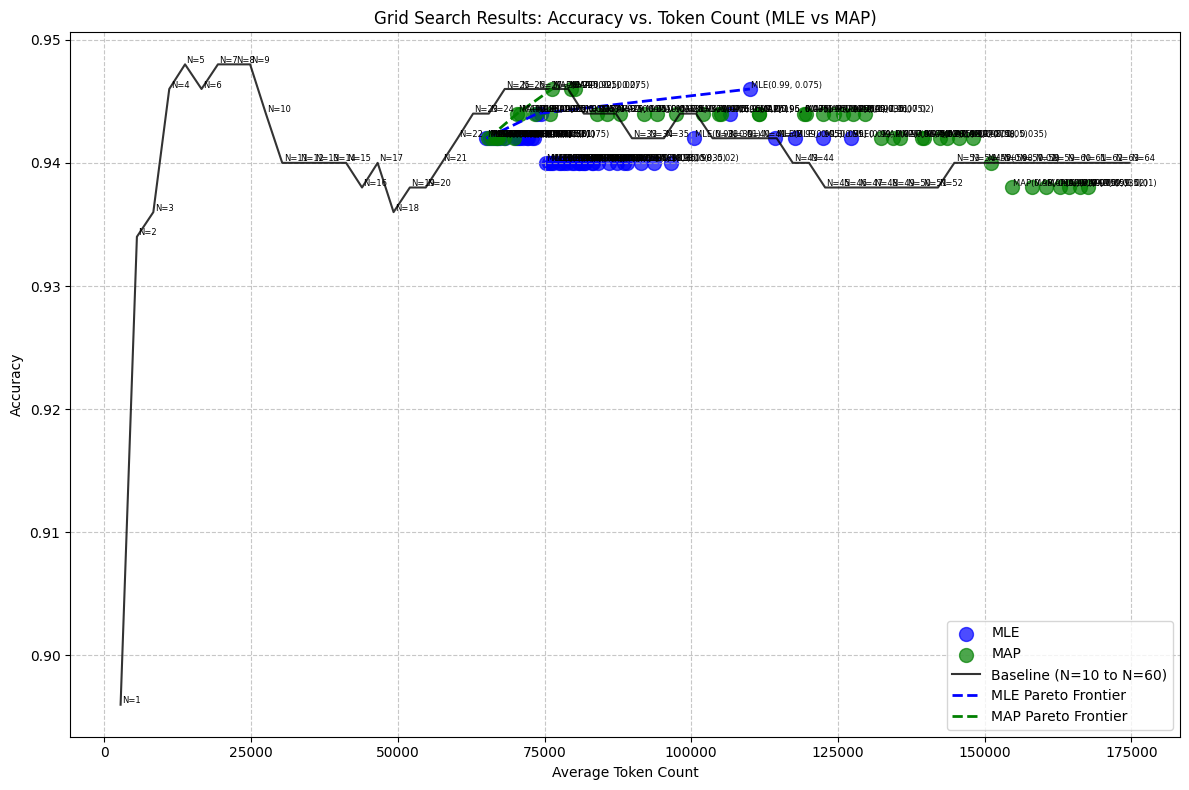


MLE Pareto-optimal configurations:
Target Score: 0.85, Percentile: 0.1, Accuracy: 0.9420, Avg Token Count: 65086.80
Target Score: 0.925, Percentile: 0.05, Accuracy: 0.9440, Avg Token Count: 73747.03
Target Score: 0.99, Percentile: 0.075, Accuracy: 0.9460, Avg Token Count: 110000.66

MAP Pareto-optimal configurations:
Target Score: 0.85, Percentile: 0.1, Accuracy: 0.9420, Avg Token Count: 65427.26
Target Score: 0.85, Percentile: 0.01, Accuracy: 0.9440, Avg Token Count: 70354.12
Target Score: 0.925, Percentile: 0.1, Accuracy: 0.9460, Avg Token Count: 76284.33


In [12]:
max_N_panel = 64
print("Target Score Panel:", target_score_panel_values)
print("Percentile Panel:", percentile_panel_values)
print("Max N:", max_N_panel)

# Evaluate MLE results
print("\nEvaluating MLE Results...")
truncated_normal_params_all = mle_estimated_params
mle_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MLE)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MLE Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MLE - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MLE - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        mle_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MLE_results_{max_N_panel}.json', 'w') as f:
    json.dump(mle_grid_search_results, f)


# Evaluate MAP results
print("\nEvaluating MAP Results...")
truncated_normal_params_all = map_estimated_params
map_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MAP)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MAP Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MAP - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MAP - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        map_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MAP_results_{max_N_panel}.json', 'w') as f:
    json.dump(map_grid_search_results, f)

plot_mle_map_optscale(mle_grid_search_results, map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel)